In [1]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [3]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [4]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [5]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [6]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [7]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

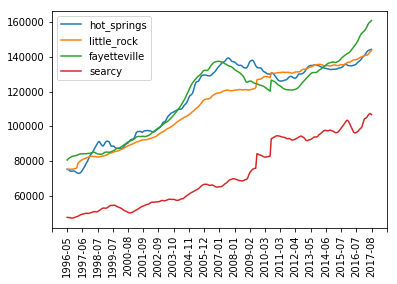

In [8]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [9]:
# remove rows with unemployment >= 3.5%
df = df[df.Unemployment < 3.5]

# remove rows with crime >= 3%
df = df[df.CrimeRatio < 0.03]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [10]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [11]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [12]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [13]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will 

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1992.196
Method:                       css-mle   S.D. of innovations           1006.221
Date:                Sun, 18 Nov 2018   AIC                           3998.391
Time:                        10:00:50   BIC                           4022.726
Sample:                    02-01-1997   HQIC                          4008.197
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1010.1910    484.735      2.084      0.038      60.127    1960.255
ar.L1.D.y      0.7894      0.065     12.235      0.000       0.663       0.916
ar.L2.D.y     -0.0996      0.082     -1.211      0.2

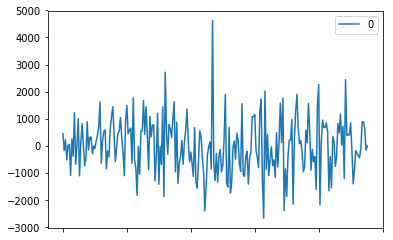

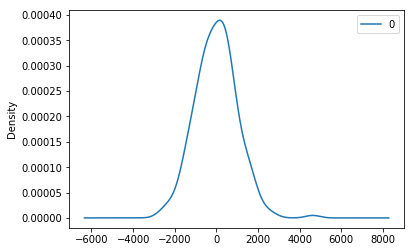

In [14]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [15]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean     -2.069194
std    1008.618450
min   -2682.753851
25%    -675.706720
50%       9.156721
75%     595.122398
max    4625.965351


In [17]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)

C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra


date: 2017-2
-----------------------------------------------
predicted=388813.576701, expected=391050.000000
prediction difference: 0.005719

predicted=388813.576701

date: 2017-3
-----------------------------------------------
predicted=390443.689396, expected=392900.000000
prediction difference: 0.006252

predicted=390443.689396

date: 2017-4
-----------------------------------------------
predicted=392003.290988, expected=395800.000000
prediction difference: 0.009592

predicted=392003.290988

date: 2017-5
-----------------------------------------------
predicted=393503.316512, expected=398850.000000
prediction difference: 0.013405

predicted=393503.316512

date: 2017-6
-----------------------------------------------
predicted=394958.772728, expected=400850.000000
prediction difference: 0.014697

predicted=394958.772728

date: 2017-7
-----------------------------------------------
predicted=396374.708561, expected=402250.000000
prediction difference: 0.014606

predicted=396374.70856

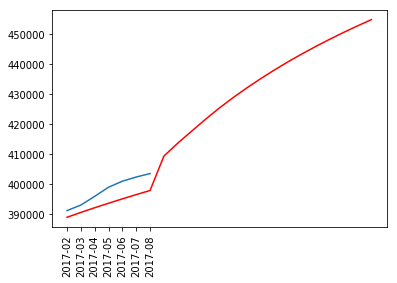

In [18]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [19]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def compute_arima(df_train, iterations=len(df_test)):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()

    for t in range(iterations):
        delta = 0
        model_fit = False

        #
        # determine stationarity value: differencing handled with supplied data,
        #     as an indirect solution, since statsmodel not allow d > 2.
        #
        # @delta, autoregressive factor.
        #
        for delta in range(10):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(stationary, order=(10, 0, 1))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('bad condition {}: stationarity not adequate'.format(delta))
                    continue

        # no significant stationarity: use any that works
        if not model_fit:
            for delta in range(10):
                stationary = difference(history, delta)
                stationary.index = history[1:]
                result = adfuller(stationary)
                print('delta: {}, p: {}'.format(delta, result[1]))

                #
                # generate model: increase autoregression
                #
                try:
                    model = ARIMA(stationary, order=(10, 0, 1))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('bad condition {}: stationarity not adequate'.format(delta))
                    continue

        #
        # generate forecast: an inverse difference is needed to reverse the earlier
        #     difference model scaling.
        #
        if model_fit:
            output = model_fit.forecast()
            yhat = inverse_difference(history, output[0], delta)

            #
            # observation: if current value doesn't exist from test, append current
            #     predition, to ensure successive rolling prediction computed.
            #
            try:
                obs = df_test[t]
            except:
                obs = yhat
            history.append(obs)
            predictions.append(yhat)
        else:
            predictions.append(None)
            break

        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [20]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

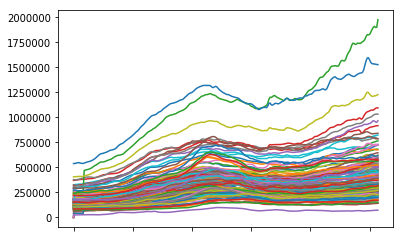

In [21]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [ ]:
# iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupporte

delta: 0, p: nan
delta: 1, p: 0.43581480343739437
delta: 2, p: 0.09602268561265981
delta: 3, p: 0.12330830782157487
delta: 4, p: 0.13016438413596815
delta: 5, p: 0.10373052767375313
delta: 6, p: 0.1603877865387051
delta: 7, p: 0.042705747735187594
predictions: [array([344226.00658382])]
delta: 0, p: nan
delta: 1, p: 0.8768240199863697
delta: 2, p: 0.8828024790581743
delta: 3, p: 0.039179355794582676


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301])]
delta: 0, p: nan
delta: 1, p: 0.15158606647269718
delta: 2, p: 0.0018426601523951897


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301]), array([412880.71951544])]
delta: 0, p: nan
delta: 1, p: 0.00021384232041649597


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301]), array([412880.71951544]), array([404797.31772275])]
delta: 0, p: nan
delta: 1, p: 6.459178176025904e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301]), array([412880.71951544]), array([404797.31772275]), array([402855.77823772])]
delta: 0, p: nan
delta: 1, p: 5.703022030764592e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301]), array([412880.71951544]), array([404797.31772275]), array([402855.77823772]), array([412061.85195022])]
delta: 0, p: nan
delta: 1, p: 4.9887507058352884e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([344226.00658382]), array([382998.00143301]), array([412880.71951544]), array([404797.31772275]), array([402855.77823772]), array([412061.85195022]), array([403655.02744931])]
delta: 0, p: nan
delta: 1, p: 0.3052551311039995
delta: 2, p: 0.021320120487985518


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([237966.74653401])]
delta: 0, p: nan
delta: 1, p: 0.4558473736448858
delta: 2, p: 0.23274885370376386
delta: 3, p: 0.4033439268825675
delta: 4, p: 4.23375524590364e-15
predictions: [array([237966.74653401]), array([308502.37132928])]
delta: 0, p: nan
delta: 1, p: 1.0199842297079028e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([237966.74653401]), array([308502.37132928]), array([428322.18232146])]
delta: 0, p: nan
delta: 1, p: 9.470413498841611e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 8.497942050335637e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.9041293291271675
delta: 4, p: 0.9516730394930468
delta: 5, p: 1.7621133261774645e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([237966.74653401]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684])]
delta: 0, p: nan
delta: 1, p: 8.816050206692114e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([237966.74653401]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([331932.38686442])]
delta: 0, p: nan
delta: 1, p: 8.164451752348966e-29
predictions: [array([237966.74653401]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([331932.38686442]), array([433759.78222388])]
delta: 0, p: nan
delta: 1, p: 7.564010573756768e-29
predictions: [array([237966.74653401]), array([308502.37132928]), array([428322.18232146]), array([314079.0603684]), array([331932.38686442]), array([433759.78222388]), array([403396.28593584])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.029907846604406978


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([312503.82902581])]
delta: 0, p: nan
delta: 1, p: 0.690340698331332
delta: 2, p: 0.07030938192254911
delta: 3, p: 0.10785791284824403
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([312503.82902581]), array([371616.64057452])]
delta: 0, p: nan
delta: 1, p: 7.226524064961006e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.31631541291382503
delta: 3, p: 0.05877839971743285
delta: 4, p: 0.24320648745831142
delta: 5, p: 0.003531379559904771
predictions: [array([312503.82902581]), array([371616.64057452]), array([370159.93184512])]
delta: 0, p: nan
delta: 1, p: 1.988197806749615e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([312503.82902581]), array([371616.64057452]), array([370159.93184512]), array([405660.43207064])]
delta: 0, p: nan
delta: 1, p: 1.8295452200779012e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([312503.82902581]), array([371616.64057452]), array([370159.93184512]), array([405660.43207064]), array([392063.47591372])]
delta: 0, p: nan
delta: 1, p: 1.6355821125642477e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([312503.82902581]), array([371616.64057452]), array([370159.93184512]), array([405660.43207064]), array([392063.47591372]), array([402408.90844676])]
delta: 0, p: nan
delta: 1, p: 1.4641632861451348e-25
predictions: [array([312503.82902581]), array([371616.64057452]), array([370159.93184512]), array([405660.43207064]), array([392063.47591372]), array([402408.90844676]), array([403416.18985648])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.29761973706228295
delta: 2, p: 0.10870299644714909
delta: 3, p: 0.007966593451658444


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626])]
delta: 0, p: nan
delta: 1, p: 0.5408066111239609
delta: 2, p: 0.11587310549638818
delta: 3, p: 0.5307484047072955
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974])]
delta: 0, p: nan
delta: 1, p: 0.6918931108643536
delta: 2, p: 0.3253846102884248
delta: 3, p: 0.8028715171333994
delta: 4, p: 0.8816541583369674
delta: 5, p: 4.056187359263081e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974]), array([360262.97385889])]
delta: 0, p: nan
delta: 1, p: 1.087612597548957e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051])]
delta: 0, p: nan
delta: 1, p: 1.011156843921274e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([413079.50626858])]
delta: 0, p: nan
delta: 1, p: 9.225822663477897e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([413079.50626858]), array([441425.64143039])]
delta: 0, p: nan
delta: 1, p: 8.41435659677635e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([298009.80569626]), array([359474.96322974]), array([360262.97385889]), array([387412.62355051]), array([413079.50626858]), array([441425.64143039]), array([403493.64810675])]
delta: 0, p: nan
delta: 1, p: 0.38129134811371024
delta: 2, p: 0.07845233864600282
delta: 3, p: 0.17462785006160925
delta: 4, p: 0.010221138460875854


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204])]
delta: 0, p: nan
delta: 1, p: 0.7914057663659043
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 7.378200585890994e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204]), array([295768.26631112])]
delta: 0, p: nan
delta: 1, p: 1.0876574018979374e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9381771945055973
delta: 3, p: 1.4019769553286292e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204]), array([295768.26631112]), array([281804.83883522])]
delta: 0, p: nan
delta: 1, p: 1.0086561475680359e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536])]
delta: 0, p: nan
delta: 1, p: 9.376148286989256e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([422776.20396274])]
delta: 0, p: nan
delta: 1, p: 8.678278398964988e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([226466.38615204]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([422776.20396274]), array([417706.99772034])]
delta: 0, p: nan
delta: 1, p: 8.036288516091894e-29
predictions: [array([226466.38615204]), array([295768.26631112]), array([281804.83883522]), array([340895.07758536]), array([422776.20396274]), array([417706.99772034]), array([403432.3590088])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.23114187316675217
delta: 2, p: 0.04835996370018675


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683])]
delta: 0, p: nan
delta: 1, p: 0.5218262666998853
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683]), array([454957.82675969])]
delta: 0, p: nan
delta: 1, p: 8.13017841191645e-29
bad condition 1: stationarity not adequate
delta: 2, p: 0.9216348924020965
delta: 3, p: 2.4164096729558693e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683]), array([454957.82675969]), array([312134.18153509])]
delta: 0, p: nan
delta: 1, p: 7.550165497046469e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683]), array([454957.82675969]), array([312134.18153509]), array([388385.55041419])]
delta: 0, p: nan
delta: 1, p: 7.026306019084879e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683]), array([454957.82675969]), array([312134.18153509]), array([388385.55041419]), array([388448.39096663])]
delta: 0, p: nan
delta: 1, p: 6.517934912126225e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([208380.28144683]), array([454957.82675969]), array([312134.18153509]), array([388385.55041419]), array([388448.39096663]), array([414060.78975265])]
delta: 0, p: nan
delta: 1, p: 6.049975747900385e-29
predictions: [array([208380.28144683]), array([454957.82675969]), array([312134.18153509]), array([388385.55041419]), array([388448.39096663]), array([414060.78975265]), array([403430.36074984])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.05766580901828412
delta: 2, p: 0.04409623656804488


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209])]
delta: 0, p: nan
delta: 1, p: 0.6006188461234814
delta: 2, p: 0.47555320672308604
delta: 3, p: 0.0
bad condition 3: stationarity not adequate
delta: 4, p: 0.14759570738936384
delta: 5, p: 0.47101306094814827
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209]), array([349476.45389929])]
delta: 0, p: nan
delta: 1, p: 0.16319785002336173
delta: 2, p: 0.8722721916489848
delta: 3, p: 0.04433942368930303


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209]), array([349476.45389929]), array([348453.62949919])]
delta: 0, p: nan
delta: 1, p: 7.804614161097689e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.004214497394939105


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209]), array([349476.45389929]), array([348453.62949919]), array([376531.97715584])]
delta: 0, p: nan
delta: 1, p: 7.239974408489753e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209]), array([349476.45389929]), array([348453.62949919]), array([376531.97715584]), array([395144.52428408])]
delta: 0, p: nan
delta: 1, p: 6.6170392303553975e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([286754.96864209]), array([349476.45389929]), array([348453.62949919]), array([376531.97715584]), array([395144.52428408]), array([397212.07819085])]
delta: 0, p: nan
delta: 1, p: 6.0462331949258985e-28
predictions: [array([286754.96864209]), array([349476.45389929]), array([348453.62949919]), array([376531.97715584]), array([395144.52428408]), array([397212.07819085]), array([403405.5912549])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.20104000450446313
delta: 2, p: 0.10442949443925942
delta: 3, p: 0.11895655803914423
delta: 4, p: 0.2801252337526511
delta: 5, p: 0.08119331219292408
delta: 6, p: 0.20723884656638508
delta: 7, p: 0.009728206197508017


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571])]
delta: 0, p: nan
delta: 1, p: 0.8516599283877004
delta: 2, p: 0.5867204786659107
delta: 3, p: 0.7969178993657532
delta: 4, p: 0.8420330520516643
delta: 5, p: 0.8935490155474902
delta: 6, p: 0.4731218645424165
delta: 7, p: 0.6477183306884255
delta: 8, p: 7.288435035895183e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766])]
delta: 0, p: nan
delta: 1, p: 0.7247019852742096
delta: 2, p: 0.2327956768366934
delta: 3, p: 0.4021822831241134
delta: 4, p: 0.4903523916978116
delta: 5, p: 0.14875911773314
delta: 6, p: 0.481314219216015
delta: 7, p: 0.34557729322781794
delta: 8, p: 0.25563801512486867
delta: 9, p: 1.1550506251897159e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766]), array([363032.51055599])]
delta: 0, p: nan
delta: 1, p: 0.5688857028431646
delta: 2, p: 0.09598733851821278
delta: 3, p: 0.27274866308718515
delta: 4, p: 0.2073812569677041
delta: 5, p: 0.0740371097913077
delta: 6, p: 0.35003862826108667
delta: 7, p: 0.28235330077521464
delta: 8, p: 0.2195706132046551
delta: 9, p: 4.826125419096989e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766]), array([363032.51055599]), array([369879.56925565])]
delta: 0, p: nan
delta: 1, p: 0.5504613122633772
delta: 2, p: 0.06360171073891133
delta: 3, p: 0.17875266627293346
delta: 4, p: 0.17785590118466188
delta: 5, p: 0.4382933041344027
delta: 6, p: 0.3969789186966042
delta: 7, p: 0.18969034031728343
delta: 8, p: 0.19578350070119327
delta: 9, p: 3.146534823061566e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766]), array([363032.51055599]), array([369879.56925565]), array([369151.29432247])]
delta: 0, p: nan
delta: 1, p: 0.49523664313949156
delta: 2, p: 0.04139268721694521


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766]), array([363032.51055599]), array([369879.56925565]), array([369151.29432247]), array([423660.67795812])]
delta: 0, p: nan
delta: 1, p: 0.2977599715985486
delta: 2, p: 0.019936314838252717


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([465345.45552571]), array([357648.21195766]), array([363032.51055599]), array([369879.56925565]), array([369151.29432247]), array([423660.67795812]), array([373542.26897096])]
delta: 0, p: nan
delta: 1, p: 0.29133386874437767
delta: 2, p: 0.1436818273292083
delta: 3, p: 0.0902632074351799
delta: 4, p: 0.2632718658983016
delta: 5, p: 0.05766296020616512
delta: 6, p: 0.19244397659048068
delta: 7, p: 0.03045909385437504


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323])]
delta: 0, p: nan
delta: 1, p: 0.8215717132505028
delta: 2, p: 0.5579773535558226
delta: 3, p: 0.5654602615550642
delta: 4, p: 0.6988089554755814
delta: 5, p: 0.5000536735033044
delta: 6, p: 0.31689882113824985
delta: 7, p: 0.21284454654505042
delta: 8, p: 0.542399274834882
delta: 9, p: 2.7430370989603587e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819])]
delta: 0, p: nan
delta: 1, p: 0.6234329963641017
delta: 2, p: 0.2406772867539827
delta: 3, p: 0.22140876359474915
delta: 4, p: 0.3729076723395637
delta: 5, p: 0.28069111362315824
delta: 6, p: 0.07135392395021098
delta: 7, p: 0.14719868777744105
delta: 8, p: 0.07730588307073827
delta: 9, p: 3.3561715720961617e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819]), array([370777.62032839])]
delta: 0, p: nan
delta: 1, p: 0.456263354637952
delta: 2, p: 0.11448999754178946
delta: 3, p: 0.12517267463127396
delta: 4, p: 0.1898011382057292
delta: 5, p: 0.21549252125456642
delta: 6, p: 0.5503166330396769
delta: 7, p: 0.1421757316121256
delta: 8, p: 0.5816197322360812
delta: 9, p: 3.940787870912279e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819]), array([370777.62032839]), array([372815.53172972])]
delta: 0, p: nan
delta: 1, p: 0.4097780681971207
delta: 2, p: 0.09526868187024051
delta: 3, p: 0.10192079279946115
delta: 4, p: 0.16954403206695146
delta: 5, p: 0.13602659453135524
delta: 6, p: 0.5018312599980748
delta: 7, p: 0.12865313016715052
delta: 8, p: 0.5356341264209188
delta: 9, p: 1.1414526159640959e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819]), array([370777.62032839]), array([372815.53172972]), array([374340.57654607])]
delta: 0, p: nan
delta: 1, p: 0.29261169426250855
delta: 2, p: 0.05072855847647823
delta: 3, p: 0.053810013363708276
delta: 4, p: 0.10174836164529855
delta: 5, p: 0.11529052129982426
delta: 6, p: 0.035013195658591414


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819]), array([370777.62032839]), array([372815.53172972]), array([374340.57654607]), array([409736.14114607])]
delta: 0, p: nan
delta: 1, p: 0.21353842857978922
delta: 2, p: 0.04470879969658325


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([467199.91837323]), array([366105.05735819]), array([370777.62032839]), array([372815.53172972]), array([374340.57654607]), array([409736.14114607]), array([371821.58497128])]
delta: 0, p: nan
delta: 1, p: 0.5854532302226467
delta: 2, p: 0.2961150872054086
delta: 3, p: 0.3352963975378742
delta: 4, p: 0.1366238791490585
delta: 5, p: 0.33654280275942705
delta: 6, p: 0.43342474367677497
delta: 7, p: 0.02683712911590584


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736])]
delta: 0, p: nan
delta: 1, p: 0.5724976965831403
delta: 2, p: 0.28417287396115576
delta: 3, p: 0.32734214150177476
delta: 4, p: 0.12701446465957433
delta: 5, p: 0.316269285956195
delta: 6, p: 0.4238835098358495
delta: 7, p: 0.02422881953198721


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584])]
delta: 0, p: nan
delta: 1, p: 0.26211200559973313
delta: 2, p: 0.3334614647077685
delta: 3, p: 0.3558529869879145
delta: 4, p: 0.15826854754070202
delta: 5, p: 0.3552269442888826
delta: 6, p: 0.4791272850685244
delta: 7, p: 0.030788652234853116


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584]), array([395054.92858764])]
delta: 0, p: nan
delta: 1, p: 0.5694878767965704
delta: 2, p: 0.29833023889199195
delta: 3, p: 0.3338313943354221
delta: 4, p: 0.14893160029315033
delta: 5, p: 0.34080369231658236
delta: 6, p: 0.44363195737680106
delta: 7, p: 0.02778480627264013


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584]), array([395054.92858764]), array([397623.10432449])]
delta: 0, p: nan
delta: 1, p: 0.26810934228405403
delta: 2, p: 0.34322603750528596
delta: 3, p: 0.38506814718155274
delta: 4, p: 0.1606745735385986
delta: 5, p: 0.3703156449000363
delta: 6, p: 0.4950707684159759
delta: 7, p: 0.0336781100588365


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584]), array([395054.92858764]), array([397623.10432449]), array([399517.87464566])]
delta: 0, p: nan
delta: 1, p: 0.23014796942691934
delta: 2, p: 0.20043728442557845
delta: 3, p: 0.32106821808296326
delta: 4, p: 0.16243687619852692
delta: 5, p: 0.3383196828810684
delta: 6, p: 0.4417713617559675
delta: 7, p: 0.03247078187376513


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584]), array([395054.92858764]), array([397623.10432449]), array([399517.87464566]), array([402111.74755783])]
delta: 0, p: nan
delta: 1, p: 0.22937354493453943
delta: 2, p: 0.18508106777322203
delta: 3, p: 0.3226130546667305
delta: 4, p: 0.14668046686099018
delta: 5, p: 0.3466208968370008
delta: 6, p: 0.46888757464468506
delta: 7, p: 0.03270714474617561


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393564.72179736]), array([393300.56798584]), array([395054.92858764]), array([397623.10432449]), array([399517.87464566]), array([402111.74755783]), array([403134.19022547])]
delta: 0, p: nan
delta: 1, p: 0.2721663917908017
delta: 2, p: 0.29291144291730276
delta: 3, p: 0.06310371597566154
delta: 4, p: 0.1934181203073368
delta: 5, p: 0.009255329437098728


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([594099.90361372])]
delta: 0, p: nan
delta: 1, p: 0.9987855414687671
delta: 2, p: 0.9984146150792227
delta: 3, p: 0.9630509713990678
delta: 4, p: 0.9732448634306964
delta: 5, p: 8.208613058654231e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([594099.90361372]), array([211574.58761011])]
delta: 0, p: nan
delta: 1, p: 0.942590403854169
delta: 2, p: 0.8463534055450592
delta: 3, p: 0.8914321748981469
delta: 4, p: 0.926614652489094
delta: 5, p: 0.6338644826772672
delta: 6, p: 0.8483134626881279
delta: 7, p: 4.310890934317004e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([594099.90361372]), array([211574.58761011]), array([215509.11606982])]
delta: 0, p: nan
delta: 1, p: 0.8773164320049324
delta: 2, p: 0.5787523655462751
delta: 3, p: 0.7467675871883717
delta: 4, p: 0.6555113581748613
delta: 5, p: 0.7072382174824
delta: 6, p: 0.4667851948981706
delta: 7, p: 0.43442061256077924
delta: 8, p: 0.5661054845182742
delta: 9, p: 0.7769628804319382
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.8773164320049324


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5787523655462751


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.7467675871883717


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([594099.90361372]), array([211574.58761011]), array([215509.11606982]), array([195772.1625599])]
delta: 0, p: nan
delta: 1, p: 5.879032982648061e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([594099.90361372]), array([211574.58761011]), array([215509.11606982]), array([195772.1625599]), array([335890.95510196])]
delta: 0, p: nan
delta: 1, p: 5.382221507282618e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([594099.90361372]), array([211574.58761011]), array([215509.11606982]), array([195772.1625599]), array([335890.95510196]), array([362554.19796036])]
delta: 0, p: nan
delta: 1, p: 4.9273961509762625e-28
predictions: [array([594099.90361372]), array([211574.58761011]), array([215509.11606982]), array([195772.1625599]), array([335890.95510196]), array([362554.19796036]), array([402974.12358804])]
delta: 0, p: nan
delta: 1, p: 0.2510367750382859


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.03427572384565644


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249])]
delta: 0, p: nan
delta: 1, p: 0.854037397114028
delta: 2, p: 0.9073239624867269
delta: 3, p: 0.427405195821971
delta: 4, p: 0.4712949445134221
delta: 5, p: 0.2533613610697387
delta: 6, p: 0.1034696614207199
delta: 7, p: 0.027658390669401983


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624])]
delta: 0, p: nan
delta: 1, p: 0.6571207681147742
delta: 2, p: 0.09316674487967569
delta: 3, p: 0.08627141948561234
delta: 4, p: 0.047599104152480046


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624]), array([385289.22430758])]
delta: 0, p: nan
delta: 1, p: 0.5324567740121551
delta: 2, p: 0.5728431884942125
delta: 3, p: 0.05887531466193046
delta: 4, p: 0.020496657357682257


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624]), array([385289.22430758]), array([405329.29087458])]
delta: 0, p: nan
delta: 1, p: 0.4398738590465438
delta: 2, p: 0.03467949497126221


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624]), array([385289.22430758]), array([405329.29087458]), array([381148.71670553])]
delta: 0, p: nan
delta: 1, p: 0.4016696224064017
delta: 2, p: 0.026043080778111464


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624]), array([385289.22430758]), array([405329.29087458]), array([381148.71670553]), array([415902.0562505])]
delta: 0, p: nan
delta: 1, p: 0.3518551212313147
delta: 2, p: 0.36980770761257326
delta: 3, p: 0.02589935931796042


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([436299.60773249]), array([384501.80928624]), array([385289.22430758]), array([405329.29087458]), array([381148.71670553]), array([415902.0562505]), array([380053.95443754])]
delta: 0, p: nan
delta: 1, p: 0.15966519011875585
delta: 2, p: 0.11738535929668353
delta: 3, p: 0.12527464965048923
delta: 4, p: 0.00955922728681996


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([683548.61413331])]
delta: 0, p: nan
delta: 1, p: 0.9831602944821368
delta: 2, p: 0.9644521952542309
delta: 3, p: 0.9051061983078086
delta: 4, p: 1.3528946763936872e-26
bad condition 4: stationarity not adequate
delta: 5, p: 1.4281659075797083e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([683548.61413331]), array([219138.8489596])]
delta: 0, p: nan
delta: 1, p: 0.652559738239133
delta: 2, p: 0.06014820692035523
delta: 3, p: 0.8012582265137911
delta: 4, p: 0.8450888946454166
delta: 5, p: 0.30436202579392535
delta: 6, p: 0.8368214366610349
delta: 7, p: 1.0778196077858304e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([683548.61413331]), array([219138.8489596]), array([191103.34653839])]
delta: 0, p: nan
delta: 1, p: 1.5204878328470326e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([683548.61413331]), array([219138.8489596]), array([191103.34653839]), array([330676.22994832])]
delta: 0, p: nan
delta: 1, p: 1.4057947027350766e-28
predictions: [array([683548.61413331]), array([219138.8489596]), array([191103.34653839]), array([330676.22994832]), array([427219.10433289])]
delta: 0, p: nan
delta: 1, p: 1.2978385075220306e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([683548.61413331]), array([219138.8489596]), array([191103.34653839]), array([330676.22994832]), array([427219.10433289]), array([367647.6291508])]
delta: 0, p: nan
delta: 1, p: 1.1986804413214464e-28
predictions: [array([683548.61413331]), array([219138.8489596]), array([191103.34653839]), array([330676.22994832]), array([427219.10433289]), array([367647.6291508]), array([402790.75337616])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.47719776979757067
delta: 2, p: 0.5355260207720766
delta: 3, p: 0.2581488383230631
delta: 4, p: 0.1018258592744864
delta: 5, p: 0.14639659688640277
delta: 6, p: 0.24221814725939073
delta: 7, p: 0.0009039123421667875


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([917217.8159676])]
delta: 0, p: nan
delta: 1, p: 0.9019681904300254
delta: 2, p: 0.9224027074078589
delta: 3, p: 0.9377222789732093
delta: 4, p: 0.8892118581530819
delta: 5, p: 0.9513861832021469
delta: 6, p: 0.890411762289377
delta: 7, p: 0.8038937874529108
delta: 8, p: 0.7880848687952353
delta: 9, p: 0.8559949078575209
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9019681904300254


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9224027074078589


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.9377222789732093


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([917217.8159676]), array([-707070.30200786])]
delta: 0, p: nan
delta: 1, p: 0.9207805350922782
delta: 2, p: 0.9218476225088149
delta: 3, p: 0.9366805737868179
delta: 4, p: 0.9009454298344494
delta: 5, p: 0.9295024080120472
delta: 6, p: 0.7966265748316905
delta: 7, p: 0.863379443691601
delta: 8, p: 0.3493600610580443
delta: 9, p: 0.7502286114046123
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9207805350922782


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([917217.8159676]), array([-707070.30200786]), array([-108931.71662918])]
delta: 0, p: nan
delta: 1, p: 0.8832936589474095
delta: 2, p: 0.9037015059859249
delta: 3, p: 0.9176785252232875
delta: 4, p: 0.877508982893388
delta: 5, p: 0.9223105096087019
delta: 6, p: 0.9377075422879997
delta: 7, p: 0.9547645969659991
delta: 8, p: 0.1793579649389095
delta: 9, p: 0.8947145961709604
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.8832936589474095


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([917217.8159676]), array([-707070.30200786]), array([-108931.71662918]), array([377792.23218374])]
delta: 0, p: nan
delta: 1, p: 0.8971350023562171
delta: 2, p: 0.8822737392052843
delta: 3, p: 0.893195519324022
delta: 4, p: 0.833365751857998
delta: 5, p: 0.8982855186091614
delta: 6, p: 0.8839220509470487
delta: 7, p: 0.9601927694688439
delta: 8, p: 0.4192005760178925
delta: 9, p: 0.9301586680836593
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.8971350023562171


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([917217.8159676]), array([-707070.30200786]), array([-108931.71662918]), array([377792.23218374]), array([399795.14613147])]
delta: 0, p: nan
delta: 1, p: 0.9160654123309144
delta: 2, p: 0.8781361313852338
delta: 3, p: 0.9056400434631967
delta: 4, p: 0.8885830406305951
delta: 5, p: 0.8442954822894926
delta: 6, p: 0.873993387216665
delta: 7, p: 0.8446296654187772
delta: 8, p: 0.7222541921422294
delta: 9, p: 0.9107246729729401
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9160654123309144
predictions: [array([917217.8159676]), array([-707070.30200786]), array([-108931.71662918]), array([377792.23218374]), array([399795.14613147]), array([350591.2991072])]
delta: 0, p: nan
delta: 1, p: 0.7700181095808809
delta: 2, p: 0.7367092346878834


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 3, p: 0.8361665368220415
delta: 4, p: 0.8342386205022212
delta: 5, p: 0.880504714254013
delta: 6, p: 0.803564211488202
delta: 7, p: 0.850967698888456
delta: 8, p: 0.7536912906811307
delta: 9, p: 0.81700517009072
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7700181095808809


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([917217.8159676]), array([-707070.30200786]), array([-108931.71662918]), array([377792.23218374]), array([399795.14613147]), array([350591.2991072]), array([402376.40646455])]
delta: 0, p: nan
delta: 1, p: 0.37004832541223676
delta: 2, p: 0.0921698688055182
delta: 3, p: 0.08392283954006263
delta: 4, p: 0.2758400805596695
delta: 5, p: 0.14094068139001759
delta: 6, p: 0.13863311675597956
delta: 7, p: 0.012887682293531598


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426])]
delta: 0, p: nan
delta: 1, p: 0.9054706973646904
delta: 2, p: 0.6772824971909486
delta: 3, p: 0.6156953026034596
delta: 4, p: 0.6381968730310801
delta: 5, p: 0.5704088259065588
delta: 6, p: 0.1730055919585946
delta: 7, p: 0.15882782002415796
delta: 8, p: 0.5622556537025589
delta: 9, p: 7.111788798583667e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904])]
delta: 0, p: nan
delta: 1, p: 0.8133045348633552
delta: 2, p: 0.3039375441887999
delta: 3, p: 0.2351195681822838
delta: 4, p: 0.23236756178015178
delta: 5, p: 0.19695575786906383
delta: 6, p: 0.023665485898808666


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904]), array([379661.58017456])]
delta: 0, p: nan
delta: 1, p: 0.731063876989153
delta: 2, p: 0.18179625522440374
delta: 3, p: 0.7610579007253611
delta: 4, p: 0.09655761565414084
delta: 5, p: 0.10690298578423191
delta: 6, p: 0.015228801519922319


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904]), array([379661.58017456]), array([381617.12135565])]
delta: 0, p: nan
delta: 1, p: 0.6367201074497537
delta: 2, p: 0.14029132007272838
delta: 3, p: 0.6634956707134949
delta: 4, p: 0.08578323905176882
delta: 5, p: 0.08250279120993947
delta: 6, p: 0.01924380693284133


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904]), array([379661.58017456]), array([381617.12135565]), array([386260.52385935])]
delta: 0, p: nan
delta: 1, p: 0.5495423692336666
delta: 2, p: 0.07035788951858947
delta: 3, p: 0.061509101132750585
delta: 4, p: 0.04332986533887086


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904]), array([379661.58017456]), array([381617.12135565]), array([386260.52385935]), array([408556.00080767])]
delta: 0, p: nan
delta: 1, p: 0.45133305088477293
delta: 2, p: 0.06067549895895844
delta: 3, p: 0.48697992038470234
delta: 4, p: 0.0677363303645693
delta: 5, p: 0.04363314700795513


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([445531.50093426]), array([378970.77456904]), array([379661.58017456]), array([381617.12135565]), array([386260.52385935]), array([408556.00080767]), array([412250.49348924])]
delta: 0, p: nan
delta: 1, p: 0.3561390990269889
delta: 2, p: 0.367912612427272
delta: 3, p: 0.3276326592810132
delta: 4, p: 0.29348236510690795
delta: 5, p: 0.23776552722312239
delta: 6, p: 0.321219397053129
delta: 7, p: 0.21467065544505515
delta: 8, p: 0.019708136602432202


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514])]
delta: 0, p: nan
delta: 1, p: 0.7441841908474192
delta: 2, p: 0.8185237957146154
delta: 3, p: 0.5756905361196067
delta: 4, p: 0.8248549647885846
delta: 5, p: 0.48735137884474533
delta: 6, p: 0.7587812172723044
delta: 7, p: 0.6062555737182862
delta: 8, p: 0.22979451300700465
delta: 9, p: 0.9071083131314459
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7441841908474192


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514]), array([411432.9653467])]
delta: 0, p: nan
delta: 1, p: 0.08025057918125705
delta: 2, p: 0.011319165075218083


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514]), array([411432.9653467]), array([400232.31314571])]
delta: 0, p: nan
delta: 1, p: 0.057000749117731626
delta: 2, p: 0.006001411014319082


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514]), array([411432.9653467]), array([400232.31314571]), array([390458.14467167])]
delta: 0, p: nan
delta: 1, p: 0.18680378714822032
delta: 2, p: 0.15739968210669125
delta: 3, p: 0.4808132639477507
delta: 4, p: 0.33682651715414214
delta: 5, p: 0.03899778648938988


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514]), array([411432.9653467]), array([400232.31314571]), array([390458.14467167]), array([397837.71572586])]
delta: 0, p: nan
delta: 1, p: 0.16264160813339507
delta: 2, p: 0.44349577927289296
delta: 3, p: 0.3642220637033693
delta: 4, p: 0.21626245685996526
delta: 5, p: 0.03242945538591487


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([378989.72752514]), array([411432.9653467]), array([400232.31314571]), array([390458.14467167]), array([397837.71572586]), array([412938.09104811])]
delta: 0, p: nan
delta: 1, p: 0.11287516686741705
delta: 2, p: 0.39473914354431633
delta: 3, p: 0.39527257517293796
delta: 4, p: 0.2232830931192738
delta: 5, p: 0.3802144576845892
delta: 6, p: 0.6695730219487375
delta: 7, p: 0.19471097648766922
delta: 8, p: 0.3316560210203793
delta: 9, p: 0.8313174402394665
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.11287516686741705
predictions: [array([378989.72752514]), array([411432.9653467]), array([400232.31314571]), array([390458.14467167]), array([397837.71572586]), array([412938.09104811]), array([403606.58307189])]
delta: 0, p: nan
delta: 1, p: 0.47470585864517545
delta: 2, p: 0.1478643995990151
delta: 3, p: 0.09132441098640798
delta: 4, p: 0.33192862679112073
delta: 5, p: 0.17138787229515534
delta: 6, p: 0.12161491940657049
delta: 7, p: 0.01711885103134021


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222])]
delta: 0, p: nan
delta: 1, p: 0.9527805406786224
delta: 2, p: 0.907844633785891
delta: 3, p: 9.191047757485448e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794])]
delta: 0, p: nan
delta: 1, p: 0.6514561738999667
delta: 2, p: 2.9019473894720397e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794]), array([265964.774261])]
delta: 0, p: nan
delta: 1, p: 2.6319226151421297e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 3.066332750919805e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794]), array([265964.774261]), array([408891.64733619])]
delta: 0, p: nan
delta: 1, p: 2.433865358822816e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794]), array([265964.774261]), array([408891.64733619]), array([380047.55478322])]
delta: 0, p: nan
delta: 1, p: 2.2391971091524796e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794]), array([265964.774261]), array([408891.64733619]), array([380047.55478322]), array([383263.78145492])]
delta: 0, p: nan
delta: 1, p: 2.0602154600343823e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([564908.18236222]), array([248329.10581794]), array([265964.774261]), array([408891.64733619]), array([380047.55478322]), array([383263.78145492]), array([403111.4968727])]
delta: 0, p: nan
delta: 1, p: 0.23919995555022183
delta: 2, p: 0.3535184537664673
delta: 3, p: 0.27408295407181804
delta: 4, p: 0.07302850823470475
delta: 5, p: 0.12630984882710194
delta: 6, p: 0.16681556966979016
delta: 7, p: 0.011753618126161354


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562])]
delta: 0, p: nan
delta: 1, p: 0.9795476306613029
delta: 2, p: 0.9719570836303891
delta: 3, p: 0.9963579103653385
delta: 4, p: 0.9770841951647421
delta: 5, p: 0.9550865305359437
delta: 6, p: 0.9621396976318092
delta: 7, p: 2.3968416641059156e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098])]
delta: 0, p: nan
delta: 1, p: 0.9625144820697941
delta: 2, p: 0.9449699934333748
delta: 3, p: 0.9462754277438663
delta: 4, p: 0.8690796585493288
delta: 5, p: 0.9582029302085598
delta: 6, p: 0.9001203818178967
delta: 7, p: 2.498899770511141e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098]), array([366624.90986994])]
delta: 0, p: nan
delta: 1, p: 0.9457403039901595
delta: 2, p: 0.9072375373285619
delta: 3, p: 0.8979648682299126
delta: 4, p: 0.8526965700402666
delta: 5, p: 0.9347488040139108
delta: 6, p: 0.8522248519134388
delta: 7, p: 0.9800205638047602
delta: 8, p: 0.6670531533274139
delta: 9, p: 0.0003686691038025906


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098]), array([366624.90986994]), array([373035.67559336])]
delta: 0, p: nan
delta: 1, p: 0.8703285890789472
delta: 2, p: 0.7714082217193365
delta: 3, p: 0.7733249236918154
delta: 4, p: 0.7553478227826553
delta: 5, p: 0.9085111590861608
delta: 6, p: 0.5821535455533475
delta: 7, p: 0.5989146444020268
delta: 8, p: 0.49928539746255046
delta: 9, p: 0.000267192930326583


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098]), array([366624.90986994]), array([373035.67559336]), array([210236.93540737])]
delta: 0, p: nan
delta: 1, p: 0.8794511963613844
delta: 2, p: 0.7603189303729239
delta: 3, p: 0.7612722144317722
delta: 4, p: 0.7101932015885247
delta: 5, p: 0.883785625275744
delta: 6, p: 0.7405533167389406
delta: 7, p: 1.6183921501465524e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098]), array([366624.90986994]), array([373035.67559336]), array([210236.93540737]), array([432409.08667143])]
delta: 0, p: nan
delta: 1, p: 0.8351173786951125
delta: 2, p: 0.8699813100710104
delta: 3, p: 0.7410250301541537
delta: 4, p: 0.8975374744829998
delta: 5, p: 0.9236746915675607
delta: 6, p: 0.9101097835076528
delta: 7, p: 0.9335029864096175
delta: 8, p: 0.6530652922276139
delta: 9, p: 0.00045221263195050095


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([785963.50645562]), array([361502.1081098]), array([366624.90986994]), array([373035.67559336]), array([210236.93540737]), array([432409.08667143]), array([421471.65471987])]
delta: 0, p: nan
delta: 1, p: 0.40271311312542446
delta: 2, p: 0.05564829418380088
delta: 3, p: 0.0789702179343314
delta: 4, p: 0.14347913538990037
delta: 5, p: 0.13625505249705083
delta: 6, p: 0.19573916606595054
delta: 7, p: 0.0005223428649882538


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702])]
delta: 0, p: nan
delta: 1, p: 0.9679346765067309
delta: 2, p: 0.9113241548753468
delta: 3, p: 0.9199043706486972
delta: 4, p: 0.9004161425332844
delta: 5, p: 1.7888788127859866e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486])]
delta: 0, p: nan
delta: 1, p: 0.7037074002805721
delta: 2, p: 2.2760845419884364e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486]), array([286827.8445629])]
delta: 0, p: nan
delta: 1, p: 0.1960885041889533
delta: 2, p: 0.2667712873540896
delta: 3, p: 0.7384153081577636
delta: 4, p: 8.212729264677973e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486]), array([286827.8445629]), array([422006.36441289])]
delta: 0, p: nan
delta: 1, p: 2.436318883025887e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486]), array([286827.8445629]), array([422006.36441289]), array([373645.57061297])]
delta: 0, p: nan
delta: 1, p: 2.2177155000195683e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486]), array([286827.8445629]), array([422006.36441289]), array([373645.57061297]), array([385625.23476997])]
delta: 0, p: nan
delta: 1, p: 2.0168044838270257e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([513707.8855702]), array([303854.65529486]), array([286827.8445629]), array([422006.36441289]), array([373645.57061297]), array([385625.23476997]), array([403106.04473025])]
delta: 0, p: nan
delta: 1, p: 0.128609468858774
delta: 2, p: 0.06038261671482873
delta: 3, p: 0.013653298229626317


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804])]
delta: 0, p: nan
delta: 1, p: 0.978185510737335
delta: 2, p: 0.9850035560642869
delta: 3, p: 0.840480433578584
delta: 4, p: 0.9280774905924379
delta: 5, p: 0.9372216355946649
delta: 6, p: 0.8935747521646422
delta: 7, p: 0.9067315211710653
delta: 8, p: 0.759927337168985
delta: 9, p: 7.610690758866843e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627])]
delta: 0, p: nan
delta: 1, p: 0.9698874732960536
delta: 2, p: 0.7696940966259197
delta: 3, p: 0.8481629760030822
delta: 4, p: 0.7819879781588468
delta: 5, p: 0.6974375791472484
delta: 6, p: 0.7738308122302756
delta: 7, p: 0.4916235812267318
delta: 8, p: 0.45028690474499855
delta: 9, p: 7.07526077651741e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627]), array([331868.72669251])]
delta: 0, p: nan
delta: 1, p: 0.9537108224856983
delta: 2, p: 0.6433842102731397
delta: 3, p: 0.7437258158256007
delta: 4, p: 0.8325938799066133
delta: 5, p: 0.7339044115600588
delta: 6, p: 0.45426941320402925
delta: 7, p: 0.8604583122778822
delta: 8, p: 0.4000741873250381
delta: 9, p: 0.775969145917464
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9537108224856983


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627]), array([331868.72669251]), array([309210.38007574])]
delta: 0, p: nan
delta: 1, p: 0.9416872091516022
delta: 2, p: 0.5729506663000319
delta: 3, p: 0.6689648580134518
delta: 4, p: 0.8383437228896554
delta: 5, p: 0.717435286958947
delta: 6, p: 0.45448899801385656
delta: 7, p: 0.8055700695345918
delta: 8, p: 0.5536584969837541
delta: 9, p: 0.6119517575139426
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9416872091516022


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5729506663000319


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627]), array([331868.72669251]), array([309210.38007574]), array([229412.11353567])]
delta: 0, p: nan
delta: 1, p: 0.9075714494554423
delta: 2, p: 0.431019696621863
delta: 3, p: 0.5402398185685671
delta: 4, p: 0.7089180585502262
delta: 5, p: 0.599783827419301
delta: 6, p: 0.5712563557902596
delta: 7, p: 0.38187773224181787
delta: 8, p: 0.64206741184392
delta: 9, p: 0.5113241998540411
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9075714494554423


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627]), array([331868.72669251]), array([309210.38007574]), array([229412.11353567]), array([380892.83854258])]
delta: 0, p: nan
delta: 1, p: 0.8076296104869065
delta: 2, p: 0.8517806851532013
delta: 3, p: 0.7879807780326588
delta: 4, p: 0.5866421157418538
delta: 5, p: 0.6003950554316023
delta: 6, p: 0.8518120754291993
delta: 7, p: 0.7046463982894257
delta: 8, p: 0.6776106090683172
delta: 9, p: 0.48379649349688203
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.8076296104869065


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([727475.26691804]), array([325678.8833627]), array([331868.72669251]), array([309210.38007574]), array([229412.11353567]), array([380892.83854258]), array([402590.605315])]
delta: 0, p: nan
delta: 1, p: 0.32243966643757715
delta: 2, p: 0.05561830233438745
delta: 3, p: 0.2892832007168501
delta: 4, p: 0.16950846955548216
delta: 5, p: 0.09417232365768091
delta: 6, p: 0.04854169336062255


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626])]
delta: 0, p: nan
delta: 1, p: 0.7368551954590912
delta: 2, p: 0.5580818038267911
delta: 3, p: 0.3932740435959216
delta: 4, p: 2.0753810081655437e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 4.302679110440197e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
delta: 6, p: 0.5338014230844005
delta: 7, p: 9.081285122878398e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626]), array([291036.52272811])]
delta: 0, p: nan
delta: 1, p: 8.426805824269975e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626]), array([291036.52272811]), array([347330.06100174])]
delta: 0, p: nan
delta: 1, p: 7.815138436584968e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626]), array([291036.52272811]), array([347330.06100174]), array([354483.60631359])]
delta: 0, p: nan
delta: 1, p: 7.257472834221444e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626]), array([291036.52272811]), array([347330.06100174]), array([354483.60631359]), array([383371.04710369])]
delta: 0, p: nan
delta: 1, p: 6.733832295950153e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([725717.87387626]), array([291036.52272811]), array([347330.06100174]), array([354483.60631359]), array([383371.04710369]), array([448788.50959298])]
delta: 0, p: nan
delta: 1, p: 6.251174110445462e-29
predictions: [array([725717.87387626]), array([291036.52272811]), array([347330.06100174]), array([354483.60631359]), array([383371.04710369]), array([448788.50959298]), array([402649.47047176])]
delta: 0, p: nan
delta: 1, p: 0.5316379296884699

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



delta: 2, p: 0.11438533254225064
delta: 3, p: 0.16627436137781337
delta: 4, p: 0.16638277697796272
delta: 5, p: 0.11426691697541957
delta: 6, p: 0.1656640332633873
delta: 7, p: 0.09954199053182627
delta: 8, p: 0.0011596692247861156


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543])]
delta: 0, p: nan
delta: 1, p: 0.7947930666794578
delta: 2, p: 0.8864984154799628
delta: 3, p: 0.7189091994710901
delta: 4, p: 0.7512299063966643
delta: 5, p: 0.36420936748847543
delta: 6, p: 0.7393276571531703
delta: 7, p: 0.3045354579405817
delta: 8, p: 0.48880220477718217
delta: 9, p: 4.4412528334842824e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543]), array([371361.34700779])]
delta: 0, p: nan
delta: 1, p: 0.6585385128105767
delta: 2, p: 0.6758965336503091
delta: 3, p: 0.42373312434286037
delta: 4, p: 0.3641973550406348
delta: 5, p: 0.3002305991591204
delta: 6, p: 0.5108862568676658
delta: 7, p: 0.08713702541185003
delta: 8, p: 0.49570500464794376
delta: 9, p: 2.4681431671694714e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([462554.90893543]), array([371361.34700779]), array([373409.46013444])]
delta: 0, p: nan
delta: 1, p: 0.5291044935276025
delta: 2, p: 0.38511312867408043
delta: 3, p: 0.5211871147318154
delta: 4, p: 0.20094909388669946
delta: 5, p: 0.08333988007831017
delta: 6, p: 0.3171505918310786
delta: 7, p: 0.12320829643058051
delta: 8, p: 0.16903488582128973
delta: 9, p: 1.7247646639579748e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543]), array([371361.34700779]), array([373409.46013444]), array([379395.40800656])]
delta: 0, p: nan
delta: 1, p: 0.5101014850598429
delta: 2, p: 0.3774696989910666
delta: 3, p: 0.4948751023481592
delta: 4, p: 0.2140247603776228
delta: 5, p: 0.03058858456597934


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543]), array([371361.34700779]), array([373409.46013444]), array([379395.40800656]), array([413588.06190772])]
delta: 0, p: nan
delta: 1, p: 0.3951812743951576
delta: 2, p: 0.23594460050582372
delta: 3, p: 0.3121851894233679
delta: 4, p: 0.13974013775458616
delta: 5, p: 0.030721211945177667


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543]), array([371361.34700779]), array([373409.46013444]), array([379395.40800656]), array([413588.06190772]), array([339560.04152704])]
delta: 0, p: nan
delta: 1, p: 0.46530965768339566
delta: 2, p: 0.30611063180760634
delta: 3, p: 0.09419814951367916
delta: 4, p: 0.18991677035048132
delta: 5, p: 1.288862597409303e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([462554.90893543]), array([371361.34700779]), array([373409.46013444]), array([379395.40800656]), array([413588.06190772]), array([339560.04152704]), array([418606.33899714])]
delta: 0, p: nan
delta: 1, p: 0.4892729148920948
delta: 2, p: 0.11583902643054128
delta: 3, p: 0.16143320058461041
delta: 4, p: 0.4030838548983131
delta: 5, p: 0.23795365412194414
delta: 6, p: 0.2659744396154258
delta: 7, p: 0.10614441731426827
delta: 8, p: 0.31041961661295764
delta: 9, p: 0.8466898964531351
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.4892729148920948


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874])]
delta: 0, p: nan
delta: 1, p: 0.4553421149881729
delta: 2, p: 0.5733041783178945
delta: 3, p: 0.5209875933703018
delta: 4, p: 0.3759106579532394
delta: 5, p: 0.2112332061094181
delta: 6, p: 0.3239547485967794
delta: 7, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587])]
delta: 0, p: nan
delta: 1, p: 0.06113440969908901
delta: 2, p: 0.004717983245023183


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587]), array([370676.44188823])]
delta: 0, p: nan
delta: 1, p: 0.002460252608800179


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587]), array([370676.44188823]), array([385420.96483923])]
delta: 0, p: nan
delta: 1, p: 0.0036791206778928522


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587]), array([370676.44188823]), array([385420.96483923]), array([390802.36483281])]
delta: 0, p: nan
delta: 1, p: 0.004731305705298568


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587]), array([370676.44188823]), array([385420.96483923]), array([390802.36483281]), array([395012.04123256])]
delta: 0, p: nan
delta: 1, p: 0.01066729470779706


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([424603.76587874]), array([388341.85268587]), array([370676.44188823]), array([385420.96483923]), array([390802.36483281]), array([395012.04123256]), array([403779.4660973])]
delta: 0, p: nan
delta: 1, p: 0.303981857168542
delta: 2, p: 0.3037983422522206
delta: 3, p: 0.1944903169393991
delta: 4, p: 0.1854310006485298
delta: 5, p: 0.1800576426189449
delta: 6, p: 0.21119153765311427
delta: 7, p: 0.04930285795050203


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([398808.5536704])]
delta: 0, p: nan
delta: 1, p: 0.39224332317012767
delta: 2, p: 0.16811676271872333
delta: 3, p: 0.19072722138652337
delta: 4, p: 0.08564045192701236
delta: 5, p: 0.20757811168355522
delta: 6, p: 0.30516715636663194
delta: 7, p: 0.039565801345097615


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([398808.5536704]), array([392584.07984613])]
delta: 0, p: nan
delta: 1, p: 0.27416665927411243
delta: 2, p: 0.3679083539950981
delta: 3, p: 0.30919045063182216
delta: 4, p: 0.23366087052857987
delta: 5, p: 0.26493153823254834
delta: 6, p: 0.29435649372518585
delta: 7, p: 0.12251388247867051
delta: 8, p: 0.33100888196170153
delta: 9, p: 0.7501517351492611
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.27416665927411243


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([398808.5536704]), array([392584.07984613]), array([398670.64652171])]
delta: 0, p: nan
delta: 1, p: 0.24223556061079304
delta: 2, p: 0.1318207038791322
delta: 3, p: 0.25037209032938135
delta: 4, p: 0.17927193734134117
delta: 5, p: 0.24822840985565586
delta: 6, p: 0.2034885753179541
delta: 7, p: 0.20425878903586542
delta: 8, p: 0.2684581710906613
delta: 9, p: 0.7492585333545061
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.24223556061079304
predictions: [array([398808.5536704]), array([392584.07984613]), array([398670.64652171]), array([396571.40987628])]
delta: 0, p: nan
delta: 1, p: 0.24986666181327444
delta: 2, p: 0.13374205777337983
delta: 3, p: 0.3344963380264324
delta: 4, p: 0.17906791334716382
delta: 5, p: 0.2711677739980747
delta: 6, p: 0.20327431139573643
delta: 7, p: 0.2034423341701786
delta: 8, p: 0.26789270014859146
delta: 9, p: 0.7486666904007104
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.24986666181327444


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([398808.5536704]), array([392584.07984613]), array([398670.64652171]), array([396571.40987628]), array([400803.13840129])]
delta: 0, p: nan
delta: 1, p: 0.2836181623422604
delta: 2, p: 0.16577178279697935
delta: 3, p: 0.33203845940077503
delta: 4, p: 0.24880706107560718
delta: 5, p: 0.2650769823161291
delta: 6, p: 0.26103432796230475
delta: 7, p: 0.2020278881782155
delta: 8, p: 0.26525352476369957
delta: 9, p: 0.7464428044380699
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.2836181623422604
predictions: [array([398808.5536704]), array([392584.07984613]), array([398670.64652171]), array([396571.40987628]), array([400803.13840129]), array([402555.40469199])]
delta: 0, p: nan
delta: 1, p: 0.22891592946927908
delta: 2, p: 0.15280219754175806
delta: 3, p: 0.2742978658506371
delta: 4, p: 0.20064833921549008
delta: 5, p: 0.2850982887299638
delta: 6, p: 0.2536058312523852
delta: 7, p: 0.19979761727728673
delta: 8, p: 0.26314110149697234
delta: 9, p: 0.7446738669200381
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.22891592946927908


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([398808.5536704]), array([392584.07984613]), array([398670.64652171]), array([396571.40987628]), array([400803.13840129]), array([402555.40469199]), array([403722.56465975])]
delta: 0, p: nan
delta: 1, p: 0.6161083144540208
delta: 2, p: 0.6173680980504475
delta: 3, p: 0.38809510949450166
delta: 4, p: 0.6297597052908566
delta: 5, p: 0.4338038977575765
delta: 6, p: 0.3450735610554232
delta: 7, p: 0.26160711374882645
delta: 8, p: 0.35552083547780405
delta: 9, p: 0.8401057706023278
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.6161083144540208


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615])]
delta: 0, p: nan
delta: 1, p: 0.9835308437232122
delta: 2, p: 0.936315090971774
delta: 3, p: 0.29574336003585033
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529])]
delta: 0, p: nan
delta: 1, p: 0.9528562826418087
delta: 2, p: 0.9043657963230292
delta: 3, p: 0.9399746106310333
delta: 4, p: 0.3101146941899212
delta: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529]), array([381632.35287666])]
delta: 0, p: nan
delta: 1, p: 0.6291586673494849
delta: 2, p: 0.15978379309468937
delta: 3, p: 0.4029962713907097
delta: 4, p: 0.4305882407770762
delta: 5, p: 0.9316314945550741
delta: 6, p: 1.1087357025793491e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529]), array([381632.35287666]), array([383584.46808877])]
delta: 0, p: nan
delta: 1, p: 0.6406456954545177
delta: 2, p: 0.28708266078724615
delta: 3, p: 1.5321909121644347e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529]), array([381632.35287666]), array([383584.46808877]), array([390150.13817651])]
delta: 0, p: nan
delta: 1, p: 0.7272308638535948
delta: 2, p: 2.193732987253685e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529]), array([381632.35287666]), array([383584.46808877]), array([390150.13817651]), array([390171.9306238])]
delta: 0, p: nan
delta: 1, p: 0.7702950391735929
delta: 2, p: 7.35795556420221e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([335377.34635615]), array([381065.23236529]), array([381632.35287666]), array([383584.46808877]), array([390150.13817651]), array([390171.9306238]), array([422018.25350735])]
delta: 0, p: nan
delta: 1, p: 0.17073916159448693
delta: 2, p: 0.29239020298528096
delta: 3, p: 0.11873151743040011
delta: 4, p: 0.02535077867963985


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802])]
delta: 0, p: nan
delta: 1, p: 0.6276919588547057
delta: 2, p: 0.2585725722372326
delta: 3, p: 0.09878490943328927
delta: 4, p: 0.10601981460973153
delta: 5, p: 0.07435883374572312
delta: 6, p: 0.08852472760603963
delta: 7, p: 0.33456549664349333
delta: 8, p: 0.30162420102018206
delta: 9, p: 3.4742965300329697e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671])]
delta: 0, p: nan
delta: 1, p: 0.35675610416310066
delta: 2, p: 0.11702868286672446
delta: 3, p: 0.011192974308983559


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671]), array([396514.41568017])]
delta: 0, p: nan
delta: 1, p: 0.2771716110936537
delta: 2, p: 0.05623324223083742
delta: 3, p: 0.0055453151000240085


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671]), array([396514.41568017]), array([370626.08597299])]
delta: 0, p: nan
delta: 1, p: 0.24801242082693598
delta: 2, p: 0.04733162579082982


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671]), array([396514.41568017]), array([370626.08597299]), array([377692.37012134])]
delta: 0, p: nan
delta: 1, p: 0.32799473105426913
delta: 2, p: 0.07789541829778016
delta: 3, p: 0.00785034200471551


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671]), array([396514.41568017]), array([370626.08597299]), array([377692.37012134]), array([423538.38736086])]
delta: 0, p: nan
delta: 1, p: 0.3718780529650627
delta: 2, p: 0.08347239121178857
delta: 3, p: 0.011705467173315262


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503925.99323802]), array([321731.65033671]), array([396514.41568017]), array([370626.08597299]), array([377692.37012134]), array([423538.38736086]), array([323887.71754318])]
delta: 0, p: nan
delta: 1, p: 0.41094670878631423
delta: 2, p: 0.03179111206051075


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916])]
delta: 0, p: nan
delta: 1, p: 0.9147819108173953
delta: 2, p: 0.8138163641803541
delta: 3, p: 4.2185766840142034e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.8584192759329236
delta: 5, p: 0.8892111280132446
delta: 6, p: 1.0380718809881152e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916]), array([274129.16048855])]
delta: 0, p: nan
delta: 1, p: 0.7433511091298266
delta: 2, p: 4.1784188710271175e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916]), array([274129.16048855]), array([257745.63857431])]
delta: 0, p: nan
delta: 1, p: 0.6008681313954226
delta: 2, p: 0.5802805246135134
delta: 3, p: 2.8890660430622914e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916]), array([274129.16048855]), array([257745.63857431]), array([235826.04481313])]
delta: 0, p: nan
delta: 1, p: 4.230616123895233e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916]), array([274129.16048855]), array([257745.63857431]), array([235826.04481313]), array([309898.75784351])]
delta: 0, p: nan
delta: 1, p: 3.880493464985173e-28
predictions: [array([540798.44362916]), array([274129.16048855]), array([257745.63857431]), array([235826.04481313]), array([309898.75784351]), array([395961.06026162])]
delta: 0, p: nan
delta: 1, p: 3.5585687522284492e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([540798.44362916]), array([274129.16048855]), array([257745.63857431]), array([235826.04481313]), array([309898.75784351]), array([395961.06026162]), array([403164.73894696])]
delta: 0, p: nan
delta: 1, p: 0.424397466642477
delta: 2, p: 0.08912469536555295
delta: 3, p: 0.056462352058753405
delta: 4, p: 0.3058655176861256
delta: 5, p: 0.13574819602342353
delta: 6, p: 0.10526922366452024
delta: 7, p: 0.0013160082941814472


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([595682.56051277])]
delta: 0, p: nan
delta: 1, p: 0.6104974915895492
delta: 2, p: 0.3088358270072822
delta: 3, p: 0.5160868232291866
delta: 4, p: 0.5215961734516776
delta: 5, p: 0.6331156130537785
delta: 6, p: 0.39507021474121784
delta: 7, p: 0.12553979134834625
delta: 8, p: 0.06426036703763982
delta: 9, p: 3.844430234462545e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([595682.56051277]), array([233812.74523684])]
delta: 0, p: nan
delta: 1, p: 0.5260180470062346
delta: 2, p: 0.12631329719220696
delta: 3, p: 0.24730904600575482
delta: 4, p: 0.22812208308206305
delta: 5, p: 0.4797150786127319
delta: 6, p: 0.21774383634076322
delta: 7, p: 0.10696259100455174
delta: 8, p: 0.00038599476485748607


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([595682.56051277]), array([233812.74523684]), array([265146.88096388])]
delta: 0, p: nan
delta: 1, p: 0.41684148422633244
delta: 2, p: 0.06513840726072358
delta: 3, p: 0.05165409739267468
delta: 4, p: 0.1626994421176216
delta: 5, p: 0.247145383606924
delta: 6, p: 0.06918811688078207
delta: 7, p: 0.17145538527517445
delta: 8, p: 0.00011003062856752204


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([595682.56051277]), array([233812.74523684]), array([265146.88096388]), array([296110.42204039])]
delta: 0, p: nan
delta: 1, p: 0.2769572179195492
delta: 2, p: 0.23334919963491624
delta: 3, p: 0.03237268385604744


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: divide by zero encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


bad condition 3: stationarity not adequate
delta: 4, p: 0.10974177134702656
delta: 5, p: 0.20297141551381498
delta: 6, p: 0.07642666906032049
delta: 7, p: 0.31126867406385555
delta: 8, p: 0.39536050767541947
delta: 9, p: 7.949770968926924e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([595682.56051277]), array([233812.74523684]), array([265146.88096388]), array([296110.42204039]), array([236346.86396523])]
delta: 0, p: nan
delta: 1, p: 0.3287389085230188
delta: 2, p: 0.31219839411916883
delta: 3, p: 0.04569702456618479


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([595682.56051277]), array([233812.74523684]), array([265146.88096388]), array([296110.42204039]), array([236346.86396523]), array([453407.44679859])]
delta: 0, p: nan
delta: 1, p: 0.45427479692703304
delta: 2, p: 0.3804076289631441
delta: 3, p: 0.07199613020059714
delta: 4, p: 0.1829658205929226
delta: 5, p: 0.40345489316040783
delta: 6, p: 0.003571992539430058


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([595682.56051277]), array([233812.74523684]), array([265146.88096388]), array([296110.42204039]), array([236346.86396523]), array([453407.44679859]), array([220083.2940373])]
delta: 0, p: nan
delta: 1, p: 0.4420960114586084
delta: 2, p: 0.3785119169861585
delta: 3, p: 0.34989586870891476
delta: 4, p: 0.1021670225988956
delta: 5, p: 0.4298020914025151
delta: 6, p: 0.30622589950796086
delta: 7, p: 0.2039115179361053
delta: 8, p: 0.010454276641432309


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468])]
delta: 0, p: nan
delta: 1, p: 0.4752454959530288
delta: 2, p: 0.8008647806316685
delta: 3, p: 0.5732793156263393
delta: 4, p: 0.3186896079570381
delta: 5, p: 0.48460297111123274
delta: 6, p: 0.36506042212940804
delta: 7, p: 0.4466082382172444
delta: 8, p: 0.4605671966457956
delta: 9, p: 4.972249596424231e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468]), array([392897.49000668])]
delta: 0, p: nan
delta: 1, p: 0.5220859650017357
delta: 2, p: 0.36340640662802226
delta: 3, p: 0.3735460960976149
delta: 4, p: 0.3667124362323104
delta: 5, p: 0.2112397426608718
delta: 6, p: 0.35754625299668963
delta: 7, p: 0.6433510974651464
delta: 8, p: 0.15120433678463552
delta: 9, p: 0.7035165148816572
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.5220859650017357
predictions: [array([408612.88337468]), array([392897.49000668]), array([387371.49585835])]
delta: 0, p: nan
delta: 1, p: 0.4093480470499374
delta: 2, p: 0.006389060240238497


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468]), array([392897.49000668]), array([387371.49585835]), array([398494.13871172])]
delta: 0, p: nan
delta: 1, p: 0.40343116533801415
delta: 2, p: 0.0047540575588875655


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468]), array([392897.49000668]), array([387371.49585835]), array([398494.13871172]), array([397321.19927178])]
delta: 0, p: nan
delta: 1, p: 0.4049646379198641
delta: 2, p: 0.35308576505702227
delta: 3, p: 0.2504452437160507
delta: 4, p: 0.3739118203509477
delta: 5, p: 0.16606717248948843
delta: 6, p: 0.3072576464759086
delta: 7, p: 0.6145862359696875
delta: 8, p: 0.13371865823819157
delta: 9, p: 0.6981032872305859
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.4049646379198641


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468]), array([392897.49000668]), array([387371.49585835]), array([398494.13871172]), array([397321.19927178]), array([399890.02455558])]
delta: 0, p: nan
delta: 1, p: 0.41122332555402297
delta: 2, p: 0.3493195900657894
delta: 3, p: 0.17075558849723604
delta: 4, p: 0.3722168942557403
delta: 5, p: 0.13130548688736599
delta: 6, p: 0.25841301804728717
delta: 7, p: 0.6125855633067441
delta: 8, p: 0.13781040363036817
delta: 9, p: 0.69993442869328
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.41122332555402297


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([408612.88337468]), array([392897.49000668]), array([387371.49585835]), array([398494.13871172]), array([397321.19927178]), array([399890.02455558]), array([403681.21167668])]
delta: 0, p: nan
delta: 1, p: 0.3971024403730981
delta: 2, p: 0.16504416525578786
delta: 3, p: 0.11498360786446621
delta: 4, p: 0.40782681766263185
delta: 5, p: 0.09664619117527484
delta: 6, p: 0.19175790174700685
delta: 7, p: 0.015499954332107952


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127])]
delta: 0, p: nan
delta: 1, p: 0.5928934000275804
delta: 2, p: 0.7050303273322038
delta: 3, p: 0.6950988172667145
delta: 4, p: 0.6604043242074888
delta: 5, p: 0.28285164006811375
delta: 6, p: 0.3283149932168222
delta: 7, p: 0.09133715356029337
delta: 8, p: 0.18171812962610945
delta: 9, p: 2.6226422114359546e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127]), array([392455.01489417])]
delta: 0, p: nan
delta: 1, p: 0.5245330147306226
delta: 2, p: 0.11944293909679943
delta: 3, p: 0.10620765298796875
delta: 4, p: 0.10687941395851136
delta: 5, p: 0.0698607790997056
delta: 6, p: 0.17307117920734655
delta: 7, p: 0.03132674955121404


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127]), array([392455.01489417]), array([391293.38439422])]
delta: 0, p: nan
delta: 1, p: 0.5112804591332752
delta: 2, p: 0.1083672619285534
delta: 3, p: 0.09632218114040975
delta: 4, p: 0.10090245328118996
delta: 5, p: 0.06970004182614378
delta: 6, p: 0.1702479358268923
delta: 7, p: 0.0315745747878888


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127]), array([392455.01489417]), array([391293.38439422]), array([395757.77126222])]
delta: 0, p: nan
delta: 1, p: 0.5093410815690215
delta: 2, p: 0.1064114526106954
delta: 3, p: 0.08948704206862501
delta: 4, p: 0.0995244149847282
delta: 5, p: 0.06989499509548121
delta: 6, p: 0.1791220244574731
delta: 7, p: 0.032322136988281396


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127]), array([392455.01489417]), array([391293.38439422]), array([395757.77126222]), array([398615.7106134])]
delta: 0, p: nan
delta: 1, p: 0.5018082251254287
delta: 2, p: 0.10475640225345628
delta: 3, p: 0.11302223853097776
delta: 4, p: 0.07621890727208878
delta: 5, p: 0.07357339062710207
delta: 6, p: 0.19779350239205734
delta: 7, p: 0.03542111254962794


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([410620.87302127]), array([392455.01489417]), array([391293.38439422]), array([395757.77126222]), array([398615.7106134]), array([402577.5039544])]
delta: 0, p: nan
delta: 1, p: 0.5192530837789017
delta: 2, p: 0.11161058813639907
delta: 3, p: 0.1140700651827406
delta: 4, p: 0.07107639210220189
delta: 5, p: 0.06063856598194467
delta: 6, p: 0.202285017136751
delta: 7, p: 0.03418779730973908
predictions: [array([410620.87302127]), array([392455.01489417]), array([391293.38439422]), array([395757.77126222]), array([398615.7106134]), array([402577.5039544]), array([403659.67936548])]
delta: 0, p: nan
delta: 1, p: 0.3236298061888612
delta: 2, p: 0.2679049965338456
delta: 3, p: 0.13031052766979978
delta: 4, p: 0.05980123636210632
delta: 5, p: 0.009912221957051081


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129])]
delta: 0, p: nan
delta: 1, p: 0.9361548535355331
delta: 2, p: 0.9374974527518309
delta: 3, p: 0.8077709967454395
delta: 4, p: 9.302287420380221e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.8944368399763114
delta: 6, p: 4.478232727687731e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129]), array([304589.21121758])]
delta: 0, p: nan
delta: 1, p: 0.8076115404383016
delta: 2, p: 1.3352213272024488e-27
predictions: [array([526015.28774129]), array([304589.21121758]), array([269059.08006179])]
delta: 0, p: nan
delta: 1, p: 0.26400235001593686
delta: 2, p: 0.28846406879508707
delta: 3, p: 0.827514196208625
delta: 4, p: 1.1727713478742413e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129]), array([304589.21121758]), array([269059.08006179]), array([380434.72818947])]
delta: 0, p: nan
delta: 1, p: 6.836163987181702e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129]), array([304589.21121758]), array([269059.08006179]), array([380434.72818947]), array([358588.832253])]
delta: 0, p: nan
delta: 1, p: 6.253717997501271e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129]), array([304589.21121758]), array([269059.08006179]), array([380434.72818947]), array([358588.832253]), array([402331.9863205])]
delta: 0, p: nan
delta: 1, p: 5.7190588311410335e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([526015.28774129]), array([304589.21121758]), array([269059.08006179]), array([380434.72818947]), array([358588.832253]), array([402331.9863205]), array([403183.92629877])]
delta: 0, p: nan
delta: 1, p: 0.3309320231426951
delta: 2, p: 0.05235000261017533
delta: 3, p: 0.026445588616860298


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([568858.11202306])]
delta: 0, p: nan
delta: 1, p: 0.8358251589593163
delta: 2, p: 0.9020977793383409
delta: 3, p: 3.6396594328895503e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([568858.11202306]), array([197188.02938208])]
delta: 0, p: nan
delta: 1, p: 0.7562066429414944
delta: 2, p: 0.5280953606085973
delta: 3, p: 0.8583162735361058
delta: 4, p: 0.6579793125499364
delta: 5, p: 0.4057558341040878
delta: 6, p: 3.939562473485953e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([568858.11202306]), array([197188.02938208]), array([234692.91062066])]
delta: 0, p: nan
delta: 1, p: 0.7209177989647088
delta: 2, p: 0.405587530917742
delta: 3, p: 0.8118756782491126
delta: 4, p: 0.5044199405235191
delta: 5, p: 0.3217538368662839
delta: 6, p: 2.5642245833961626e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([568858.11202306]), array([197188.02938208]), array([234692.91062066]), array([240065.59888061])]
delta: 0, p: nan
delta: 1, p: 0.674184311200315
delta: 2, p: 0.3084280838670122
delta: 3, p: 0.733346942547638
delta: 4, p: 0.4648698405777273
delta: 5, p: 0.265435206896409
delta: 6, p: 2.5295393110216808e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([568858.11202306]), array([197188.02938208]), array([234692.91062066]), array([240065.59888061]), array([248424.20139307])]
delta: 0, p: nan
delta: 1, p: 1.5416178961061224e-28
predictions: [array([568858.11202306]), array([197188.02938208]), array([234692.91062066]), array([240065.59888061]), array([248424.20139307]), array([414587.00087193])]
delta: 0, p: nan
delta: 1, p: 1.4223059120095515e-28
predictions: [array([568858.11202306]), array([197188.02938208]), array([234692.91062066]), array([240065.59888061]), array([248424.20139307]), array([414587.00087193]), array([402932.28857252])]
delta: 0, p: nan
delta: 1, p: 0.4978928538581698
delta: 2, p: 0.35922684748104206


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 3, p: 0.49285309872368155
delta: 4, p: 0.33246808745365186
delta: 5, p: 0.35181224582392867
delta: 6, p: 0.2925615831953359
delta: 7, p: 0.19728321514135733
delta: 8, p: 0.008718906554686845


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901])]
delta: 0, p: nan
delta: 1, p: 0.6930190636971032
delta: 2, p: 0.8047402860148407
delta: 3, p: 0.187095887943648
delta: 4, p: 0.8103422919118035
delta: 5, p: 0.6939528402804713
delta: 6, p: 4.2018463780368895e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901]), array([363549.33198347])]
delta: 0, p: nan
delta: 1, p: 0.16713100026234062
delta: 2, p: 0.7579637035455911
delta: 3, p: 0.5598624415613422
delta: 4, p: 0.6087041989546034
delta: 5, p: 0.5287491967285081
delta: 6, p: 0.63190733393609
delta: 7, p: 0.3177249632591054
delta: 8, p: 0.21757983954394527
delta: 9, p: 4.350596666342228e-21


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901]), array([363549.33198347]), array([368833.21757455])]
delta: 0, p: nan
delta: 1, p: 0.7312979924845772
delta: 2, p: 0.4895145748102499
delta: 3, p: 0.4403643507213395
delta: 4, p: 0.46650007390085363
delta: 5, p: 0.4271153100681979
delta: 6, p: 4.0540163969518557e-29
predictions: [array([473264.15791901]), array([363549.33198347]), array([368833.21757455]), array([368300.44843718])]
delta: 0, p: nan
delta: 1, p: 0.6724008350089301
delta: 2, p: 0.44205376126511126
delta: 3, p: 0.36920053921499263
delta: 4, p: 0.45774803332432185
delta: 5, p: 0.34838577603823717
delta: 6, p: 0.5893553266819296
delta: 7, p: 0.12448561094099103
delta: 8, p: 0.24311264514670328
delta: 9, p: 1.3032201556297292e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901]), array([363549.33198347]), array([368833.21757455]), array([368300.44843718]), array([375301.14119861])]
delta: 0, p: nan
delta: 1, p: 0.644744382017805
delta: 2, p: 0.3748883284421542
delta: 3, p: 0.3403180473751591
delta: 4, p: 0.37326860176515786
delta: 5, p: 0.3516589548056197
delta: 6, p: 0.6204480445163411
delta: 7, p: 0.1636046205407602
delta: 8, p: 0.6607676964891707
delta: 9, p: 2.4326736071798414e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901]), array([363549.33198347]), array([368833.21757455]), array([368300.44843718]), array([375301.14119861]), array([404330.78650751])]
delta: 0, p: nan
delta: 1, p: 0.6442282103619863
delta: 2, p: 0.398899391507922
delta: 3, p: 0.36329745115167605
delta: 4, p: 0.37117052439368703
delta: 5, p: 0.32658787382121046
delta: 6, p: 0.22278854804532205
delta: 7, p: 0.31481275783018053
delta: 8, p: 0.6900928146372165
delta: 9, p: 4.0914045843344826e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([473264.15791901]), array([363549.33198347]), array([368833.21757455]), array([368300.44843718]), array([375301.14119861]), array([404330.78650751]), array([404838.30375226])]
delta: 0, p: nan
delta: 1, p: 0.24558327175009753
delta: 2, p: 0.02689120159859523


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1091958.91887045])]
delta: 0, p: nan
delta: 1, p: 0.528253458698835
delta: 2, p: 0.6727033442918813
delta: 3, p: 0.04100556316071995
bad condition 3: stationarity not adequate
delta: 4, p: 0.01859470870501301


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.6340493743907978
delta: 6, p: 0.7969671428173939
delta: 7, p: 0.8738607517589639
delta: 8, p: 0.07481883432324178
delta: 9, p: 1.202238628998645e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1091958.91887045]), array([308336.79903405])]
delta: 0, p: nan
delta: 1, p: 0.5499914629146565
delta: 2, p: 0.6523483928398799
delta: 3, p: 0.12872590708402898
delta: 4, p: 0.036342248421740046


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([1091958.91887045]), array([308336.79903405]), array([-683602.65068363])]
delta: 0, p: nan
delta: 1, p: 0.45742350379808744
delta: 2, p: 0.5756647362020589
delta: 3, p: 0.05554576304582684
delta: 4, p: 0.31902400691322236
delta: 5, p: 0.654048785297967
delta: 6, p: 0.22537708593443545
delta: 7, p: 0.8451222220794912
delta: 8, p: 0.3348662016790057
delta: 9, p: 0.39568695945517507
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.45742350379808744


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1091958.91887045]), array([308336.79903405]), array([-683602.65068363]), array([630679.01856416])]
delta: 0, p: nan
delta: 1, p: 0.4284487027559897
delta: 2, p: 0.5504685914720193
delta: 3, p: 0.03973436405175008
predictions: [array([1091958.91887045]), array([308336.79903405]), array([-683602.65068363]), array([630679.01856416]), array([567705.32915612])]
delta: 0, p: nan
delta: 1, p: 0.6491572682830511
delta: 2, p: 0.7619665469770774
delta: 3, p: 0.7367300671832409
delta: 4, p: 0.4367964408920443
delta: 5, p: 0.42542191008646824
delta: 6, p: 0.4466410574454227
delta: 7, p: 0.5534415459444224
delta: 8, p: 0.7843058070677518
delta: 9, p: 0.09907471133323792
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.6491572682830511


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1091958.91887045]), array([308336.79903405]), array([-683602.65068363]), array([630679.01856416]), array([567705.32915612]), array([233215.3672999])]
delta: 0, p: nan
delta: 1, p: 0.5798170026067141
delta: 2, p: 0.5762072687215111
delta: 3, p: 0.4759521962366592
delta: 4, p: 0.3566602126439685
delta: 5, p: 0.3949745193154925
delta: 6, p: 0.4334766090633408
delta: 7, p: 0.33874265171027307
delta: 8, p: 0.4542325847262912
delta: 9, p: 0.09509329911061759
delta: 0, p: nan
bad condition 0: stationarity not adequate


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.5798170026067141
predictions: [array([1091958.91887045]), array([308336.79903405]), array([-683602.65068363]), array([630679.01856416]), array([567705.32915612]), array([233215.3672999]), array([402530.34248654])]
delta: 0, p: nan
delta: 1, p: 0.3364279329276664
delta: 2, p: 0.2728070875931963
delta: 3, p: 0.17453612256007317
delta: 4, p: 0.3017775939966817
delta: 5, p: 0.059030505291879025
delta: 6, p: 0.25276059541949275
delta: 7, p: 0.07778269050565036
delta: 8, p: 0.020970177576214156


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572])]
delta: 0, p: nan
delta: 1, p: 0.9689387820480562
delta: 2, p: 0.7862222600797799
delta: 3, p: 0.9162773702373805
delta: 4, p: 3.0911037283310044e-15
predictions: [array([525659.81977572]), array([293922.74776316])]
delta: 0, p: nan
delta: 1, p: 0.9240584327397806
delta: 2, p: 0.7035783727364538
delta: 3, p: 2.3624045771741464e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572]), array([293922.74776316]), array([399547.38519815])]
delta: 0, p: nan
delta: 1, p: 0.7582203884131813
delta: 2, p: 2.452519869946189e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572]), array([293922.74776316]), array([399547.38519815]), array([401748.85263673])]
delta: 0, p: nan
delta: 1, p: 0.7065703416758267
delta: 2, p: 1.526894297690784e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572]), array([293922.74776316]), array([399547.38519815]), array([401748.85263673]), array([317318.29389291])]
delta: 0, p: nan
delta: 1, p: 0.6481213916739067
delta: 2, p: 0.5935906273363589
delta: 3, p: 1.7232297875993964e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572]), array([293922.74776316]), array([399547.38519815]), array([401748.85263673]), array([317318.29389291]), array([416424.11878296])]
delta: 0, p: nan
delta: 1, p: 8.123039986873323e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([525659.81977572]), array([293922.74776316]), array([399547.38519815]), array([401748.85263673]), array([317318.29389291]), array([416424.11878296]), array([403301.83326784])]
delta: 0, p: nan
delta: 1, p: 0.2265550234435097
delta: 2, p: 0.10084813052219904
delta: 3, p: 0.059147257762892924
delta: 4, p: 0.013422006030035231


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([840367.22016169])]
delta: 0, p: nan
delta: 1, p: 0.9218221321658027
delta: 2, p: 0.2623765389878361
delta: 3, p: 0.9934380402049316
delta: 4, p: 0.982648112440302
delta: 5, p: 0.9853550812285697
delta: 6, p: 3.7800215581559236e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([840367.22016169]), array([305987.10826877])]
delta: 0, p: nan
delta: 1, p: 0.845992644810194
delta: 2, p: 0.8277481304927131
delta: 3, p: 0.9836752515156466
delta: 4, p: 0.8987686517543787
delta: 5, p: 0.984082629220235
delta: 6, p: 1.0397622658430418e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([840367.22016169]), array([305987.10826877]), array([262310.80689063])]
delta: 0, p: nan
delta: 1, p: 1.1617684482939407e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([840367.22016169]), array([305987.10826877]), array([262310.80689063]), array([160773.82586314])]
delta: 0, p: nan
delta: 1, p: 1.0744477013167896e-28
predictions: [array([840367.22016169]), array([305987.10826877]), array([262310.80689063]), array([160773.82586314]), array([339473.9883582])]
delta: 0, p: nan
delta: 1, p: 9.935667035457339e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([840367.22016169]), array([305987.10826877]), array([262310.80689063]), array([160773.82586314]), array([339473.9883582]), array([276324.33674766])]
delta: 0, p: nan
delta: 1, p: 9.193917091282861e-29
predictions: [array([840367.22016169]), array([305987.10826877]), array([262310.80689063]), array([160773.82586314]), array([339473.9883582]), array([276324.33674766]), array([402699.99266364])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.23550234077517124
delta: 2, p: 0.3303740130351295
delta: 3, p: 0.3566973397472847
delta: 4, p: 0.3952586334608498
delta: 5, p: 0.24337662394149756
delta: 6, p: 0.22636294741067514
delta: 7, p: 0.03695437440219274


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495])]
delta: 0, p: nan
delta: 1, p: 0.8454232696162812
delta: 2, p: 0.891739566951696
delta: 3, p: 0.8186056592549598
delta: 4, p: 0.7016535839088459
delta: 5, p: 0.37091968382495477
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916])]
delta: 0, p: nan
delta: 1, p: 0.009938740462073915


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916]), array([375420.89900775])]
delta: 0, p: nan
delta: 1, p: 0.0127561153611191


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916]), array([375420.89900775]), array([377776.14259963])]
delta: 0, p: nan
delta: 1, p: 0.01367673059007167


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916]), array([375420.89900775]), array([377776.14259963]), array([385914.77880747])]
delta: 0, p: nan
delta: 1, p: 0.015788457807772997


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916]), array([375420.89900775]), array([377776.14259963]), array([385914.77880747]), array([385750.90802368])]
delta: 0, p: nan
delta: 1, p: 0.011517337627666366


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([440112.98814495]), array([379335.10364916]), array([375420.89900775]), array([377776.14259963]), array([385914.77880747]), array([385750.90802368]), array([403675.46200221])]
delta: 0, p: nan
delta: 1, p: 0.24653615220364045
delta: 2, p: 0.1830445199206749
delta: 3, p: 0.19012713992478208
delta: 4, p: 0.07904415374905965
delta: 5, p: 0.2343174101449349
delta: 6, p: 0.25481110892505016
delta: 7, p: 0.054360088821677074
delta: 8, p: 0.03139014585906351


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([439538.39334595])]
delta: 0, p: nan
delta: 1, p: 0.5309017365550581
delta: 2, p: 0.858218209664533
delta: 3, p: 0.7290354540892482
delta: 4, p: 0.7392303012452754
delta: 5, p: 0.6775657552420916
delta: 6, p: 2.1061507366322422e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([439538.39334595]), array([380355.68924905])]
delta: 0, p: nan
delta: 1, p: 0.00011122088696954964
predictions: [array([439538.39334595]), array([380355.68924905]), array([375972.9633259])]
delta: 0, p: nan
delta: 1, p: 0.23030856768839764
delta: 2, p: 0.16102676972036156
delta: 3, p: 0.16043652092041683
delta: 4, p: 0.012627015669832983


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([439538.39334595]), array([380355.68924905]), array([375972.9633259]), array([405000.16362808])]
delta: 0, p: nan
delta: 1, p: 0.17025170364222653
delta: 2, p: 0.1644256519956539
delta: 3, p: 0.0562172548923718
delta: 4, p: 0.021380694185948942


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([439538.39334595]), array([380355.68924905]), array([375972.9633259]), array([405000.16362808]), array([367258.55052312])]
delta: 0, p: nan
delta: 1, p: 0.12973860244936014
delta: 2, p: 0.017667413332967608
predictions: [array([439538.39334595]), array([380355.68924905]), array([375972.9633259]), array([405000.16362808]), array([367258.55052312]), array([417325.38510991])]
delta: 0, p: nan
delta: 1, p: 0.18721609795127536
delta: 2, p: 0.03605892564124923


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([439538.39334595]), array([380355.68924905]), array([375972.9633259]), array([405000.16362808]), array([367258.55052312]), array([417325.38510991]), array([384326.7842991])]
delta: 0, p: nan
delta: 1, p: 0.22286073151038677
delta: 2, p: 0.06425811113113901
delta: 3, p: 0.1120677407928033
delta: 4, p: 0.32173930310632604
delta: 5, p: 0.03802503311845962


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([529033.94103407])]
delta: 0, p: nan
delta: 1, p: 0.7216908533857972
delta: 2, p: 0.37131892622058477
delta: 3, p: 0.6307605298328981
delta: 4, p: 3.5728354715042024e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([529033.94103407]), array([278785.7481378])]
delta: 0, p: nan
delta: 1, p: 0.4703680847432232
delta: 2, p: 0.77399466352136
delta: 3, p: 0.15744013243544558
delta: 4, p: 9.494819973223916e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([529033.94103407]), array([278785.7481378]), array([286230.3688205])]
delta: 0, p: nan
delta: 1, p: 5.316328100284843e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 6.485716737712435e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([529033.94103407]), array([278785.7481378]), array([286230.3688205]), array([419348.88071538])]
delta: 0, p: nan
delta: 1, p: 4.921433976738046e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([529033.94103407]), array([278785.7481378]), array([286230.3688205]), array([419348.88071538]), array([455289.71374501])]
delta: 0, p: nan
delta: 1, p: 4.513587905699435e-28
predictions: [array([529033.94103407]), array([278785.7481378]), array([286230.3688205]), array([419348.88071538]), array([455289.71374501]), array([354925.17854357])]
delta: 0, p: nan
delta: 1, p: 4.1368304964693405e-28
predictions: [array([529033.94103407]), array([278785.7481378]), array([286230.3688205]), array([419348.88071538]), array([455289.71374501]), array([354925.17854357]), array([403021.04825714])]
delta: 0, p: nan
delta: 1, p: 0.2691518701050794
delta: 2, p: 0.37404457126623847


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 3, p: 0.16567524444522125
delta: 4, p: 0.3338852990451453
delta: 5, p: 0.29320834036479243
delta: 6, p: 0.18954437647366723
delta: 7, p: 0.06795770284025643
delta: 8, p: 0.020013038985868623


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442769.39998674])]
delta: 0, p: nan
delta: 1, p: 0.918351215624746
delta: 2, p: 0.907516641706932
delta: 3, p: 0.6122815190148129
delta: 4, p: 0.9392893625700789
delta: 5, p: 0.82613790661498
delta: 6, p: 0.8908124763032115
delta: 7, p: 2.249948396106008e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442769.39998674]), array([378181.16544187])]
delta: 0, p: nan
delta: 1, p: 0.6314501002701951
delta: 2, p: 0.624054133756229
delta: 3, p: 0.1368293331426081
delta: 4, p: 0.3124056008059892
delta: 5, p: 0.44232935835862675
delta: 6, p: 7.389594333177234e-22
predictions: [array([442769.39998674]), array([378181.16544187]), array([381701.38117594])]
delta: 0, p: nan
delta: 1, p: 0.5517153777943945
delta: 2, p: 0.63694625543699
delta: 3, p: 0.22002355143310137
delta: 4, p: 0.3160844163630665
delta: 5, p: 0.5891859052095567
delta: 6, p: 1.074985716311616e-21


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442769.39998674]), array([378181.16544187]), array([381701.38117594]), array([385209.27928325])]
delta: 0, p: nan
delta: 1, p: 0.4308594656386574
delta: 2, p: 0.12134851894907661
delta: 3, p: 3.963789447802197e-10
predictions: [array([442769.39998674]), array([378181.16544187]), array([381701.38117594]), array([385209.27928325]), array([401250.28197754])]
delta: 0, p: nan
delta: 1, p: 0.2861945863392018
delta: 2, p: 1.5573259511261303e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442769.39998674]), array([378181.16544187]), array([381701.38117594]), array([385209.27928325]), array([401250.28197754]), array([408027.21992994])]
delta: 0, p: nan
delta: 1, p: 0.2507605072726977
delta: 2, p: 0.5703685693445235
delta: 3, p: 5.0364662850945815e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442769.39998674]), array([378181.16544187]), array([381701.38117594]), array([385209.27928325]), array([401250.28197754]), array([408027.21992994]), array([370110.29765996])]
delta: 0, p: nan
delta: 1, p: 0.2856913192266393
delta: 2, p: 0.326916653614857
delta: 3, p: 0.43391903067661486
delta: 4, p: 0.3669774514510188
delta: 5, p: 0.17244859489786157
delta: 6, p: 0.06862781817037877
delta: 7, p: 0.009832940640925741


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([474611.75048095])]
delta: 0, p: nan
delta: 1, p: 0.8408910639904295
delta: 2, p: 0.9384319365438764
delta: 3, p: 0.8571168971221861
delta: 4, p: 0.8625107799084023
delta: 5, p: 0.570175514273098
delta: 6, p: 0.8540180113739302
delta: 7, p: 0.826544735749489
delta: 8, p: 0.7485081364807302
delta: 9, p: 1.5018582699904563e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([474611.75048095]), array([355041.897011])]
delta: 0, p: nan
delta: 1, p: 0.11789151868687292
delta: 2, p: 0.19620979155421814
delta: 3, p: 0.0
predictions: [array([474611.75048095]), array([355041.897011]), array([400918.43294919])]
delta: 0, p: nan
delta: 1, p: 0.09163272873953948
delta: 2, p: 0.4317028518330628
delta: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([474611.75048095]), array([355041.897011]), array([400918.43294919]), array([345509.5714761])]
delta: 0, p: nan
delta: 1, p: 0.03854277963200936


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([474611.75048095]), array([355041.897011]), array([400918.43294919]), array([345509.5714761]), array([376497.87739816])]
delta: 0, p: nan
delta: 1, p: 1.332347153926662e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([474611.75048095]), array([355041.897011]), array([400918.43294919]), array([345509.5714761]), array([376497.87739816]), array([374971.65041918])]
delta: 0, p: nan
delta: 1, p: 1.2024852312616082e-26
predictions: [array([474611.75048095]), array([355041.897011]), array([400918.43294919]), array([345509.5714761]), array([376497.87739816]), array([374971.65041918]), array([403441.62736622])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.18008210652796575
delta: 2, p: 0.1935506707210254
delta: 3, p: 0.07835038420036018
delta: 4, p: 0.1130287991809582
delta: 5, p: 0.16375996811239468
delta: 6, p: 0.12938740615858546
delta: 7, p: 0.026387447889323564


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([672197.93181541])]
delta: 0, p: nan
delta: 1, p: 0.9799754775940878
delta: 2, p: 0.9501051103597346
delta: 3, p: 0.9184025086777015
delta: 4, p: 0.9514214678352092
delta: 5, p: 0.9769619119729969
delta: 6, p: 0.9787631512069914
delta: 7, p: 0.977519477159626
delta: 8, p: 0.9452260692793025
delta: 9, p: 0.0001372643592560233


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([672197.93181541]), array([237243.15641677])]
delta: 0, p: nan
delta: 1, p: 0.9553266524960371
delta: 2, p: 0.8976169901300658
delta: 3, p: 0.8738772370450447
delta: 4, p: 0.9135796124513422
delta: 5, p: 1.6615326007168029e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([672197.93181541]), array([237243.15641677]), array([-51424.86378972])]
delta: 0, p: nan
delta: 1, p: 0.9607208137700206
delta: 2, p: 0.8992368150200707
delta: 3, p: 0.8848407051183689
delta: 4, p: 0.8986701321242107
delta: 5, p: 3.4286514270213337e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([672197.93181541]), array([237243.15641677]), array([-51424.86378972]), array([126698.78639305])]
delta: 0, p: nan
delta: 1, p: 0.9283499753923242
delta: 2, p: 0.8562746219136154
delta: 3, p: 0.7541535776621839
delta: 4, p: 0.812452461146472
delta: 5, p: 0.2113127884737554
delta: 6, p: 0.9362325180961654
delta: 7, p: 0.8382526998031163
delta: 8, p: 0.4252453881989395
delta: 9, p: 6.540134475480098e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([672197.93181541]), array([237243.15641677]), array([-51424.86378972]), array([126698.78639305]), array([140192.75708329])]
delta: 0, p: nan
delta: 1, p: 1.4251197115380469e-28
predictions: [array([672197.93181541]), array([237243.15641677]), array([-51424.86378972]), array([126698.78639305]), array([140192.75708329]), array([389422.37012032])]
delta: 0, p: nan
delta: 1, p: 1.3152799908917838e-28
predictions: [array([672197.93181541]), array([237243.15641677]), array([-51424.86378972]), array([126698.78639305]), array([140192.75708329]), array([389422.37012032]), array([402999.55402007])]
delta: 0, p: nan

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



delta: 1, p: 0.3149272365084998
delta: 2, p: 0.2536194017196873
delta: 3, p: 0.18233276651631614
delta: 4, p: 0.41986963632941554
delta: 5, p: 0.2514073908149254
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([767941.9101596])]
delta: 0, p: nan
delta: 1, p: 0.8491331443140819
delta: 2, p: 0.9351777091944365
delta: 3, p: 0.5256367813071803
delta: 4, p: 0.6073635297143708
delta: 5, p: 1.3471461567153545e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([767941.9101596]), array([76413.94896925])]
delta: 0, p: nan
delta: 1, p: 9.533905521389345e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([767941.9101596]), array([76413.94896925]), array([442335.42249828])]
delta: 0, p: nan
delta: 1, p: 8.824530074030496e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([767941.9101596]), array([76413.94896925]), array([442335.42249828]), array([490598.7346576])]
delta: 0, p: nan
delta: 1, p: 8.177828894044013e-29
predictions: [array([767941.9101596]), array([76413.94896925]), array([442335.42249828]), array([490598.7346576]), array([301195.46636862])]
delta: 0, p: nan
delta: 1, p: 7.57677869677366e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([767941.9101596]), array([76413.94896925]), array([442335.42249828]), array([490598.7346576]), array([301195.46636862]), array([385302.11821834])]
delta: 0, p: nan
delta: 1, p: 7.025177215327115e-29
predictions: [array([767941.9101596]), array([76413.94896925]), array([442335.42249828]), array([490598.7346576]), array([301195.46636862]), array([385302.11821834]), array([403144.23845311])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.43641455120629413
delta: 2, p: 0.5725902181074214
delta: 3, p: 0.40559166260970064
delta: 4, p: 0.4665341925598532
delta: 5, p: 0.34026224856715975
delta: 6, p: 0.5481387858404897
delta: 7, p: 0.2377146142673776
delta: 8, p: 0.2562411669803949
delta: 9, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489])]
delta: 0, p: nan
delta: 1, p: 0.4649259825989972
delta: 2, p: 0.371817776891181
delta: 3, p: 0.27110354330439057
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.3267475038668739
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489]), array([384936.19789923])]
delta: 0, p: nan
delta: 1, p: 0.17483900962536064
delta: 2, p: 0.6961252023143731
delta: 3, p: 0.10915439070439814
delta: 4, p: 0.08364697602630716
delta: 5, p: 0.30333236457285606
delta: 6, p: 0.5585439750617076
delta: 7, p: 0.06380163601418128
delta: 8, p: 0.07994342234495044
delta: 9, p: 3.4107628077769316e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489]), array([384936.19789923]), array([388122.81752463])]
delta: 0, p: nan
delta: 1, p: 0.0585554316214961
delta: 2, p: 0.053843707708313385
delta: 3, p: 0.6440925701615288
delta: 4, p: 0.10081212514900811
delta: 5, p: 0.10935561715020642
delta: 6, p: 0.1416933974968655
delta: 7, p: 0.10065104839193056
delta: 8, p: 3.418117667800341e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489]), array([384936.19789923]), array([388122.81752463]), array([391683.33963776])]
delta: 0, p: nan
delta: 1, p: 0.02326603457723063


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489]), array([384936.19789923]), array([388122.81752463]), array([391683.33963776]), array([365925.18792614])]
delta: 0, p: nan
delta: 1, p: 0.008904488115058647
predictions: [array([438427.01090489]), array([384936.19789923]), array([388122.81752463]), array([391683.33963776]), array([365925.18792614]), array([391037.1609852])]
delta: 0, p: nan
delta: 1, p: 0.09204154865084396
delta: 2, p: 0.01779961427266802


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([438427.01090489]), array([384936.19789923]), array([388122.81752463]), array([391683.33963776]), array([365925.18792614]), array([391037.1609852]), array([389421.72452018])]
delta: 0, p: nan
delta: 1, p: 0.4326467809925377
delta: 2, p: 0.5934878389350776
delta: 3, p: 0.172732528108761
delta: 4, p: 0.396279828095387
delta: 5, p: 0.1828308857822048
delta: 6, p: 0.3260384120877031
delta: 7, p: 0.08358581324602388
delta: 8, p: 0.2066927788066727
delta: 9, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503778.7337166])]
delta: 0, p: nan
delta: 1, p: 0.7506452832754358
delta: 2, p: 0.8791786803106364
delta: 3, p: 0.6276859155188282
delta: 4, p: 6.785353839254464e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.6868934231991829
delta: 6, p: 1.4858132870189022e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503778.7337166]), array([340257.61785557])]
delta: 0, p: nan
delta: 1, p: 0.4454042565191554
delta: 2, p: 0.8496040948433083
delta: 3, p: 0.8504696210064717
delta: 4, p: 0.8039985738911584
delta: 5, p: 0.26682135414053443
delta: 6, p: 0.3254071116610629
delta: 7, p: 0.7414366212430145
delta: 8, p: 4.797046926873192e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503778.7337166]), array([340257.61785557]), array([350332.72401347])]
delta: 0, p: nan
delta: 1, p: 0.23296193901026707
delta: 2, p: 0.18235516060167045
delta: 3, p: 0.8091758882347376
delta: 4, p: 0.250115292659958
delta: 5, p: 0.2564762887094221
delta: 6, p: 0.266988940402899
delta: 7, p: 0.7707035795237756
delta: 8, p: 2.6815656256004305e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503778.7337166]), array([340257.61785557]), array([350332.72401347]), array([353690.10854643])]
delta: 0, p: nan
delta: 1, p: 0.008766848775812519


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5491382771808307
delta: 3, p: 0.019953337993551125


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503778.7337166]), array([340257.61785557]), array([350332.72401347]), array([353690.10854643]), array([406114.68761792])]
delta: 0, p: nan
delta: 1, p: 4.170737850135085e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503778.7337166]), array([340257.61785557]), array([350332.72401347]), array([353690.10854643]), array([406114.68761792]), array([400791.48840171])]
delta: 0, p: nan
delta: 1, p: 3.779315216345313e-27
predictions: [array([503778.7337166]), array([340257.61785557]), array([350332.72401347]), array([353690.10854643]), array([406114.68761792]), array([400791.48840171]), array([403402.92856296])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.5347546864346245
delta: 2, p: 0.2824381418718694
delta: 3, p: 0.198673573200428
delta: 4, p: 0.5447804438144588
delta: 5, p: 0.3915917105170458
delta: 6, p: 0.30427746503244435
delta: 7, p: 0.027882578784864276


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095])]
delta: 0, p: nan
delta: 1, p: 0.6460729900665377
delta: 2, p: 0.658283814504974
delta: 3, p: 0.5020307751031932
delta: 4, p: 1.0528505669021011e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 6.105862915232307e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385])]
delta: 0, p: nan
delta: 1, p: 0.06715566643966107
delta: 2, p: 0.7661461226093478
delta: 3, p: 0.022414609326455236


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385]), array([397220.56496816])]
delta: 0, p: nan
delta: 1, p: 3.025837108868798e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385]), array([397220.56496816]), array([332673.38617422])]
delta: 0, p: nan
delta: 1, p: 2.7916037599578228e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385]), array([397220.56496816]), array([332673.38617422]), array([416696.79901653])]
delta: 0, p: nan
delta: 1, p: 2.5648339161104705e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385]), array([397220.56496816]), array([332673.38617422]), array([416696.79901653]), array([403201.28191674])]
delta: 0, p: nan
delta: 1, p: 2.3573183792270726e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([576154.95013095]), array([255274.34721385]), array([397220.56496816]), array([332673.38617422]), array([416696.79901653]), array([403201.28191674]), array([403184.8721072])]
delta: 0, p: nan
delta: 1, p: 0.5243546683861336
delta: 2, p: 0.15621392290413594
delta: 3, p: 0.0385096824574673


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199])]
delta: 0, p: nan
delta: 1, p: 0.5480303851564756
delta: 2, p: 0.44164479635416204
delta: 3, p: 0.22582466378417337
delta: 4, p: 1.3960526600564591e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199]), array([162364.99416506])]
delta: 0, p: nan
delta: 1, p: 2.6862142415131132e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.7062959586293416
delta: 3, p: 1.5060498371574405e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199]), array([162364.99416506]), array([411330.50488618])]
delta: 0, p: nan
delta: 1, p: 2.4739087521773247e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199]), array([162364.99416506]), array([411330.50488618]), array([346486.7184553])]
delta: 0, p: nan
delta: 1, p: 2.282314010814615e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199]), array([162364.99416506]), array([411330.50488618]), array([346486.7184553]), array([371560.49141637])]
delta: 0, p: nan
delta: 1, p: 2.099742104531766e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([609979.03195199]), array([162364.99416506]), array([411330.50488618]), array([346486.7184553]), array([371560.49141637]), array([423286.0214948])]
delta: 0, p: nan
delta: 1, p: 1.9325442080422021e-28
predictions: [array([609979.03195199]), array([162364.99416506]), array([411330.50488618]), array([346486.7184553]), array([371560.49141637]), array([423286.0214948]), array([403090.87297856])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.2771212091034418
delta: 2, p: 0.04598754208793122


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([535669.73506326])]
delta: 0, p: nan
delta: 1, p: 0.7187488499007111
delta: 2, p: 0.8178075323400946
delta: 3, p: 0.9341754688320892
delta: 4, p: 1.2489705243736298e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.8091734601267526
delta: 6, p: 0.6825583779847573
delta: 7, p: 0.7427238167194541
delta: 8, p: 1.711346655844854e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([535669.73506326]), array([297794.4550488])]
delta: 0, p: nan
delta: 1, p: 0.9007985449512016
delta: 2, p: 1.1944552514165045e-26
predictions: [array([535669.73506326]), array([297794.4550488]), array([258241.04002782])]
delta: 0, p: nan
delta: 1, p: 0.2671645565041689
delta: 2, p: 0.2912566316906783
delta: 3, p: 0.8422370152651356
delta: 4, p: 0.456445627035315
delta: 5, p: 0.747440844963786
delta: 6, p: 0.3096823830264284
delta: 7, p: 0.19370771816498994
delta: 8, p: 2.831771713441926e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([535669.73506326]), array([297794.4550488]), array([258241.04002782]), array([326759.6287853])]
delta: 0, p: nan
delta: 1, p: 8.146917724519827e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([535669.73506326]), array([297794.4550488]), array([258241.04002782]), array([326759.6287853]), array([319083.87782331])]
delta: 0, p: nan
delta: 1, p: 7.443287817841969e-28
predictions: [array([535669.73506326]), array([297794.4550488]), array([258241.04002782]), array([326759.6287853]), array([319083.87782331]), array([401948.7172829])]
delta: 0, p: nan
delta: 1, p: 6.800001740281305e-28
predictions: [array([535669.73506326]), array([297794.4550488]), array([258241.04002782]), array([326759.6287853]), array([319083.87782331]), array([401948.7172829]), array([403228.02492561])]
delta: 0, p: nan
delta: 1, p: 0.14493647182589126


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.18607135525968027
delta: 3, p: 0.36036750615237934
delta: 4, p: 0.21223483453670633
delta: 5, p: 0.21689924175890846
delta: 6, p: 0.12217103252615441
delta: 7, p: 0.0024272708985671413


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([621302.33251543])]
delta: 0, p: nan
delta: 1, p: 0.8777534244784755
delta: 2, p: 0.9435657229173926
delta: 3, p: 0.9705545571460202
delta: 4, p: 0.9741793547114281
delta: 5, p: 3.405889263380933e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([621302.33251543]), array([154497.6340552])]
delta: 0, p: nan
delta: 1, p: 0.9117565663792522
delta: 2, p: 0.5470682516592505
delta: 3, p: 0.8639948412668389
delta: 4, p: 0.9516216315019603
delta: 5, p: 6.953131411879494e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([621302.33251543]), array([154497.6340552]), array([142211.53469531])]
delta: 0, p: nan
delta: 1, p: 0.9366989480848744
delta: 2, p: 2.4098156046474993e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.9410436085143298
delta: 4, p: 0.0002611340606788


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([621302.33251543]), array([154497.6340552]), array([142211.53469531]), array([437945.72329049])]
delta: 0, p: nan
delta: 1, p: 0.9677255461900527
delta: 2, p: 7.375880680166183e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([621302.33251543]), array([154497.6340552]), array([142211.53469531]), array([437945.72329049]), array([251774.18689507])]
delta: 0, p: nan
delta: 1, p: 0.7970398861123936
delta: 2, p: 0.9365180347020521
delta: 3, p: 0.9211496802596124
delta: 4, p: 0.952010949213626
delta: 5, p: 0.008188590284195933


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([621302.33251543]), array([154497.6340552]), array([142211.53469531]), array([437945.72329049]), array([251774.18689507]), array([183626.94119187])]
delta: 0, p: nan
delta: 1, p: 0.6878608605113581
delta: 2, p: 0.8638557107806886
delta: 3, p: 0.00010122228181552145


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([621302.33251543]), array([154497.6340552]), array([142211.53469531]), array([437945.72329049]), array([251774.18689507]), array([183626.94119187]), array([212383.59344282])]
delta: 0, p: nan
delta: 1, p: 0.3562714866037703
delta: 2, p: 0.23496968065719614
delta: 3, p: 0.1856393732800693
delta: 4, p: 0.19765974476251724
delta: 5, p: 0.16704624820748148
delta: 6, p: 0.1856515836796565
delta: 7, p: 0.0185981475615764


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259])]
delta: 0, p: nan
delta: 1, p: 0.7099084393929516
delta: 2, p: 0.7492759350422165
delta: 3, p: 0.6174462401953744
delta: 4, p: 0.6416334020526459
delta: 5, p: 0.8074021578717774
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788])]
delta: 0, p: nan
delta: 1, p: 0.17200483297648567
delta: 2, p: 0.003173410773337265


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788]), array([406776.26900398])]
delta: 0, p: nan
delta: 1, p: 0.0972965961395531
delta: 2, p: 0.1034737537287691
delta: 3, p: 0.4465389114130779
delta: 4, p: 0.2937006269303719
delta: 5, p: 0.3747422008857061
delta: 6, p: 0.779052801463306
delta: 7, p: 0.2601521056975999
delta: 8, p: 0.8233194814867727
delta: 9, p: 0.8496740869490695
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.0972965961395531


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788]), array([406776.26900398]), array([395312.71008764])]
delta: 0, p: nan
delta: 1, p: 0.23230084389895195
delta: 2, p: 0.43314863548391186
delta: 3, p: 0.4832425053162174
delta: 4, p: 0.19313868393434092
delta: 5, p: 0.44860903534773433
delta: 6, p: 0.37022662247345983
delta: 7, p: 0.31178392670992683
delta: 8, p: 0.33898922934639764
delta: 9, p: 0.8562076794176663
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.23230084389895195


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788]), array([406776.26900398]), array([395312.71008764]), array([403070.90460523])]
delta: 0, p: nan
delta: 1, p: 0.20784224280802943
delta: 2, p: 0.5509818780199983
delta: 3, p: 0.3701816124210531
delta: 4, p: 0.47475177497309534
delta: 5, p: 0.40359661553797294
delta: 6, p: 0.10569497252860455
delta: 7, p: 0.3502457269368273
delta: 8, p: 0.3228109269879249
delta: 9, p: 0.849863649247236
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.20784224280802943


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788]), array([406776.26900398]), array([395312.71008764]), array([403070.90460523]), array([407914.9316924])]
delta: 0, p: nan
delta: 1, p: 0.18380659723969123
delta: 2, p: 0.2630916980104828
delta: 3, p: 0.4765585962063385
delta: 4, p: 0.07877755317717527
delta: 5, p: 0.15044423806556106
delta: 6, p: 0.4000823092153859
delta: 7, p: 0.3546743916362232
delta: 8, p: 0.388181073130188
delta: 9, p: 0.8525988168565195
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.18380659723969123


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([372466.90807259]), array([391852.60424788]), array([406776.26900398]), array([395312.71008764]), array([403070.90460523]), array([407914.9316924]), array([403987.28283181])]
delta: 0, p: nan
delta: 1, p: 0.5541631114640654
delta: 2, p: 0.6170441466796867
delta: 3, p: 0.3034438843743097
delta: 4, p: 0.412126116769874
delta: 5, p: 0.04555809041363313


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763])]
delta: 0, p: nan
delta: 1, p: 0.9968114111862149
delta: 2, p: 0.9980021863094778
delta: 3, p: 0.9888946735598331
delta: 4, p: 0.988828238754144
delta: 5, p: 0.9737804432006042
delta: 6, p: 0.8600417218410351
delta: 7, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107])]
delta: 0, p: nan
delta: 1, p: 0.9919056837071392
delta: 2, p: 0.9867410586422917
delta: 3, p: 0.9184111304005331
delta: 4, p: 0.9286352695492085
delta: 5, p: 0.9891966829607881
delta: 6, p: 0.5587719997667626
delta: 7, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107]), array([382935.58426586])]
delta: 0, p: nan
delta: 1, p: 0.9596044575888826
delta: 2, p: 0.9770371563338434
delta: 3, p: 0.8095156043476613
delta: 4, p: 0.7893462220169586
delta: 5, p: 0.9299600345610889
delta: 6, p: 0.48080644384892884
delta: 7, p: 2.030145778657107e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107]), array([382935.58426586]), array([386088.82424416])]
delta: 0, p: nan
delta: 1, p: 0.9371025164595977
delta: 2, p: 0.9664884304520829
delta: 3, p: 0.7225693671266209
delta: 4, p: 0.7399583052141485
delta: 5, p: 0.9361645142762233
delta: 6, p: 0.589808187541457
delta: 7, p: 2.372584641777879e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107]), array([382935.58426586]), array([386088.82424416]), array([388995.65759532])]
delta: 0, p: nan
delta: 1, p: 0.9283821158581128
delta: 2, p: 0.9567348589404876
delta: 3, p: 0.6342637678152883
delta: 4, p: 0.7339281785641533
delta: 5, p: 0.9417656689699342
delta: 6, p: 0.5930487898233929
delta: 7, p: 0.9686909676830721
delta: 8, p: 1.0850754351959475e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107]), array([382935.58426586]), array([386088.82424416]), array([388995.65759532]), array([396984.17550176])]
delta: 0, p: nan
delta: 1, p: 0.8537462509265865
delta: 2, p: 0.7945132112595483
delta: 3, p: 0.6094971423321901
delta: 4, p: 0.3712171648405875
delta: 5, p: 0.880503963892181
delta: 6, p: 0.7541028698148998
delta: 7, p: 0.9636789877760134
delta: 8, p: 1.6891714584770343e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([334871.33217763]), array([381023.83101107]), array([382935.58426586]), array([386088.82424416]), array([388995.65759532]), array([396984.17550176]), array([399564.48722484])]
delta: 0, p: nan
delta: 1, p: 0.46942490631943795
delta: 2, p: 0.5257276278920578
delta: 3, p: 0.627042266814013
delta: 4, p: 0.6224529150967217
delta: 5, p: 0.5613810337634088
delta: 6, p: 0.41514201662519706
delta: 7, p: 0.111484323351276
delta: 8, p: 0.040711774254906775


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249])]
delta: 0, p: nan
delta: 1, p: 0.9718256786207952
delta: 2, p: 0.9799119011455889
delta: 3, p: 0.992317306300442
delta: 4, p: 0.963724797169702
delta: 5, p: 2.314660735331697e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([314788.40000249]), array([371745.43841488])]
delta: 0, p: nan
delta: 1, p: 0.989767404935438
delta: 2, p: 0.9782448005295333
delta: 3, p: 0.9920414894957734
delta: 4, p: 0.9460783852505156
delta: 5, p: 0.9125880154154146
delta: 6, p: 0.9029974766648019
delta: 7, p: 0.9621538576933988
delta: 8, p: 3.1473911763349897e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249]), array([371745.43841488]), array([372115.03497601])]
delta: 0, p: nan
delta: 1, p: 0.5420422884317058
delta: 2, p: 0.925627609195286
delta: 3, p: 8.405513355570966e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249]), array([371745.43841488]), array([372115.03497601]), array([450835.80828338])]
delta: 0, p: nan
delta: 1, p: 0.6255263203998994
delta: 2, p: 0.9212759384166791
delta: 3, p: 0.9810985599510974
delta: 4, p: 0.8405308026183942
delta: 5, p: 0.9567974215433364
delta: 6, p: 0.9096449225118729
delta: 7, p: 0.9725364208489514
delta: 8, p: 6.175922467274177e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249]), array([371745.43841488]), array([372115.03497601]), array([450835.80828338]), array([380083.29070822])]
delta: 0, p: nan
delta: 1, p: 0.8289030867515758
delta: 2, p: 0.9182094525502398
delta: 3, p: 0.9791717405901548
delta: 4, p: 0.6884434486616094
delta: 5, p: 0.9597930420719696
delta: 6, p: 0.9097821294091585
delta: 7, p: 0.9725783140148473
delta: 8, p: 0.00014756986267445705


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249]), array([371745.43841488]), array([372115.03497601]), array([450835.80828338]), array([380083.29070822]), array([393531.78781581])]
delta: 0, p: nan
delta: 1, p: 3.50653155198678e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([314788.40000249]), array([371745.43841488]), array([372115.03497601]), array([450835.80828338]), array([380083.29070822]), array([393531.78781581]), array([403732.87100663])]
delta: 0, p: nan
delta: 1, p: 0.00017263818588465546
predictions: [array([1988614.29291713])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.07599404116567483
delta: 2, p: 0.07072074039410611
delta: 3, p: 0.07855759721547886
delta: 4, p: 0.14209469528712232
delta: 5, p: 0.11462263261676203
delta: 6, p: 0.30682496498438705
delta: 7, p: 0.11957910355656981
delta: 8, p: 0.04846593393576293


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1988614.29291713]), array([443304.9401194])]
delta: 0, p: nan
delta: 1, p: 0.5153588150756756
delta: 2, p: 0.5170737496222272
delta: 3, p: 0.5744956682260142
delta: 4, p: 0.24007295735740758
delta: 5, p: 0.732323699707226
delta: 6, p: 3.582011455849136e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1988614.29291713]), array([443304.9401194]), array([243533.30514969])]
delta: 0, p: nan
delta: 1, p: 0.386814442018132
delta: 2, p: 0.3702785521154488
delta: 3, p: 0.5881432689144448
delta: 4, p: 0.4453557521312504
delta: 5, p: 0.2936043163965756
delta: 6, p: 1.7397899471350855e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1988614.29291713]), array([443304.9401194]), array([243533.30514969]), array([-781661.89845119])]
delta: 0, p: nan
delta: 1, p: 1.5039279324002604e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1988614.29291713]), array([443304.9401194]), array([243533.30514969]), array([-781661.89845119]), array([378165.47885017])]
delta: 0, p: nan
delta: 1, p: 1.4170049225448513e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1988614.29291713]), array([443304.9401194]), array([243533.30514969]), array([-781661.89845119]), array([378165.47885017]), array([605007.46885659])]
delta: 0, p: nan
delta: 1, p: 1.336409709912485e-29
predictions: [array([1988614.29291713]), array([443304.9401194]), array([243533.30514969]), array([-781661.89845119]), array([378165.47885017]), array([605007.46885659]), array([402857.36119619])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.3332824578136045
delta: 2, p: 0.17820996022038227
delta: 3, p: 0.16651015592076335
delta: 4, p: 0.13727746578160377
delta: 5, p: 0.2028250674679022
delta: 6, p: 0.1270462720574303
delta: 7, p: 0.0672717027731216
delta: 8, p: 0.004472606753347932


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876])]
delta: 0, p: nan
delta: 1, p: 0.40513508605623016
delta: 2, p: 0.5319485978501672
delta: 3, p: 0.5634284402879043
delta: 4, p: 0.41242178084100206
delta: 5, p: 0.6483480925412937
delta: 6, p: 0.6406763443182173
delta: 7, p: 0.6095858399274168
delta: 8, p: 5.335452443982612e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876]), array([262806.38099806])]
delta: 0, p: nan
delta: 1, p: 0.2574758136231251
delta: 2, p: 0.4221652071859289
delta: 3, p: 0.3580554045468889
delta: 4, p: 0.26708273268893035
delta: 5, p: 0.466333205603576
delta: 6, p: 0.36031339803464624
delta: 7, p: 0.3359220973740439
delta: 8, p: 0.1757979031618669
delta: 9, p: 1.2490156673062282e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876]), array([262806.38099806]), array([289020.11101211])]
delta: 0, p: nan
delta: 1, p: 0.10575681923637648
delta: 2, p: 0.20294908395441724
delta: 3, p: 0.23800980466010813
delta: 4, p: 0.14147011918897473
delta: 5, p: 0.42740361567980323
delta: 6, p: 0.20186214894433635
delta: 7, p: 0.1288231262033656
delta: 8, p: 6.431840355159271e-14
predictions: [array([572136.34612876]), array([262806.38099806]), array([289020.11101211]), array([305450.66320025])]
delta: 0, p: nan
delta: 1, p: 0.11456922177748574
delta: 2, p: 0.23105252428354833
delta: 3, p: 0.1983428908704939
delta: 4, p: 0.20675180884075894
delta: 5, p: 0.18420459752363805
delta: 6, p: 0.114255203942841
delta: 7, p: 0.18544174333708907
delta: 8, p: 2.5023275069968907e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876]), array([262806.38099806]), array([289020.11101211]), array([305450.66320025]), array([276323.21323625])]
delta: 0, p: nan
delta: 1, p: 0.10983950284653538
delta: 2, p: 0.21245262169768636
delta: 3, p: 0.21698772024875224
delta: 4, p: 0.13527545675995206
delta: 5, p: 0.17365291987939313
delta: 6, p: 0.11749840224711783
delta: 7, p: 0.34894018530665893
delta: 8, p: 3.572330051292306e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876]), array([262806.38099806]), array([289020.11101211]), array([305450.66320025]), array([276323.21323625]), array([406480.80475224])]
delta: 0, p: nan
delta: 1, p: 0.10285060647519689
delta: 2, p: 0.233261261406631
delta: 3, p: 0.13751759287889231
delta: 4, p: 0.1563792463854523
delta: 5, p: 0.2982127740955558
delta: 6, p: 0.31143392828953187
delta: 7, p: 0.47011136502525025
delta: 8, p: 1.7894346104772974e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([572136.34612876]), array([262806.38099806]), array([289020.11101211]), array([305450.66320025]), array([276323.21323625]), array([406480.80475224]), array([406867.78537634])]
delta: 0, p: nan
delta: 1, p: 0.010634422339596486
predictions: [array([979700.10884654])]
delta: 0, p: nan
delta: 1, p: 0.8053778256644064
delta: 2, p: 0.6622144685466822
delta: 3, p: 0.7622816436513498
delta: 4, p: 0.6451229294855314
delta: 5, p: 0.753465975851658
delta: 6, p: 0.47216083321679986
delta: 7, p: 0.7607368081441019
delta: 8, p: 0.8608226693504459
delta: 9, p: 3.467752848980193e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([979700.10884654]), array([313891.89609202])]
delta: 0, p: nan
delta: 1, p: 0.9472432860910162
delta: 2, p: 0.8914363591088479
delta: 3, p: 0.9576028342182722
delta: 4, p: 0.9885207251048828
delta: 5, p: 0.9666525059524241
delta: 6, p: 0.6513349649707363
delta: 7, p: 0.94983223331928
delta: 8, p: 0.9280173533904227
delta: 9, p: 4.838678628714637e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([979700.10884654]), array([313891.89609202]), array([292726.57260112])]
delta: 0, p: nan
delta: 1, p: 0.95408359067498
delta: 2, p: 0.9034838642384517
delta: 3, p: 0.9669765487659129
delta: 4, p: 0.9317219833410645
delta: 5, p: 0.9484048400864187
delta: 6, p: 0.8842453234796075
delta: 7, p: 0.8364855623321641
delta: 8, p: 0.8805579732322861
delta: 9, p: 0.9187875221234773
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.95408359067498


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([979700.10884654]), array([313891.89609202]), array([292726.57260112]), array([-87154.49439643])]
delta: 0, p: nan
delta: 1, p: 0.8590486059262014
delta: 2, p: 0.7459823516795989
delta: 3, p: 0.8867313802978742
delta: 4, p: 0.5216480225419904
delta: 5, p: 0.9123552208881751
delta: 6, p: 0.6871810754616456
delta: 7, p: 0.5865052648115344
delta: 8, p: 0.7063883936677179
delta: 9, p: 0.924729888335081
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.8590486059262014


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.7459823516795989


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.8867313802978742


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.5216480225419904


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([979700.10884654]), array([313891.89609202]), array([292726.57260112]), array([-87154.49439643]), array([-124806.87755377])]
delta: 0, p: nan
delta: 1, p: 0.6100835572313991
delta: 2, p: 0.34129476596400204
delta: 3, p: 0.5959947862218868
delta: 4, p: 0.6218996424942504
delta: 5, p: 0.41081638556619954
delta: 6, p: 0.4133695892323827
delta: 7, p: 4.750207502325102e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([979700.10884654]), array([313891.89609202]), array([292726.57260112]), array([-87154.49439643]), array([-124806.87755377]), array([414132.74046032])]
delta: 0, p: nan
delta: 1, p: 0.5187134088168762
delta: 2, p: 0.2530826015274801
delta: 3, p: 0.6178306013504657
delta: 4, p: 0.033511384981644333
predictions: [array([979700.10884654]), array([313891.89609202]), array([292726.57260112]), array([-87154.49439643]), array([-124806.87755377]), array([414132.74046032]), array([507371.91289926])]
delta: 0, p: nan
delta: 1, p: 0.7219512180842125
delta: 2, p: 0.5495152336697113
delta: 3, p: 0.3097129216690293
delta: 4, p: 0.2936603595642992
delta: 5, p: 0.3722166075659822
delta: 6, p: 0.11071377112213215
delta: 7, p: 0.020448665477645577


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([647776.38554917])]
delta: 0, p: nan
delta: 1, p: 0.45744138165600556
delta: 2, p: 0.3507556287148522
delta: 3, p: 0.7330594527766476
delta: 4, p: 0.8647960830931678
delta: 5, p: 0.7154664336896606
delta: 6, p: 0.8514187420864368
delta: 7, p: 0.8623559541923702
delta: 8, p: 0.7118628578922734
delta: 9, p: 1.0892938355821425e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([647776.38554917]), array([197781.14353952])]
delta: 0, p: nan
delta: 1, p: 0.49509970378369633
delta: 2, p: 0.2312523857220961
delta: 3, p: 0.57542865272096
delta: 4, p: 0.7730304220112652
delta: 5, p: 0.6849780567562874
delta: 6, p: 0.7281480514258947
delta: 7, p: 0.7009543099406434
delta: 8, p: 0.09886985177674518
delta: 9, p: 0.5776715403814423
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.49509970378369633


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.2312523857220961


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.57542865272096


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([647776.38554917]), array([197781.14353952]), array([430062.67406221])]
delta: 0, p: nan
delta: 1, p: 0.3616689638218382
delta: 2, p: 0.4656710031675395
delta: 3, p: 0.32927479716927066
delta: 4, p: 0.626977382880235
delta: 5, p: 0.49055011901874124
delta: 6, p: 0.4375817981850775
delta: 7, p: 0.5293586725693976
delta: 8, p: 0.4240783795520564
delta: 9, p: 0.6585380772611422
delta: 0, p: nan
bad condition 0: stationarity not adequate


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.3616689638218382
bad condition 1: stationarity not adequate
delta: 2, p: 0.4656710031675395


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.32927479716927066


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([647776.38554917]), array([197781.14353952]), array([430062.67406221]), array([316111.54199553])]
delta: 0, p: nan
delta: 1, p: 0.14187366660303224
delta: 2, p: 0.4575349069522786
delta: 3, p: 0.2434891059237701
delta: 4, p: 0.5715483848313994
delta: 5, p: 0.416015846202181
delta: 6, p: 0.4311913572724247
delta: 7, p: 0.39873778954723643
delta: 8, p: 5.680164258063819e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([647776.38554917]), array([197781.14353952]), array([430062.67406221]), array([316111.54199553]), array([176032.1384337])]
delta: 0, p: nan
delta: 1, p: 0.13222227654526547
delta: 2, p: 0.4648183198508065
delta: 3, p: 0.1774609766784898
delta: 4, p: 0.6030697289017528
delta: 5, p: 0.00560073663599812
predictions: [array([647776.38554917]), array([197781.14353952]), array([430062.67406221]), array([316111.54199553]), array([176032.1384337]), array([184194.70727556])]
delta: 0, p: nan
delta: 1, p: 0.21616182221530694
delta: 2, p: 0.17875159730201207
delta: 3, p: 0.24981139038777084
delta: 4, p: 0.6611812460646904
delta: 5, p: 0.32818652776256385
delta: 6, p: 0.017514915903843336


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([647776.38554917]), array([197781.14353952]), array([430062.67406221]), array([316111.54199553]), array([176032.1384337]), array([184194.70727556]), array([170942.20903933])]
delta: 0, p: nan
delta: 1, p: 0.006707555206978685


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([726211.74759053])]
delta: 0, p: nan
delta: 1, p: 0.521072115671891
delta: 2, p: 0.5125761741820337
delta: 3, p: 0.609607896395652
delta: 4, p: 1.2618525548191041e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.8370209397994187
delta: 6, p: 0.7167604041095139
delta: 7, p: 5.0193738686799376e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([726211.74759053]), array([210181.42615734])]
delta: 0, p: nan
delta: 1, p: 0.3514204608607026
delta: 2, p: 0.4122745647792346
delta: 3, p: 0.42687710582901084
delta: 4, p: 0.5851061249885051
delta: 5, p: 0.2004708825393528
delta: 6, p: 0.607620471019119
delta: 7, p: 0.8452869191153625
delta: 8, p: 0.7435145134403423
delta: 9, p: 0.29548063197675073
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.3514204608607026


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.4122745647792346


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.42687710582901084


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.5851061249885051
bad condition 4: stationarity not adequate
delta: 5, p: 0.2004708825393528


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([726211.74759053]), array([210181.42615734]), array([-160071.61191149])]
delta: 0, p: nan
delta: 1, p: 0.18449106041863428
delta: 2, p: 0.3862183154601786
delta: 3, p: 0.31659774942152563
delta: 4, p: 0.24703649924545418
delta: 5, p: 0.15861740063809265
delta: 6, p: 0.49494317191103115
delta: 7, p: 0.39165575112290735
delta: 8, p: 4.18304950553949e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([726211.74759053]), array([210181.42615734]), array([-160071.61191149]), array([244677.35001277])]
delta: 0, p: nan
delta: 1, p: 0.1005376963663091
delta: 2, p: 0.15356637739287549
delta: 3, p: 0.1760137870535889
delta: 4, p: 0.21085372951902015
delta: 5, p: 0.01568737646246661


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([726211.74759053]), array([210181.42615734]), array([-160071.61191149]), array([244677.35001277]), array([461600.851823])]
delta: 0, p: nan
delta: 1, p: 0.046048967571448676


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.06593248963432256
delta: 3, p: 0.06078459948566912
delta: 4, p: 0.12271507447765095
delta: 5, p: 0.014967262703342652


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([726211.74759053]), array([210181.42615734]), array([-160071.61191149]), array([244677.35001277]), array([461600.851823]), array([147919.17093491])]
delta: 0, p: nan
delta: 1, p: 0.02747806171843554
predictions: [array([726211.74759053]), array([210181.42615734]), array([-160071.61191149]), array([244677.35001277]), array([461600.851823]), array([147919.17093491]), array([402979.64716416])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.2727331440508086
delta: 2, p: 0.09715642661950069
delta: 3, p: 0.058183557775768495
delta: 4, p: 0.19459824303018347
delta: 5, p: 0.07129725336916581
delta: 6, p: 0.11875409511546997
delta: 7, p: 0.0529817722642131
delta: 8, p: 0.01006827014500044


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201])]
delta: 0, p: nan
delta: 1, p: 0.9864244020898403
delta: 2, p: 0.9082004441551637
delta: 3, p: 0.9703286082668737
delta: 4, p: 2.5889386265500745e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 0.7719400827493215
delta: 6, p: 0.594084028169587
delta: 7, p: 1.6584650413799225e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031])]
delta: 0, p: nan
delta: 1, p: 0.8349657874166402
delta: 2, p: 0.9217646599363764
delta: 3, p: 0.6582733132861203
delta: 4, p: 0.7268360307567584
delta: 5, p: 0.657408741940912
delta: 6, p: 0.4465312599217717
delta: 7, p: 1.8974015078429628e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031]), array([286386.99774263])]
delta: 0, p: nan
delta: 1, p: 8.657091221184534e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5336466819779365
delta: 3, p: 0.9209133055142393
delta: 4, p: 0.9189082550400048
delta: 5, p: 0.5837753006367508
delta: 6, p: 1.5242381617336694e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031]), array([286386.99774263]), array([-140999.03658228])]
delta: 0, p: nan
delta: 1, p: 8.019014193715559e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031]), array([286386.99774263]), array([-140999.03658228]), array([155212.53359335])]
delta: 0, p: nan
delta: 1, p: 7.431014262857545e-29
bad condition 1: stationarity not adequate
delta: 2, p: 3.862947290268444e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031]), array([286386.99774263]), array([-140999.03658228]), array([155212.53359335]), array([804491.11521936])]
delta: 0, p: nan
delta: 1, p: 6.891587606376663e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1033053.02637201]), array([313862.71458031]), array([286386.99774263]), array([-140999.03658228]), array([155212.53359335]), array([804491.11521936]), array([402579.61901476])]
delta: 0, p: nan
delta: 1, p: 0.20463407540364525
delta: 2, p: 0.28331324623367815
delta: 3, p: 0.05591365753289785
delta: 4, p: 0.0013360039809133274


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1224078.17790639])]
delta: 0, p: nan
delta: 1, p: 0.8955848282753937
delta: 2, p: 0.9042675931527472
delta: 3, p: 0.8764963035872864
delta: 4, p: 0.9958828146953461
delta: 5, p: 0.9589181843101796
delta: 6, p: 0.8993547158963879
delta: 7, p: 0.8986907552209875
delta: 8, p: 3.945008697743228e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1224078.17790639]), array([403087.59446496])]
delta: 0, p: nan
delta: 1, p: 0.7942925385230118
delta: 2, p: 0.8004156969502609
delta: 3, p: 0.8964960741626354
delta: 4, p: 0.9363077907052729
delta: 5, p: 0.9546169299858397
delta: 6, p: 0.6603297636688872
delta: 7, p: 0.8347941686752255
delta: 8, p: 0.9463457110852758
delta: 9, p: 0.988091647263526
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7942925385230118


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([1224078.17790639]), array([403087.59446496]), array([518568.5185209])]
delta: 0, p: nan
delta: 1, p: 0.7943863045962537
delta: 2, p: 0.8884269196629053
delta: 3, p: 0.8808569791974015
delta: 4, p: 0.87335716339525
delta: 5, p: 0.9576082578368407
delta: 6, p: 0.9439333457337883
delta: 7, p: 0.9624076646937992
delta: 8, p: 3.639581656450113e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1224078.17790639]), array([403087.59446496]), array([518568.5185209]), array([397222.33849529])]
delta: 0, p: nan
delta: 1, p: 0.7196910164840159
delta: 2, p: 0.8505060903171306
delta: 3, p: 0.8526474246567713
delta: 4, p: 0.8432593708241729
delta: 5, p: 0.9001017643867513
delta: 6, p: 0.9426692197151769
delta: 7, p: 0.9749633277719998
delta: 8, p: 0.8277428883597412
delta: 9, p: 0.7260494849799655
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7196910164840159


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([1224078.17790639]), array([403087.59446496]), array([518568.5185209]), array([397222.33849529]), array([720568.5596857])]
delta: 0, p: nan
delta: 1, p: 0.5213365094285343
delta: 2, p: 0.5667590405039192
delta: 3, p: 0.7592784693803383
delta: 4, p: 0.8478060052489618
delta: 5, p: 0.9012183263069748
delta: 6, p: 0.8483930502990242
delta: 7, p: 0.8718244458821537
delta: 8, p: 0.9394613151663803
delta: 9, p: 0.6003669346346086
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.5213365094285343


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1224078.17790639]), array([403087.59446496]), array([518568.5185209]), array([397222.33849529]), array([720568.5596857]), array([267597.03230638])]
delta: 0, p: nan
delta: 1, p: 0.7169315221333032
delta: 2, p: 0.7122166464065325
delta: 3, p: 0.6936997449312872
delta: 4, p: 0.8982153591364674
delta: 5, p: 0.9526166311488163
delta: 6, p: 0.892893015135901
delta: 7, p: 0.8344339912521784
delta: 8, p: 0.877163186109368
delta: 9, p: 0.9305058522366285
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7169315221333032


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1224078.17790639]), array([403087.59446496]), array([518568.5185209]), array([397222.33849529]), array([720568.5596857]), array([267597.03230638]), array([402257.50269751])]
delta: 0, p: nan
delta: 1, p: 0.11808155629541278
delta: 2, p: 0.21218715362495555
delta: 3, p: 0.04585266105823301


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([822726.44803147])]
delta: 0, p: nan
delta: 1, p: 0.8233397349428357
delta: 2, p: 0.007261145557347669


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([822726.44803147]), array([427419.24109579])]
delta: 0, p: nan
delta: 1, p: 7.46758775026388e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([822726.44803147]), array([427419.24109579]), array([289625.62241228])]
delta: 0, p: nan
delta: 1, p: 6.926626481953175e-29
bad condition 1: stationarity not adequate
delta: 2, p: 0.003992339238137739


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([822726.44803147]), array([427419.24109579]), array([289625.62241228]), array([517542.30433385])]
delta: 0, p: nan
delta: 1, p: 6.432328140216105e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([822726.44803147]), array([427419.24109579]), array([289625.62241228]), array([517542.30433385]), array([395632.03606066])]
delta: 0, p: nan
delta: 1, p: 5.972624167222746e-29
predictions: [array([822726.44803147]), array([427419.24109579]), array([289625.62241228]), array([517542.30433385]), array([395632.03606066]), array([374034.20299937])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 5.549565950966778e-29
predictions: [array([822726.44803147]), array([427419.24109579]), array([289625.62241228]), array([517542.30433385]), array([395632.03606066]), array([374034.20299937]), array([402678.82879992])]
delta: 0, p: nan
delta: 1, p: 0.26843639558187593
delta: 2, p: 0.054964228755876025
delta: 3, p: 0.0563126466227844


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 4, p: 0.21982377315253654
delta: 5, p: 0.09579775197911722
delta: 6, p: 0.05742418648000897
delta: 7, p: 0.004589431653513894


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1499154.43192089])]
delta: 0, p: nan
delta: 1, p: 0.807513388332455
delta: 2, p: 0.877034625294671
delta: 3, p: 0.8829730508970658
delta: 4, p: 0.9729169286348524
delta: 5, p: 0.9397787046869488
delta: 6, p: 0.9889100600913573
delta: 7, p: 0.9971636184723932
delta: 8, p: 0.9972538188293161
delta: 9, p: 0.9947769439631622
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.807513388332455


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.877034625294671


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.8829730508970658


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([1499154.43192089]), array([110505.82663573])]
delta: 0, p: nan
delta: 1, p: 0.8126723145807664
delta: 2, p: 0.7043705882743221
delta: 3, p: 0.6763810639787595
delta: 4, p: 0.9304597944685448
delta: 5, p: 0.49997864621600574
delta: 6, p: 0.9090109793885817
delta: 7, p: 0.9963313902774461
delta: 8, p: 4.81780534246871e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1499154.43192089]), array([110505.82663573]), array([494333.31290717])]
delta: 0, p: nan
delta: 1, p: 0.7430425185053716
delta: 2, p: 0.6004327683784982
delta: 3, p: 0.6104352311815214
delta: 4, p: 0.7904559620875287
delta: 5, p: 0.7557663131446214
delta: 6, p: 0.9129798319419773
delta: 7, p: 0.9903058561554864
delta: 8, p: 0.904470161141783
delta: 9, p: 0.8782243187734454
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.7430425185053716


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([1499154.43192089]), array([110505.82663573]), array([494333.31290717]), array([-192068.82694658])]
delta: 0, p: nan
delta: 1, p: 0.5893342843818942
delta: 2, p: 0.4299147401050282
delta: 3, p: 0.442019507619059
delta: 4, p: 0.574088358949894
delta: 5, p: 0.577137381252971
delta: 6, p: 0.8874806670578093
delta: 7, p: 0.961409540244981
delta: 8, p: 0.9550904025335217
delta: 9, p: 0.49417676671849536
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.5893342843818942


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1499154.43192089]), array([110505.82663573]), array([494333.31290717]), array([-192068.82694658]), array([308435.00913579])]
delta: 0, p: nan
delta: 1, p: 0.5703673079450915
delta: 2, p: 0.3624742218819965
delta: 3, p: 0.28946481891595915
delta: 4, p: 0.5584166858564654
delta: 5, p: 0.6385189457541836
delta: 6, p: 0.7044333491321597
delta: 7, p: 0.8148902056738767
delta: 8, p: 0.32568678325812495
delta: 9, p: 0.19713134586627207
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.5703673079450915


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1499154.43192089]), array([110505.82663573]), array([494333.31290717]), array([-192068.82694658]), array([308435.00913579]), array([178679.43025659])]
delta: 0, p: nan
delta: 1, p: 0.49558706400032426
delta: 2, p: 0.2933676868695153
delta: 3, p: 0.29922494795916305
delta: 4, p: 0.4539856755573299
delta: 5, p: 0.5938085192976496
delta: 6, p: 0.5461050607424021
delta: 7, p: 0.25043716927300735
delta: 8, p: 0.001115561997514241


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([1499154.43192089]), array([110505.82663573]), array([494333.31290717]), array([-192068.82694658]), array([308435.00913579]), array([178679.43025659]), array([544705.3817173])]
delta: 0, p: nan
delta: 1, p: 0.458188583129492
delta: 2, p: 0.6072003945530426
delta: 3, p: 0.084304289950688
delta: 4, p: 0.4538553723735671
delta: 5, p: 0.3492115277985317
delta: 6, p: 0.18402123123646674
delta: 7, p: 0.010071098071918496


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708])]
delta: 0, p: nan
delta: 1, p: 0.7677743764022579
delta: 2, p: 0.8360444527719013
delta: 3, p: 0.8557790520202438
delta: 4, p: 0.7890208108459957
delta: 5, p: 0.05238263415436884
delta: 6, p: 0.5114645629395717
delta: 7, p: 0.09922059303705816
delta: 8, p: 0.3084098067951328
delta: 9, p: 1.0035852096782823e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871])]
delta: 0, p: nan
delta: 1, p: 0.5458955589127303
delta: 2, p: 0.46766375203020377
delta: 3, p: 0.6230450937663294
delta: 4, p: 0.48273646491104455
delta: 5, p: 0.20795945573393737
delta: 6, p: 0.1853830816733446
delta: 7, p: 0.012243435192152378


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871]), array([392678.99646778])]
delta: 0, p: nan
delta: 1, p: 0.5097228088833764
delta: 2, p: 0.43004942581523986
delta: 3, p: 0.6069697932012584
delta: 4, p: 0.5071840978430371
delta: 5, p: 0.2656500850039783
delta: 6, p: 0.1960794265348802
delta: 7, p: 0.012944368749461567


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871]), array([392678.99646778]), array([395644.84865511])]
delta: 0, p: nan
delta: 1, p: 0.6528288627925072
delta: 2, p: 0.5582497230353323
delta: 3, p: 0.5170731171058455
delta: 4, p: 0.5823252251503239
delta: 5, p: 0.2763986859913537
delta: 6, p: 0.29216013645137096
delta: 7, p: 0.04765112475192047


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871]), array([392678.99646778]), array([395644.84865511]), array([397519.59397812])]
delta: 0, p: nan
delta: 1, p: 0.45604621697144065
delta: 2, p: 0.5595583318564865
delta: 3, p: 0.39095170865398454
delta: 4, p: 0.43937366746063894
delta: 5, p: 0.2802444738256271
delta: 6, p: 0.2657972004602813
delta: 7, p: 0.05497376416732651
delta: 8, p: 0.0934781414119758
delta: 9, p: 0.7467598120221781
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.45604621697144065


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871]), array([392678.99646778]), array([395644.84865511]), array([397519.59397812]), array([403244.49082736])]
delta: 0, p: nan
delta: 1, p: 0.45965435475288435
delta: 2, p: 0.5714087410845506
delta: 3, p: 0.4121599829003946
delta: 4, p: 0.4680707687330004
delta: 5, p: 0.2599391639445173
delta: 6, p: 0.3139178707107966
delta: 7, p: 0.04693145410052501


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([374141.29401708]), array([389995.74669871]), array([392678.99646778]), array([395644.84865511]), array([397519.59397812]), array([403244.49082736]), array([403732.80448198])]
delta: 0, p: nan
delta: 1, p: 0.23454149372759137
delta: 2, p: 0.09012116820189392
delta: 3, p: 0.0651054083951759
delta: 4, p: 0.19476808156300124
delta: 5, p: 0.06669612874781149
delta: 6, p: 0.10835740109119762
delta: 7, p: 0.009550365858153137


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028])]
delta: 0, p: nan
delta: 1, p: 0.43007009525894424
delta: 2, p: 0.5016639203195662
delta: 3, p: 0.7012853629754362
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182])]
delta: 0, p: nan
delta: 1, p: 0.4696045990918004
delta: 2, p: 0.29598218603291687
delta: 3, p: 0.0316434820472937


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182]), array([386661.35516055])]
delta: 0, p: nan
delta: 1, p: 0.006638635333141938


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182]), array([386661.35516055]), array([405605.97720093])]
delta: 0, p: nan
delta: 1, p: 0.3970718571701886
delta: 2, p: 0.03913514974515142


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182]), array([386661.35516055]), array([405605.97720093]), array([426216.12460831])]
delta: 0, p: nan
delta: 1, p: 0.3936179097096545
delta: 2, p: 1.2350496850415333e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182]), array([386661.35516055]), array([405605.97720093]), array([426216.12460831]), array([388078.52619511])]
delta: 0, p: nan
delta: 1, p: 0.259756960537856
delta: 2, p: 0.2796711626462174
delta: 3, p: 0.5615861326611309
delta: 4, p: 2.2163447853187414e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([331412.20884028]), array([375772.44517182]), array([386661.35516055]), array([405605.97720093]), array([426216.12460831]), array([388078.52619511]), array([397936.93177784])]
delta: 0, p: nan
delta: 1, p: 0.45782046669965354
delta: 2, p: 0.28950516391571945
delta: 3, p: 0.17188402667942
delta: 4, p: 0.3179396570477561
delta: 5, p: 0.048256333123571346


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([277579.0957258])]
delta: 0, p: nan
delta: 1, p: 0.8456229203495094
delta: 2, p: 0.8139088478561671
delta: 3, p: 0.8250172338545882
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([277579.0957258]), array([345413.99941784])]
delta: 0, p: nan
delta: 1, p: 0.62745224877672
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([277579.0957258]), array([345413.99941784]), array([405813.82197565])]
delta: 0, p: nan
delta: 1, p: 3.989149041970013e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 4.909869505135692e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([277579.0957258]), array([345413.99941784]), array([405813.82197565]), array([377178.32726002])]
delta: 0, p: nan
delta: 1, p: 3.699077369395487e-28
predictions: [array([277579.0957258]), array([345413.99941784]), array([405813.82197565]), array([377178.32726002]), array([413239.36705411])]
delta: 0, p: nan
delta: 1, p: 3.3918509662494667e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([277579.0957258]), array([345413.99941784]), array([405813.82197565]), array([377178.32726002]), array([413239.36705411]), array([440758.82063319])]
delta: 0, p: nan
delta: 1, p: 3.110756232575304e-28
predictions: [array([277579.0957258]), array([345413.99941784]), array([405813.82197565]), array([377178.32726002]), array([413239.36705411]), array([440758.82063319]), array([403540.87971917])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.41083719359754894
delta: 2, p: 0.1550928267814699
delta: 3, p: 0.13892528912188884
delta: 4, p: 0.4052149659951143
delta: 5, p: 0.16265748859888846
delta: 6, p: 0.2231823964126528
delta: 7, p: 0.011495031395188161


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136])]
delta: 0, p: nan
delta: 1, p: 0.9286723575260523
delta: 2, p: 0.9889332425041144
delta: 3, p: 0.9880586426963349
delta: 4, p: 0.9708000323127933
delta: 5, p: 3.0164135452191175e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136]), array([375174.53062625])]
delta: 0, p: nan
delta: 1, p: 0.9819841935344494
delta: 2, p: 0.906172405314675
delta: 3, p: 5.878029146878106e-26
predictions: [array([319694.99815136]), array([375174.53062625]), array([386251.46857235])]
delta: 0, p: nan
delta: 1, p: 0.9533488204612185
delta: 2, p: 0.8548259652570498
delta: 3, p: 3.1679050115384e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136]), array([375174.53062625]), array([386251.46857235]), array([451024.09196605])]
delta: 0, p: nan
delta: 1, p: 0.9233940936786774
delta: 2, p: 0.6067431849699382
delta: 3, p: 0.5866562070441212
delta: 4, p: 6.854943881143049e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136]), array([375174.53062625]), array([386251.46857235]), array([451024.09196605]), array([446374.02327552])]
delta: 0, p: nan
delta: 1, p: 0.8394640483974131
delta: 2, p: 0.7800454159179478
delta: 3, p: 0.683871155319602
delta: 4, p: 1.1569282805287214e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136]), array([375174.53062625]), array([386251.46857235]), array([451024.09196605]), array([446374.02327552]), array([394027.5801984])]
delta: 0, p: nan
delta: 1, p: 0.6584759155246578
delta: 2, p: 0.8229722628857739
delta: 3, p: 0.8564332527796625
delta: 4, p: 2.597231542213692e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([319694.99815136]), array([375174.53062625]), array([386251.46857235]), array([451024.09196605]), array([446374.02327552]), array([394027.5801984]), array([397202.85452741])]
delta: 0, p: nan
delta: 1, p: 0.41374660329539825
delta: 2, p: 0.2537124224397319
delta: 3, p: 0.22435255737465432
delta: 4, p: 0.47036654798733457
delta: 5, p: 0.2741392171729533
delta: 6, p: 0.3552509370586404
delta: 7, p: 0.028575136685107028


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056])]
delta: 0, p: nan
delta: 1, p: 0.8774736764388638
delta: 2, p: 0.874410201368157
delta: 3, p: 0.6491989941038889
delta: 4, p: 0.8156240111533467
delta: 5, p: 7.884946793171878e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841])]
delta: 0, p: nan
delta: 1, p: 0.9392724768878429
delta: 2, p: 0.8972858836694289
delta: 3, p: 0.4765978538132179
delta: 4, p: 0.9112929517190755
delta: 5, p: 4.846937895669886e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841]), array([350410.37355128])]
delta: 0, p: nan
delta: 1, p: 0.9292052217584539
delta: 2, p: 0.8581453709381195
delta: 3, p: 0.5607028782782517
delta: 4, p: 0.8472634423700595
delta: 5, p: 3.80423477246027e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841]), array([350410.37355128]), array([356054.49915331])]
delta: 0, p: nan
delta: 1, p: 0.9262871018544595
delta: 2, p: 0.7829214192482906
delta: 3, p: 6.491906535529012e-21
bad condition 3: stationarity not adequate
delta: 4, p: 0.8984093585056625
delta: 5, p: 2.1175039259953114e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841]), array([350410.37355128]), array([356054.49915331]), array([358665.30754507])]
delta: 0, p: nan
delta: 1, p: 0.935478707295829
delta: 2, p: 0.8277086510950723
delta: 3, p: 0.9345700134010841
delta: 4, p: 8.448229816541081e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841]), array([350410.37355128]), array([356054.49915331]), array([358665.30754507]), array([382897.41858943])]
delta: 0, p: nan
delta: 1, p: 0.9609530214656125
delta: 2, p: 1.3322154807941065e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([280521.1754056]), array([348629.72177841]), array([350410.37355128]), array([356054.49915331]), array([358665.30754507]), array([382897.41858943]), array([458659.37493876])]
delta: 0, p: nan
delta: 1, p: 0.42438870452794075
delta: 2, p: 0.3540862999189827
delta: 3, p: 0.3629328368126632
delta: 4, p: 0.11881935312197878
delta: 5, p: 0.17397960143189295
delta: 6, p: 0.21071905210747277
delta: 7, p: 0.0014416120983828647


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818])]
delta: 0, p: nan
delta: 1, p: 0.924072620081426
delta: 2, p: 0.8638817779968038
delta: 3, p: 0.7616797524939164
delta: 4, p: 0.7499730325765707
delta: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818]), array([342435.05711507])]
delta: 0, p: nan
delta: 1, p: 0.7321568974628133
delta: 2, p: 0.7449655200368005
delta: 3, p: 0.8317552857723524
delta: 4, p: 0.898128954785613
delta: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818]), array([342435.05711507]), array([343301.78599136])]
delta: 0, p: nan
delta: 1, p: 6.923175935661555e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 1.6490679864828304e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004])]
delta: 0, p: nan
delta: 1, p: 6.398861436404236e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.284670933624522
delta: 3, p: 2.164793980533002e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416])]
delta: 0, p: nan
delta: 1, p: 5.849105870150985e-28
predictions: [array([275674.61449818]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416]), array([435793.85620943])]
delta: 0, p: nan
delta: 1, p: 5.347793532928704e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([275674.61449818]), array([342435.05711507]), array([343301.78599136]), array([367659.99930004]), array([367943.00200416]), array([435793.85620943]), array([403481.02790372])]
delta: 0, p: nan
delta: 1, p: 0.01881690684515994


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379])]
delta: 0, p: nan
delta: 1, p: 2.8118580230897507e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379]), array([488084.17930672])]
delta: 0, p: nan
delta: 1, p: 9.067681775444374e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379]), array([488084.17930672]), array([432605.78713836])]
delta: 0, p: nan
delta: 1, p: 0.0
predictions: [array([267503.41445379]), array([488084.17930672]), array([432605.78713836]), array([409038.60444408])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379]), array([488084.17930672]), array([432605.78713836]), array([409038.60444408]), array([397867.71572188])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379]), array([488084.17930672]), array([432605.78713836]), array([409038.60444408]), array([397867.71572188]), array([430366.99464216])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267503.41445379]), array([488084.17930672]), array([432605.78713836]), array([409038.60444408]), array([397867.71572188]), array([430366.99464216]), array([403886.15680035])]
delta: 0, p: nan
delta: 1, p: 0.34723870056918915
delta: 2, p: 0.1706881535796258
delta: 3, p: 0.25381208624840207
delta: 4, p: 0.17786707323239814
delta: 5, p: 0.14672777542344717
delta: 6, p: 0.10470517913972993
delta: 7, p: 0.03442077831743827


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195])]
delta: 0, p: nan
delta: 1, p: 0.21618328292515743
delta: 2, p: 0.038702513749042745


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.2553750322231867
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195]), array([350000.74233029])]
delta: 0, p: nan
delta: 1, p: 1.0819489272489527e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.3556889809186949
delta: 3, p: 0.013150841595726345


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195]), array([350000.74233029]), array([383888.9167413])]
delta: 0, p: nan
delta: 1, p: 9.960859636362328e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195]), array([350000.74233029]), array([383888.9167413]), array([385657.34690286])]
delta: 0, p: nan
delta: 1, p: 9.208224052159155e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195]), array([350000.74233029]), array([383888.9167413]), array([385657.34690286]), array([398932.71032411])]
delta: 0, p: nan
delta: 1, p: 8.40190948083176e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284582.66704195]), array([350000.74233029]), array([383888.9167413]), array([385657.34690286]), array([398932.71032411]), array([424868.81497023])]
delta: 0, p: nan
delta: 1, p: 7.666934379698521e-28
predictions: [array([284582.66704195]), array([350000.74233029]), array([383888.9167413]), array([385657.34690286]), array([398932.71032411]), array([424868.81497023]), array([403449.69762281])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.14353161130238612
delta: 2, p: 0.06861379450844313
delta: 3, p: 0.16910283448230318
delta: 4, p: 0.06581528249326753
delta: 5, p: 0.13346112559850254
delta: 6, p: 0.05714587927136056
delta: 7, p: 0.0005869149054271524


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([459071.69702725])]
delta: 0, p: nan
delta: 1, p: 0.9733033658553653
delta: 2, p: 0.9370632782719519
delta: 3, p: 0.9197594510145146
delta: 4, p: 0.9764264321210376
delta: 5, p: 0.9426627657935782
delta: 6, p: 0.8538240811833139
delta: 7, p: 0.8915868077942952
delta: 8, p: 0.3975428159998004
delta: 9, p: 5.640982664948871e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([459071.69702725]), array([415563.80364592])]
delta: 0, p: nan
delta: 1, p: 2.09212667624609e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([459071.69702725]), array([415563.80364592]), array([380175.77575141])]
delta: 0, p: nan
delta: 1, p: 0.01674704802780919


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([459071.69702725]), array([415563.80364592]), array([380175.77575141]), array([341933.5217946])]
delta: 0, p: nan
delta: 1, p: 0.1254181336102505
delta: 2, p: 0.13352966415585776
delta: 3, p: 0.14780248020059988
delta: 4, p: 0.23062331405192765
delta: 5, p: 0.13135195029255486
delta: 6, p: 0.1591184727675714
delta: 7, p: 2.7904652386817783e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([459071.69702725]), array([415563.80364592]), array([380175.77575141]), array([341933.5217946]), array([389865.02631298])]
delta: 0, p: nan
delta: 1, p: 0.006369054723302952
predictions: [array([459071.69702725]), array([415563.80364592]), array([380175.77575141]), array([341933.5217946]), array([389865.02631298]), array([404478.6210323])]
delta: 0, p: nan
delta: 1, p: 1.0794931728452167e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([459071.69702725]), array([415563.80364592]), array([380175.77575141]), array([341933.5217946]), array([389865.02631298]), array([404478.6210323]), array([404085.26200883])]
delta: 0, p: nan
delta: 1, p: 0.2714603967978714
delta: 2, p: 0.3187604246978328
delta: 3, p: 0.36080215387988324
delta: 4, p: 0.24222187023836544
delta: 5, p: 0.3815511666841656
delta: 6, p: 0.5052486801143766
delta: 7, p: 0.5035951885264517
delta: 8, p: 0.0747878156054099
delta: 9, p: 3.7354730900652405e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652])]
delta: 0, p: nan
delta: 1, p: 0.7348335033465218
delta: 2, p: 0.9185347004721067
delta: 3, p: 0.9835942502024324
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497])]
delta: 0, p: nan
delta: 1, p: 0.10999566941094047
delta: 2, p: 0.7188996625302337
delta: 3, p: 0.9596840817809726
delta: 4, p: 0.8735866316571079
delta: 5, p: 0.9130316865893928
delta: 6, p: 0.9603386019354728
delta: 7, p: 0.8774947363309111
delta: 8, p: 0.9944837695242655
delta: 9, p: 3.049080898017679e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497]), array([379424.63126424])]
delta: 0, p: nan
delta: 1, p: 0.927399863361915
delta: 2, p: 0.15787497716168858
delta: 3, p: 0.9264165241275378
delta: 4, p: 0.9981659390559167
delta: 5, p: 0.9018489698901047
delta: 6, p: 0.9288491609664442
delta: 7, p: 7.387293910624827e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497]), array([379424.63126424]), array([384947.11510421])]
delta: 0, p: nan
delta: 1, p: 0.9356025816107884
delta: 2, p: 0.5895790624785213
delta: 3, p: 0.9353655622739923
delta: 4, p: 0.9487966772649564
delta: 5, p: 0.91273322661182
delta: 6, p: 0.9532189772180882
delta: 7, p: 4.317830836073204e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497]), array([379424.63126424]), array([384947.11510421]), array([388594.52472264])]
delta: 0, p: nan
delta: 1, p: 0.431801317415689
delta: 2, p: 0.93580524000097
delta: 3, p: 0.9341244498817063
delta: 4, p: 0.9207862139052285
delta: 5, p: 0.9148892431767768
delta: 6, p: 0.9245478386272449
delta: 7, p: 9.188099894875036e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497]), array([379424.63126424]), array([384947.11510421]), array([388594.52472264]), array([393179.88312377])]
delta: 0, p: nan
delta: 1, p: 0.9161042513063885
delta: 2, p: 0.9092543021347221
delta: 3, p: 0.9057960954033648
delta: 4, p: 0.9719704302213307
delta: 5, p: 0.8190976588364458
delta: 6, p: 0.9500069146135988
delta: 7, p: 3.271656297652142e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([333364.4100652]), array([355953.44094497]), array([379424.63126424]), array([384947.11510421]), array([388594.52472264]), array([393179.88312377]), array([401706.42171718])]
delta: 0, p: nan
delta: 1, p: 0.3788716709938989
delta: 2, p: 0.2289928261693603
delta: 3, p: 0.35294957426988044
delta: 4, p: 0.1899147127267492
delta: 5, p: 0.41635466114945846
delta: 6, p: 0.5004067447045464
delta: 7, p: 0.11312433946943157
delta: 8, p: 0.023811210463452272


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.8338287291629123
delta: 3, p: 0.6682235728652182
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546]), array([328845.93061367])]
delta: 0, p: nan
delta: 1, p: 1.1666393588829298e-21


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546]), array([328845.93061367]), array([455164.37230223])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.3490283537743696
delta: 3, p: 0.7316915446744213
delta: 4, p: 0.9990785487941723
delta: 5, p: 2.786133536276739e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546]), array([328845.93061367]), array([455164.37230223]), array([372346.84134741])]
delta: 0, p: nan
delta: 1, p: 0.0
predictions: [array([300541.57587546]), array([328845.93061367]), array([455164.37230223]), array([372346.84134741]), array([405997.50919169])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546]), array([328845.93061367]), array([455164.37230223]), array([372346.84134741]), array([405997.50919169]), array([416098.95115636])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([300541.57587546]), array([328845.93061367]), array([455164.37230223]), array([372346.84134741]), array([405997.50919169]), array([416098.95115636]), array([403961.13485781])]
delta: 0, p: nan
delta: 1, p: 0.3108976454867249
delta: 2, p: 0.3647465201704771
delta: 3, p: 0.3637820347302263
delta: 4, p: 0.15449410005194092
delta: 5, p: 0.3420654137023207
delta: 6, p: 0.4788928194119018
delta: 7, p: 0.037889633650070045


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 7: stationarity not adequate
delta: 8, p: 0.04676460036287805


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527])]
delta: 0, p: nan
delta: 1, p: 1.9165746323763255e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032])]
delta: 0, p: nan
delta: 1, p: 1.0380609588771142e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032]), array([373328.36931792])]
delta: 0, p: nan
delta: 1, p: 3.648079231055105e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902])]
delta: 0, p: nan
delta: 1, p: 4.1839221322461453e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([430715.51203027])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([430715.51203027]), array([419989.50196344])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([284143.02645527]), array([412531.53576032]), array([373328.36931792]), array([448737.7829902]), array([430715.51203027]), array([419989.50196344]), array([403977.59966882])]
delta: 0, p: nan
delta: 1, p: 0.08849096771384962
delta: 2, p: 0.12726480925245776
delta: 3, p: 0.12684560716050614
delta: 4, p: 0.013290035769222457


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961])]
delta: 0, p: nan
delta: 1, p: 0.7675004148804336
delta: 2, p: 0.3074788549558056
delta: 3, p: 0.3804546986675831
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961]), array([263521.63472536])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9986237874713555
delta: 3, p: 0.2080579318044795
delta: 4, p: 0.998859397889145
delta: 5, p: 1.4500238730378585e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([236815.54392961]), array([263521.63472536]), array([311464.98405252])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 1.985706290031969e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961]), array([263521.63472536]), array([311464.98405252]), array([390693.57661996])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961]), array([263521.63472536]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961]), array([263521.63472536]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146]), array([430321.61020002])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([236815.54392961]), array([263521.63472536]), array([311464.98405252]), array([390693.57661996]), array([393530.8408146]), array([430321.61020002]), array([403812.40861961])]
delta: 0, p: nan
delta: 1, p: 0.3044857893614933
delta: 2, p: 0.23103469790673675
delta: 3, p: 0.12448567786347403
delta: 4, p: 0.15547807880558567
delta: 5, p: 0.08516604150636431
delta: 6, p: 0.2297751870573409
delta: 7, p: 0.004522604817449218


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836])]
delta: 0, p: nan
delta: 1, p: 1.3222991023150807e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504])]
delta: 0, p: nan
delta: 1, p: 2.02213162355157e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504]), array([417413.86547137])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504]), array([417413.86547137]), array([379395.81178432])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504]), array([417413.86547137]), array([379395.81178432]), array([391807.38185295])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504]), array([417413.86547137]), array([379395.81178432]), array([391807.38185295]), array([439313.11570057])]
delta: 0, p: nan
delta: 1, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([240649.18250836]), array([440873.86606504]), array([417413.86547137]), array([379395.81178432]), array([391807.38185295]), array([439313.11570057]), array([403822.96962651])]
delta: 0, p: nan
delta: 1, p: 0.4100133616794049
delta: 2, p: 0.22515437486549866
delta: 3, p: 0.35941241373579014
delta: 4, p: 0.14746471123218607
delta: 5, p: 0.07881984662708275
delta: 6, p: 0.10071054617953584
delta: 7, p: 0.0012762403442428923


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283])]
delta: 0, p: nan
delta: 1, p: 0.6242631460584618
delta: 2, p: 0.7706396249512393
delta: 3, p: 0.1798312639972368
delta: 4, p: 0.7833510725963004
delta: 5, p: 0.5495444987419276
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541])]
delta: 0, p: nan
delta: 1, p: 0.4065935682172269
delta: 2, p: 0.19101385877891924
delta: 3, p: 0.11519202233452802
delta: 4, p: 0.059308403196008955
delta: 5, p: 0.032123499248383924


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541]), array([387157.32721151])]
delta: 0, p: nan
delta: 1, p: 0.324753128300015
delta: 2, p: 0.12472862122568923
delta: 3, p: 0.06438549656111243
delta: 4, p: 0.05488167034843577
delta: 5, p: 0.018810228636841494


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541]), array([387157.32721151]), array([393396.50142731])]
delta: 0, p: nan
delta: 1, p: 0.3116518612083209
delta: 2, p: 0.10968787099795668
delta: 3, p: 0.053279703020482676
delta: 4, p: 0.05410611870084096
delta: 5, p: 0.01965863349710555


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541]), array([387157.32721151]), array([393396.50142731]), array([408191.78701387])]
delta: 0, p: nan
delta: 1, p: 0.2395690539584039
delta: 2, p: 0.07877573344237038
delta: 3, p: 0.048986709537318415


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541]), array([387157.32721151]), array([393396.50142731]), array([408191.78701387]), array([404775.70620661])]
delta: 0, p: nan
delta: 1, p: 0.20425932221229592
delta: 2, p: 0.07453366696937508
delta: 3, p: 0.04038642136136228


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([426587.95174283]), array([383755.47850541]), array([387157.32721151]), array([393396.50142731]), array([408191.78701387]), array([404775.70620661]), array([389836.9388109])]
delta: 0, p: nan
delta: 1, p: 0.2286749507243066
delta: 2, p: 0.268559579107743
delta: 3, p: 0.10946000797599564
delta: 4, p: 0.14600778374219225
delta: 5, p: 0.15755019045001084
delta: 6, p: 0.3434611201597456
delta: 7, p: 0.03897103313053089


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952])]
delta: 0, p: nan
delta: 1, p: 0.7658575883923283
delta: 2, p: 0.5420732857266087
delta: 3, p: 0.5749137879934701
delta: 4, p: 0.6670601535579704
delta: 5, p: 0.38262941043895293
delta: 6, p: 0.5797724675423743
delta: 7, p: 0.31000564678985837
delta: 8, p: 0.06392928103772078
delta: 9, p: 5.085388546935963e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417])]
delta: 0, p: nan
delta: 1, p: 0.0005745567486410655


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.000740018483348763


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417]), array([388244.15194093])]
delta: 0, p: nan
delta: 1, p: 0.02812385960879


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417]), array([388244.15194093]), array([381231.49327413])]
delta: 0, p: nan
delta: 1, p: 0.008478039859004796


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417]), array([388244.15194093]), array([381231.49327413]), array([401245.44463659])]
delta: 0, p: nan
delta: 1, p: 0.007867983582135807


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417]), array([388244.15194093]), array([381231.49327413]), array([401245.44463659]), array([407368.99546777])]
delta: 0, p: nan
delta: 1, p: 0.00644613839577181


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([437369.58610952]), array([409099.85406417]), array([388244.15194093]), array([381231.49327413]), array([401245.44463659]), array([407368.99546777]), array([404241.95918875])]
delta: 0, p: nan
delta: 1, p: 0.3891209853707526
delta: 2, p: 0.24933711967035443
delta: 3, p: 0.03064225873061799


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321])]
delta: 0, p: nan
delta: 1, p: 0.906049473131209
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321]), array([343442.8306078])]
delta: 0, p: nan
delta: 1, p: 1.0074221350986658e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321]), array([343442.8306078]), array([436491.71713252])]
delta: 0, p: nan
delta: 1, p: 9.330440675237036e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159])]
delta: 0, p: nan
delta: 1, p: 8.657084496562293e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([421286.24983186])]
delta: 0, p: nan
delta: 1, p: 8.015629138551544e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([181354.48864321]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([421286.24983186]), array([429289.29535567])]
delta: 0, p: nan
delta: 1, p: 7.427475582959922e-29
predictions: [array([181354.48864321]), array([343442.8306078]), array([436491.71713252]), array([517540.30673159]), array([421286.24983186]), array([429289.29535567]), array([403532.0786014])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.24299999444408166
delta: 2, p: 0.20463148849065993
delta: 3, p: 0.02092195539768608


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([230664.91112633])]
delta: 0, p: nan
delta: 1, p: 0.8789614536451609
delta: 2, p: 0.6315580618033494
delta: 3, p: 0.821303356909758
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([230664.91112633]), array([304240.52933831])]
delta: 0, p: nan
delta: 1, p: 0.8843683863719232
delta: 2, p: 0.9493319310786082
delta: 3, p: 0.32398137438419167
delta: 4, p: 0.5149135440878697
delta: 5, p: 2.1539968433962493e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([230664.91112633]), array([304240.52933831]), array([307163.35908331])]
delta: 0, p: nan
delta: 1, p: 2.4452057536659447e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([230664.91112633]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952])]
delta: 0, p: nan
delta: 1, p: 2.25972648593406e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5274359826345603
delta: 3, p: 1.1433837829226304e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([230664.91112633]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952]), array([350891.20805404])]
delta: 0, p: nan
delta: 1, p: 2.078087380380687e-28
predictions: [array([230664.91112633]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952]), array([350891.20805404]), array([442279.38644836])]
delta: 0, p: nan
delta: 1, p: 1.9121480336728288e-28
predictions: [array([230664.91112633]), array([304240.52933831]), array([307163.35908331]), array([379143.26966952]), array([350891.20805404]), array([442279.38644836]), array([403487.67492939])]
delta: 0, p: nan
delta: 1, p: 0.5068600870619291


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.25051857704834835
delta: 3, p: 0.22634690580759476
delta: 4, p: 0.034838480339730915


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258])]
delta: 0, p: nan
delta: 1, p: 0.384243532389745
delta: 2, p: 0.13261299415636968
delta: 3, p: 0.3807049914869313
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502])]
delta: 0, p: nan
delta: 1, p: 4.160055579154242e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502]), array([445923.00913221])]
delta: 0, p: nan
delta: 1, p: 3.8334764124421937e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776])]
delta: 0, p: nan
delta: 1, p: 3.544022149317682e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776]), array([415598.49503395])]
delta: 0, p: nan
delta: 1, p: 3.2495887547927784e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776]), array([415598.49503395]), array([417189.29179572])]
delta: 0, p: nan
delta: 1, p: 2.981136389658285e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([263768.10488258]), array([339078.29617502]), array([445923.00913221]), array([383928.06839776]), array([415598.49503395]), array([417189.29179572]), array([403509.55020413])]
delta: 0, p: nan
delta: 1, p: 0.27806235801761753
delta: 2, p: 0.017388476209947844


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417])]
delta: 0, p: nan
delta: 1, p: 0.7504341316380339
delta: 2, p: 0.4614869073846627
delta: 3, p: 0.751747048182704
delta: 4, p: 0.0
predictions: [array([248349.57207417]), array([326932.40704351])]
delta: 0, p: nan
delta: 1, p: 2.8855783205985907e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417]), array([326932.40704351]), array([520084.98532777])]
delta: 0, p: nan
delta: 1, p: 2.6613251722717454e-28
bad condition 1: stationarity not adequate
delta: 2, p: 0.2705141958698929
delta: 3, p: 0.8038829108069393
delta: 4, p: 0.917455140305858
delta: 5, p: 1.0014976518113078e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417]), array([326932.40704351]), array([520084.98532777]), array([329932.98298377])]
delta: 0, p: nan
delta: 1, p: 2.461328429528356e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417]), array([326932.40704351]), array([520084.98532777]), array([329932.98298377]), array([402948.79219016])]
delta: 0, p: nan
delta: 1, p: 2.262050054481763e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417]), array([326932.40704351]), array([520084.98532777]), array([329932.98298377]), array([402948.79219016]), array([443065.07989224])]
delta: 0, p: nan
delta: 1, p: 2.080072302486261e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([248349.57207417]), array([326932.40704351]), array([520084.98532777]), array([329932.98298377]), array([402948.79219016]), array([443065.07989224]), array([403517.00272431])]
delta: 0, p: nan
delta: 1, p: 1.7703012996555118e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561])]
delta: 0, p: nan
delta: 1, p: 0.9237785415305266
delta: 2, p: 0.8307829819782548
delta: 3, p: 0.9968083862366065
delta: 4, p: 0.5069120663005628
delta: 5, p: 0.9982798469132633
delta: 6, p: 0.9966167146084166
delta: 7, p: 0.9974833718953724
delta: 8, p: 0.9971513139962558
delta: 9, p: 0.997880952317931
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9237785415305266


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561]), array([591332.79784956])]
delta: 0, p: nan
delta: 1, p: 2.9843061709260714e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561]), array([591332.79784956]), array([388664.81792746])]
delta: 0, p: nan
delta: 1, p: 2.712594670378907e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561]), array([591332.79784956]), array([388664.81792746]), array([380790.46153401])]
delta: 0, p: nan
delta: 1, p: 2.4703570699493173e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561]), array([591332.79784956]), array([388664.81792746]), array([380790.46153401]), array([389448.13915457])]
delta: 0, p: nan
delta: 1, p: 2.2418562504779585e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([211375.9556561]), array([591332.79784956]), array([388664.81792746]), array([380790.46153401]), array([389448.13915457]), array([413390.90053633])]
delta: 0, p: nan
delta: 1, p: 2.036647300421032e-27
predictions: [array([211375.9556561]), array([591332.79784956]), array([388664.81792746]), array([380790.46153401]), array([389448.13915457]), array([413390.90053633]), array([403622.3796222])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.006359588528032379


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063])]
delta: 0, p: nan
delta: 1, p: 0.07266402171523982
delta: 2, p: 0.2621234786850845
delta: 3, p: 0.030871843987527358


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663])]
delta: 0, p: nan
delta: 1, p: 9.834819811243688e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663]), array([425676.36001474])]
delta: 0, p: nan
delta: 1, p: 3.0121451911348117e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663]), array([425676.36001474]), array([392971.89189372])]
delta: 0, p: nan
delta: 1, p: 2.7231129635363743e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663]), array([425676.36001474]), array([392971.89189372]), array([398650.9576608])]
delta: 0, p: nan
delta: 1, p: 2.409978036579529e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663]), array([425676.36001474]), array([392971.89189372]), array([398650.9576608]), array([400441.11467182])]
delta: 0, p: nan
delta: 1, p: 2.1392929598749127e-22


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([302888.87058063]), array([366780.85445663]), array([425676.36001474]), array([392971.89189372]), array([398650.9576608]), array([400441.11467182]), array([403411.03851124])]
delta: 0, p: nan
delta: 1, p: 0.3884035145151537
delta: 2, p: 0.2025219857952858
delta: 3, p: 0.2004083903600824
delta: 4, p: 0.010569079183049583


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([253657.37116408])]
delta: 0, p: nan
delta: 1, p: 0.3900420013618024
delta: 2, p: 0.5707101810682477
delta: 3, p: 0.32759170469230525
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([253657.37116408]), array([327355.24875668])]
delta: 0, p: nan
delta: 1, p: 2.313674095920421e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([253657.37116408]), array([327355.24875668]), array([489613.82576611])]
delta: 0, p: nan
delta: 1, p: 2.1379556019815352e-28
predictions: [array([253657.37116408]), array([327355.24875668]), array([489613.82576611]), array([374174.06896506])]
delta: 0, p: nan
delta: 1, p: 1.9813894305265397e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([253657.37116408]), array([327355.24875668]), array([489613.82576611]), array([374174.06896506]), array([374641.95921952])]
delta: 0, p: nan
delta: 1, p: 1.82386869239757e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([253657.37116408]), array([327355.24875668]), array([489613.82576611]), array([374174.06896506]), array([374641.95921952]), array([417212.97992602])]
delta: 0, p: nan
delta: 1, p: 1.6795894238232023e-28
predictions: [array([253657.37116408]), array([327355.24875668]), array([489613.82576611]), array([374174.06896506]), array([374641.95921952]), array([417212.97992602]), array([403422.52623943])]
delta: 0, p: nan
delta: 1, p: 0.3974697166341651


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.4319464153423911
delta: 3, p: 0.14309859053503637
delta: 4, p: 0.44201527034526317
delta: 5, p: 0.2862385573606006
delta: 6, p: 0.08901882969482722
delta: 7, p: 0.012540488240036247


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674])]
delta: 0, p: nan
delta: 1, p: 0.9356696556666735
delta: 2, p: 0.9471183957309601
delta: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674]), array([301801.80824234])]
delta: 0, p: nan
delta: 1, p: 0.5979573733635505
delta: 2, p: 2.2131321806885405e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674]), array([301801.80824234]), array([416188.402668])]
delta: 0, p: nan
delta: 1, p: 2.66243602206155e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674]), array([301801.80824234]), array([416188.402668]), array([436786.93848404])]
delta: 0, p: nan
delta: 1, p: 2.4589765657545154e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([430085.05432291])]
delta: 0, p: nan
delta: 1, p: 2.2601409250667973e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([229922.69398674]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([430085.05432291]), array([403839.19694744])]
delta: 0, p: nan
delta: 1, p: 2.0785489791940066e-28
predictions: [array([229922.69398674]), array([301801.80824234]), array([416188.402668]), array([436786.93848404]), array([430085.05432291]), array([403839.19694744]), array([403488.20789574])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.27287854282006563
delta: 2, p: 0.10199230477112342
delta: 3, p: 0.1457852588276079
delta: 4, p: 0.25790352802756894
delta: 5, p: 0.30925444729076845
delta: 6, p: 0.2608183449397188
delta: 7, p: 0.16450524685017687
delta: 8, p: 0.021338421900742238


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([227266.78520593])]
delta: 0, p: nan
delta: 1, p: 0.8631992857396149
delta: 2, p: 0.7579719926386206
delta: 3, p: 0.7209568998244545
delta: 4, p: 0.0
predictions: [array([227266.78520593]), array([299190.38744769])]
delta: 0, p: nan
delta: 1, p: 1.534202487595646e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9089345950310374
delta: 3, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([227266.78520593]), array([299190.38744769]), array([258387.24897862])]
delta: 0, p: nan
delta: 1, p: 1.4187548477989175e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 4.506450237580756e-25


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([227266.78520593]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034])]
delta: 0, p: nan
delta: 1, p: 1.3150673698911998e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.881506042936999
delta: 3, p: 3.8098037832261124e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.8631555087046385
delta: 5, p: 2.526965690012749e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([227266.78520593]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([365941.81591651])]
delta: 0, p: nan
delta: 1, p: 1.2138312453900935e-28
predictions: [array([227266.78520593]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([365941.81591651]), array([422985.07139617])]
delta: 0, p: nan
delta: 1, p: 1.1210984914880713e-28
predictions: [array([227266.78520593]), array([299190.38744769]), array([258387.24897862]), array([329443.71789034]), array([365941.81591651]), array([422985.07139617]), array([403489.74946442])]
delta: 0, p: nan
delta: 1, p: 0.1709837602758122
delta: 2, p: 0.16369368711579946


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 3, p: 0.18674840095024642
delta: 4, p: 0.2734408070003643
delta: 5, p: 0.21168973258319412
delta: 6, p: 0.4964124048320139
delta: 7, p: 0.15593183240952435
delta: 8, p: 0.44797297171185063
delta: 9, p: 1.4975457666769853e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([252169.54578826])]
delta: 0, p: nan
delta: 1, p: 0.9005500182275517
delta: 2, p: 0.7069589374410986
delta: 3, p: 0.8764939387961028
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([252169.54578826]), array([325777.145264])]
delta: 0, p: nan
delta: 1, p: 2.3715710820869987e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([252169.54578826]), array([325777.145264]), array([484304.2790963])]
delta: 0, p: nan
delta: 1, p: 2.191033397503972e-28
predictions: [array([252169.54578826]), array([325777.145264]), array([484304.2790963]), array([412979.23757336])]
delta: 0, p: nan
delta: 1, p: 2.030174648126676e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([252169.54578826]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([418407.37314412])]
delta: 0, p: nan
delta: 1, p: 1.8684722970592164e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([252169.54578826]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([418407.37314412]), array([435788.19660228])]
delta: 0, p: nan
delta: 1, p: 1.7203899365632477e-28
predictions: [array([252169.54578826]), array([325777.145264]), array([484304.2790963]), array([412979.23757336]), array([418407.37314412]), array([435788.19660228]), array([403492.99178371])]

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



delta: 0, p: nan
delta: 1, p: 0.1165899694530027
delta: 2, p: 0.23538442976791257
delta: 3, p: 0.009080066004477813


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([192686.43416533])]
delta: 0, p: nan
delta: 1, p: 0.7663346269570794
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([192686.43416533]), array([285092.25030767])]
delta: 0, p: nan
delta: 1, p: 1.0595534923220392e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.940679599366803
delta: 3, p: 1.8010845609787937e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([192686.43416533]), array([285092.25030767]), array([276853.93532513])]
delta: 0, p: nan
delta: 1, p: 9.813491865991102e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 8.795230256038828e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([192686.43416533]), array([285092.25030767]), array([276853.93532513]), array([366063.10603735])]
delta: 0, p: nan
delta: 1, p: 9.106516917262281e-29
predictions: [array([192686.43416533]), array([285092.25030767]), array([276853.93532513]), array([366063.10603735]), array([435909.53082272])]
delta: 0, p: nan
delta: 1, p: 8.428923146552108e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([192686.43416533]), array([285092.25030767]), array([276853.93532513]), array([366063.10603735]), array([435909.53082272]), array([429537.33833047])]
delta: 0, p: nan
delta: 1, p: 7.807280330132169e-29
predictions: [array([192686.43416533]), array([285092.25030767]), array([276853.93532513]), array([366063.10603735]), array([435909.53082272]), array([429537.33833047]), array([403497.37751422])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.3458317002359802
delta: 2, p: 0.1330843905440705
delta: 3, p: 0.3774670914956883
delta: 4, p: 0.20792104652073323
delta: 5, p: 0.003560690438757094


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397])]
delta: 0, p: nan
delta: 1, p: 0.8922204029366991
delta: 2, p: 0.8063647058766298
delta: 3, p: 0.8876532145577849
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 6.498831439189183e-19
predictions: [array([316852.42016397]), array([371417.34606367])]
delta: 0, p: nan
delta: 1, p: 0.5451911896523517
delta: 2, p: 0.9164752551419002
delta: 3, p: 0.2539162643570735
delta: 4, p: 0.8991019909067969
delta: 5, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
delta: 6, p: 1.8230879453665935e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397]), array([371417.34606367]), array([372891.95599048])]
delta: 0, p: nan
delta: 1, p: 0.1505541480329896
delta: 2, p: 0.04381509440571101


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184])]
delta: 0, p: nan
delta: 1, p: 1.0373595694963456e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([406415.94409896])]
delta: 0, p: nan
delta: 1, p: 9.22231727561721e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([406415.94409896]), array([413218.98303404])]
delta: 0, p: nan
delta: 1, p: 8.12621855643912e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([316852.42016397]), array([371417.34606367]), array([372891.95599048]), array([377107.37432184]), array([406415.94409896]), array([413218.98303404]), array([403615.62857399])]
delta: 0, p: nan
delta: 1, p: 0.2546203917062816
delta: 2, p: 0.02266140741891747


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254567.60075774])]
delta: 0, p: nan
delta: 1, p: 0.8069651590669455
delta: 2, p: 0.5388767157114487
delta: 3, p: 0.7826521689626895
delta: 4, p: 0.0
predictions: [array([254567.60075774]), array([331649.38575793])]
delta: 0, p: nan
delta: 1, p: 2.327326750743949e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254567.60075774]), array([331649.38575793]), array([470114.96981657])]
delta: 0, p: nan
delta: 1, p: 2.1501332658309493e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254567.60075774]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153])]
delta: 0, p: nan
delta: 1, p: 1.9923235192987468e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254567.60075774]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([415657.24313627])]
delta: 0, p: nan
delta: 1, p: 1.8335529353193153e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254567.60075774]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([415657.24313627]), array([432463.06175001])]
delta: 0, p: nan
delta: 1, p: 1.6883443263398655e-28
predictions: [array([254567.60075774]), array([331649.38575793]), array([470114.96981657]), array([409556.21347153]), array([415657.24313627]), array([432463.06175001]), array([403522.16539698])]
delta: 0, p: nan
delta: 1, p: 0.12143434419692223


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.19420799123895666
delta: 3, p: 0.02753621905017534


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664])]
delta: 0, p: nan
delta: 1, p: 0.19658143560420488
delta: 2, p: 0.843803940771509
delta: 3, p: 0.23676064899791532
delta: 4, p: 0.794386517890749
delta: 5, p: 0.35739198395641053
delta: 6, p: 1.3526213552483674e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664]), array([341261.03142029])]
delta: 0, p: nan
delta: 1, p: 0.003238122747480679


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.0024179585095266292


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664]), array([341261.03142029]), array([449082.30617779])]
delta: 0, p: nan
delta: 1, p: 8.392512956937588e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664]), array([341261.03142029]), array([449082.30617779]), array([396086.27158203])]
delta: 0, p: nan
delta: 1, p: 7.652769198861039e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664]), array([341261.03142029]), array([449082.30617779]), array([396086.27158203]), array([396493.97917154])]
delta: 0, p: nan
delta: 1, p: 6.915451081695226e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([259411.64274664]), array([341261.03142029]), array([449082.30617779]), array([396086.27158203]), array([396493.97917154]), array([430463.73128527])]
delta: 0, p: nan
delta: 1, p: 6.2534218756027626e-27
predictions: [array([259411.64274664]), array([341261.03142029]), array([449082.30617779]), array([396086.27158203]), array([396493.97917154]), array([430463.73128527]), array([403508.02632944])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.1818225226138741
delta: 2, p: 0.025128471124746758


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524])]
delta: 0, p: nan
delta: 1, p: 0.980849387517578
delta: 2, p: 0.9579276554201464
delta: 3, p: 0.9575417430653195
delta: 4, p: 1.2058255528687512e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524]), array([232055.49761648])]
delta: 0, p: nan
delta: 1, p: 0.979641799058614
delta: 2, p: 0.839980912592965
delta: 3, p: 0.8270997319617828
delta: 4, p: 6.903494364682708e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524]), array([232055.49761648]), array([235253.16864886])]
delta: 0, p: nan
delta: 1, p: 0.9660393826903411
delta: 2, p: 0.8229704555908738
delta: 3, p: 0.9399426986399249
delta: 4, p: 2.77312113645339e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016])]
delta: 0, p: nan
delta: 1, p: 1.080701685404212e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9167404126011676
delta: 3, p: 2.0262370128903462e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 2.8943253104392378e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([535710.70853226])]
delta: 0, p: nan
delta: 1, p: 9.989661329002164e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([171165.28496524]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([535710.70853226]), array([556644.05003987])]
delta: 0, p: nan
delta: 1, p: 9.240938935824215e-29
predictions: [array([171165.28496524]), array([232055.49761648]), array([235253.16864886]), array([329475.6166016]), array([535710.70853226]), array([556644.05003987]), array([403489.41452556])]
delta: 0, p: nan
delta: 1, p: 0.47654130545199674
delta: 2, p: 0.14721860124226993
delta: 3, p: 0.10626882861973097
delta: 4, p: 0.10959380565117577
delta: 5, p: 0.1525264917860547
delta: 6, p: 0.18365511763940384
delta: 7, p: 0.0012093753556512274


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024])]
delta: 0, p: nan
delta: 1, p: 0.9570428350234564
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.6768617535384704
delta: 4, p: 7.283613384770301e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024]), array([280209.16779133])]
delta: 0, p: nan
delta: 1, p: 8.83643954887632e-29
bad condition 1: stationarity not adequate
delta: 2, p: 0.6558637180273235
delta: 3, p: 0.9368270109300281
delta: 4, p: 1.1250264740935296e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024]), array([280209.16779133]), array([280448.5398227])]
delta: 0, p: nan
delta: 1, p: 8.200537605088686e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 7.978209032562908e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024]), array([280209.16779133]), array([280448.5398227]), array([458429.13186313])]
delta: 0, p: nan
delta: 1, p: 7.626404646072322e-29
predictions: [array([209228.86915024]), array([280209.16779133]), array([280448.5398227]), array([458429.13186313]), array([424372.36026438])]
delta: 0, p: nan
delta: 1, p: 7.069753610297308e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024]), array([280209.16779133]), array([280448.5398227]), array([458429.13186313]), array([424372.36026438]), array([478523.67667526])]
delta: 0, p: nan
delta: 1, p: 6.557708153250217e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([209228.86915024]), array([280209.16779133]), array([280448.5398227]), array([458429.13186313]), array([424372.36026438]), array([478523.67667526]), array([403488.17462996])]
delta: 0, p: nan
delta: 1, p: 0.04444227146190718
predictions: [array([141346.55743221])]
delta: 0, p: nan
delta: 1, p: 0.962287805727067
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 9.117241179427628e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([141346.55743221]), array([627040.0769628])]
delta: 0, p: nan
delta: 1, p: 9.186513446162485e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([141346.55743221]), array([627040.0769628]), array([760456.78092731])]
delta: 0, p: nan
delta: 1, p: 8.508452209554273e-29
predictions: [array([141346.55743221]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216])]
delta: 0, p: nan
delta: 1, p: 7.892548531865256e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([141346.55743221]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([422371.91724282])]
delta: 0, p: nan
delta: 1, p: 7.31300968595244e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([141346.55743221]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([422371.91724282]), array([429590.35153249])]
delta: 0, p: nan
delta: 1, p: 6.781735341893947e-29
predictions: [array([141346.55743221]), array([627040.0769628]), array([760456.78092731]), array([448263.48143216]), array([422371.91724282]), array([429590.35153249]), array([403565.46167757])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.00020589239590082536


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([72072.33962636])]
delta: 0, p: nan
delta: 1, p: 0.9589801189438971
delta: 2, p: 2.4805468755546055e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 1.0450049984363077e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 3.550707253713851e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([72072.33962636]), array([116209.50619473])]
delta: 0, p: nan
delta: 1, p: 7.601520921956497e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([72072.33962636]), array([116209.50619473]), array([548775.22261548])]
delta: 0, p: nan
delta: 1, p: 7.04598394694897e-29
predictions: [array([72072.33962636]), array([116209.50619473]), array([548775.22261548]), array([416120.07127])]
delta: 0, p: nan
delta: 1, p: 6.539457584120204e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([72072.33962636]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837])]
delta: 0, p: nan
delta: 1, p: 6.068321232308449e-29
predictions: [array([72072.33962636]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837]), array([469482.3544676])]
delta: 0, p: nan
delta: 1, p: 5.636480473007473e-29
predictions: [array([72072.33962636]), array([116209.50619473]), array([548775.22261548]), array([416120.07127]), array([332436.34709837]), array([469482.3544676]), array([403709.69593652])]
delta: 0, p: nan
delta: 1, p: 0.046474387486275706


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([140402.50436586])]
delta: 0, p: nan
delta: 1, p: 0.8523301631825366
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([140402.50436586]), array([238563.61358239])]
delta: 0, p: nan
delta: 1, p: 8.061172527820136e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 1.1494539591769465e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([140402.50436586]), array([238563.61358239]), array([576439.20721212])]
delta: 0, p: nan
delta: 1, p: 7.473490085208308e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([140402.50436586]), array([238563.61358239]), array([576439.20721212]), array([481081.37254615])]
delta: 0, p: nan
delta: 1, p: 6.939277157295581e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 2.7526788566864266e-13


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([140402.50436586]), array([238563.61358239]), array([576439.20721212]), array([481081.37254615]), array([503434.18653035])]
delta: 0, p: nan
delta: 1, p: 6.436429764561655e-29
predictions: [array([140402.50436586]), array([238563.61358239]), array([576439.20721212]), array([481081.37254615]), array([503434.18653035]), array([454797.33655342])]
delta: 0, p: nan
delta: 1, p: 5.975169527542752e-29
predictions: [array([140402.50436586]), array([238563.61358239]), array([576439.20721212]), array([481081.37254615]), array([503434.18653035]), array([454797.33655342]), array([403576.154625])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.25271792895567047
delta: 2, p: 0.2862291649761483
delta: 3, p: 0.08913633865464171
delta: 4, p: 0.05478290353356471
delta: 5, p: 0.00010343542717908518


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([177759.76903235])]
delta: 0, p: nan
delta: 1, p: 0.8610738104901371
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 1.2711589917998138e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([177759.76903235]), array([244693.94572547])]
delta: 0, p: nan
delta: 1, p: 8.67802522644102e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([177759.76903235]), array([244693.94572547]), array([407521.64335805])]
delta: 0, p: nan
delta: 1, p: 8.046489563845231e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 7.430331042028908e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([177759.76903235]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424])]
delta: 0, p: nan
delta: 1, p: 7.474177619261181e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 4.872972142533516e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([177759.76903235]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([481084.11584435])]
delta: 0, p: nan
delta: 1, p: 6.928882813778236e-29
predictions: [array([177759.76903235]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([481084.11584435]), array([410442.62842085])]
delta: 0, p: nan
delta: 1, p: 6.428225474850918e-29
predictions: [array([177759.76903235]), array([244693.94572547]), array([407521.64335805]), array([344016.8896424]), array([481084.11584435]), array([410442.62842085]), array([403513.115271])]
delta: 0, p: nan
delta: 1, p: 0.22494727083088695
delta: 2, p: 0.022332939978964173


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([486218.45053926])]
delta: 0, p: nan
delta: 1, p: 0.1755055793351193
delta: 2, p: 0.06244167282986968
delta: 3, p: 0.7875618270003099
delta: 4, p: 0.7707255032714982
delta: 5, p: 0.03152446248871772
predictions: [array([486218.45053926]), array([356891.04132375])]
delta: 0, p: nan
delta: 1, p: 0.032806844149157605


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([486218.45053926]), array([356891.04132375]), array([363209.57412782])]
delta: 0, p: nan
delta: 1, p: 0.041523520774673764


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([486218.45053926]), array([356891.04132375]), array([363209.57412782]), array([328470.08633003])]
delta: 0, p: nan
delta: 1, p: 0.018455112939922226
predictions: [array([486218.45053926]), array([356891.04132375]), array([363209.57412782]), array([328470.08633003]), array([378946.22800178])]
delta: 0, p: nan
delta: 1, p: 0.028285619445728615


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([486218.45053926]), array([356891.04132375]), array([363209.57412782]), array([328470.08633003]), array([378946.22800178]), array([386922.30297785])]
delta: 0, p: nan
delta: 1, p: 0.02605899092580772
predictions: [array([486218.45053926]), array([356891.04132375]), array([363209.57412782]), array([328470.08633003]), array([378946.22800178]), array([386922.30297785]), array([403482.56349419])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.09936744725742275
delta: 2, p: 0.17771637887773023
delta: 3, p: 0.03860527831908864


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765])]
delta: 0, p: nan
delta: 1, p: 0.02457189390314371


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.004017312717083226


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.042775883521136614


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765]), array([339301.81140559])]
delta: 0, p: nan
delta: 1, p: 2.477552473324806e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.0012014619028309858


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.6057112262621501
delta: 4, p: 9.998861639728416e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765]), array([339301.81140559]), array([340419.60764122])]
delta: 0, p: nan
delta: 1, p: 2.291629823863809e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 8.504866551026612e-26


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.3255841537806795
delta: 4, p: 0.8596542727306749
delta: 5, p: 0.5361531800139366
delta: 6, p: 1.3186602133309749e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765]), array([339301.81140559]), array([340419.60764122]), array([342778.96980902])]
delta: 0, p: nan
delta: 1, p: 2.1269995955629843e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765]), array([339301.81140559]), array([340419.60764122]), array([342778.96980902]), array([397011.87044381])]
delta: 0, p: nan
delta: 1, p: 1.9570084314945483e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([267035.36533765]), array([339301.81140559]), array([340419.60764122]), array([342778.96980902]), array([397011.87044381]), array([431278.51070216])]
delta: 0, p: nan
delta: 1, p: 1.8011985315834528e-28
predictions: [array([267035.36533765]), array([339301.81140559]), array([340419.60764122]), array([342778.96980902]), array([397011.87044381]), array([431278.51070216]), array([403460.36947236])]
delta: 0, p: nan
delta: 1, p: 0.23110817873599176
delta: 2, p: 0.25876119504229844
delta: 3, p: 0.12431414943906988


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 4, p: 0.3300918064954039
delta: 5, p: 0.1895850048591619
delta: 6, p: 0.32417260937869913
delta: 7, p: 0.08893145037543454
delta: 8, p: 0.022256874121276173


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948])]
delta: 0, p: nan
delta: 1, p: 0.7005046124743892
delta: 2, p: 0.3554607732190106
delta: 3, p: 0.42796045732668914
delta: 4, p: 0.8285543804502972
delta: 5, p: 0.7131123795428247
delta: 6, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948]), array([385132.42640479])]
delta: 0, p: nan
delta: 1, p: 0.28111141477937107
delta: 2, p: 0.1851185314808657
delta: 3, p: 0.25831243154399935
delta: 4, p: 0.5859082436911387
delta: 5, p: 0.5013888915041111
delta: 6, p: 0.745354370181808
delta: 7, p: 0.19584424225993935
delta: 8, p: 0.2892417996759641
delta: 9, p: 0.8515844986420262
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.28111141477937107


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948]), array([385132.42640479]), array([423929.76573564])]
delta: 0, p: nan
delta: 1, p: 0.08917078269456269
delta: 2, p: 0.0008396419163456942
predictions: [array([353750.55821948]), array([385132.42640479]), array([423929.76573564]), array([392996.29636264])]
delta: 0, p: nan
delta: 1, p: 0.07935368724127018
delta: 2, p: 0.002780408191080646


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948]), array([385132.42640479]), array([423929.76573564]), array([392996.29636264]), array([409083.44236651])]
delta: 0, p: nan
delta: 1, p: 0.08251840054440096
delta: 2, p: 0.07588100630030523
delta: 3, p: 0.3669541701754317
delta: 4, p: 6.976706229249024e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948]), array([385132.42640479]), array([423929.76573564]), array([392996.29636264]), array([409083.44236651]), array([397670.00642208])]
delta: 0, p: nan
delta: 1, p: 0.09021079287319639
delta: 2, p: 0.1383354206388583
delta: 3, p: 0.31804849247958794
delta: 4, p: 0.37682199706030206
delta: 5, p: 2.6350810253873914e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([353750.55821948]), array([385132.42640479]), array([423929.76573564]), array([392996.29636264]), array([409083.44236651]), array([397670.00642208]), array([397365.57325478])]
delta: 0, p: nan
delta: 1, p: 1.3119669837333552e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162])]
delta: 0, p: nan
delta: 1, p: 0.9977585001622894
delta: 2, p: 0.9846125623930909
delta: 3, p: 0.9896861097267553
delta: 4, p: 0.9939498045992871
delta: 5, p: 0.9926959089271121
delta: 6, p: 0.9867171041341697
delta: 7, p: 0.993994228930681
delta: 8, p: 0.9946198706393061
delta: 9, p: 0.9931511371156859
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.9977585001622894
bad condition 1: stationarity not adequate
delta: 2, p: 0.9846125623930909


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.9896861097267553


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.9939498045992871
bad condition 4: stationarity not adequate
delta: 5, p: 0.9926959089271121


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 5: stationarity not adequate
delta: 6, p: 0.9867171041341697


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162]), array([323149.16456566])]
delta: 0, p: nan
delta: 1, p: 0.2784494177367353
delta: 2, p: 0.260920919672306
delta: 3, p: 0.13766615489451417
delta: 4, p: 0.08629854741772636
delta: 5, p: 0.9943248122917429
delta: 6, p: 0.4851364195461957
delta: 7, p: 0.32053708585852614
delta: 8, p: 0.3641833759888918
delta: 9, p: 0.31625444212020337
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.2784494177367353


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162]), array([323149.16456566]), array([336380.40286576])]
delta: 0, p: nan
delta: 1, p: 0.005631894684947676


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162]), array([323149.16456566]), array([336380.40286576]), array([421141.97455302])]
delta: 0, p: nan
delta: 1, p: 6.236583573047305e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162]), array([323149.16456566]), array([336380.40286576]), array([421141.97455302]), array([406728.70350868])]
delta: 0, p: nan
delta: 1, p: 5.533854670084192e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([254745.86591162]), array([323149.16456566]), array([336380.40286576]), array([421141.97455302]), array([406728.70350868]), array([409492.51079606])]
delta: 0, p: nan
delta: 1, p: 4.9205927399384395e-23
predictions: [array([254745.86591162]), array([323149.16456566]), array([336380.40286576]), array([421141.97455302]), array([406728.70350868]), array([409492.51079606]), array([403649.75008062])]
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 1, p: 0.3796939904935392
delta: 2, p: 0.3161880031546312
delta: 3, p: 0.3330270374486408
delta: 4, p: 0.15247533263026847
delta: 5, p: 0.20497110711316152
delta: 6, p: 0.28320705569078264
delta: 7, p: 0.015692394033660798


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116])]
delta: 0, p: nan
delta: 1, p: 0.921811510726148
delta: 2, p: 0.9597078078150963
delta: 3, p: 0.960079249116327
delta: 4, p: 0.9285730645016553
delta: 5, p: 7.621437333874641e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161])]
delta: 0, p: nan
delta: 1, p: 0.9411561932163685
delta: 2, p: 0.7790928368095087
delta: 3, p: 0.5349204223053671
delta: 4, p: 0.9359147307927105
delta: 5, p: 0.6936677086064419
delta: 6, p: 0.9460740064832054
delta: 7, p: 3.8982200883108413e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161]), array([369481.4515787])]
delta: 0, p: nan
delta: 1, p: 0.3092092256914186
delta: 2, p: 0.6924008365004902
delta: 3, p: 0.7925123720680702
delta: 4, p: 0.9478934630545898
delta: 5, p: 0.8083602383655543
delta: 6, p: 0.9598896769984206
delta: 7, p: 4.658425659842777e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161]), array([369481.4515787]), array([373457.23441601])]
delta: 0, p: nan
delta: 1, p: 0.8405013419675572
delta: 2, p: 0.4663643551251447
delta: 3, p: 0.7799414195830883
delta: 4, p: 0.8468015267918921
delta: 5, p: 0.8592295348405528
delta: 6, p: 0.9662504293563045
delta: 7, p: 2.1144867933377847e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161]), array([369481.4515787]), array([373457.23441601]), array([377030.54763804])]
delta: 0, p: nan
delta: 1, p: 0.7853973505686633
delta: 2, p: 0.6370420022175622
delta: 3, p: 0.805451285661996
delta: 4, p: 9.178637949739019e-10


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161]), array([369481.4515787]), array([373457.23441601]), array([377030.54763804]), array([392558.31750597])]
delta: 0, p: nan
delta: 1, p: 0.6847410274941739
delta: 2, p: 0.6376619315199473
delta: 3, p: 0.8836165120224257
delta: 4, p: 4.726444239626176e-08


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311943.66564116]), array([366451.15116161]), array([369481.4515787]), array([373457.23441601]), array([377030.54763804]), array([392558.31750597]), array([396759.31680363])]
delta: 0, p: nan
delta: 1, p: 0.4749528767799936
delta: 2, p: 0.4666567044263699
delta: 3, p: 0.45165863959192704
delta: 4, p: 0.5271470042320794
delta: 5, p: 0.44714880172389876
delta: 6, p: 0.48174458628649897
delta: 7, p: 0.19177381448794734
delta: 8, p: 0.6578297670391112
delta: 9, p: 1.0885589928194832e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063])]
delta: 0, p: nan
delta: 1, p: 0.9969454373238421
delta: 2, p: 0.9967293365266063
delta: 3, p: 0.99646450140853
delta: 4, p: 3.1658848713213045e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 3.233499913925281e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063]), array([349675.94424889])]
delta: 0, p: nan
delta: 1, p: 0.9956674964520701
delta: 2, p: 0.0
bad condition 2: stationarity not adequate
delta: 3, p: 0.9955405283989562
delta: 4, p: 0.9891627228760266
delta: 5, p: 0.9860477020717493
delta: 6, p: 2.1063621490188113e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063]), array([349675.94424889]), array([350396.38228622])]
delta: 0, p: nan
delta: 1, p: 0.935529418224813
delta: 2, p: 6.0954031626584994e-24


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092])]
delta: 0, p: nan
delta: 1, p: 0.949406600767785
delta: 2, p: 1.20715063760266e-15
bad condition 2: stationarity not adequate
delta: 3, p: 1.6297622365100993e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 9.701795815056792e-15


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082])]
delta: 0, p: nan
delta: 1, p: 5.419577754153893e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([278017.44952063]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082]), array([457700.32848611])]
delta: 0, p: nan
delta: 1, p: 4.956632863767731e-28
predictions: [array([278017.44952063]), array([349675.94424889]), array([350396.38228622]), array([392986.86539092]), array([481145.06262082]), array([457700.32848611]), array([403598.1654246])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.12421821943617356
delta: 2, p: 0.01399241957928992


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844])]
delta: 0, p: nan
delta: 1, p: 0.010757675779545643


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498])]
delta: 0, p: nan
delta: 1, p: 1.9246284633876202e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498]), array([391097.54793669])]
delta: 0, p: nan
delta: 1, p: 1.9270544411622268e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498]), array([391097.54793669]), array([397986.12802424])]
delta: 0, p: nan
delta: 1, p: 1.8838300144155134e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498]), array([391097.54793669]), array([397986.12802424]), array([400973.05542213])]
delta: 0, p: nan
delta: 1, p: 1.6148286147260534e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498]), array([391097.54793669]), array([397986.12802424]), array([400973.05542213]), array([402671.35263877])]
delta: 0, p: nan
delta: 1, p: 1.4520763453466079e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([367776.75898844]), array([424058.75369498]), array([391097.54793669]), array([397986.12802424]), array([400973.05542213]), array([402671.35263877]), array([403513.89663332])]
delta: 0, p: nan
delta: 1, p: 0.26431179029547436
delta: 2, p: 0.21835281466166268
delta: 3, p: 0.1451786610468661
delta: 4, p: 0.046163083881405935


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617])]
delta: 0, p: nan
delta: 1, p: 0.9273803608851346
delta: 2, p: 0.856463190976072
delta: 3, p: 0.9469402193801741
delta: 4, p: 3.0969389221001884e-14


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617]), array([352006.75153884])]
delta: 0, p: nan
delta: 1, p: 0.7530158062721645
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617]), array([352006.75153884]), array([464277.78663658])]
delta: 0, p: nan
delta: 1, p: 0.518733116431354
delta: 2, p: 3.766146508777787e-21


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617]), array([352006.75153884]), array([464277.78663658]), array([381701.22199259])]
delta: 0, p: nan
delta: 1, p: 0.3798170250967793
delta: 2, p: 0.8939640768283528
delta: 3, p: 3.792160530968122e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617]), array([352006.75153884]), array([464277.78663658]), array([381701.22199259]), array([392027.41785007])]
delta: 0, p: nan
delta: 1, p: 3.275678816349122e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([281393.84396617]), array([352006.75153884]), array([464277.78663658]), array([381701.22199259]), array([392027.41785007]), array([436724.5832763])]
delta: 0, p: nan
delta: 1, p: 2.969959835647483e-27
predictions: [array([281393.84396617]), array([352006.75153884]), array([464277.78663658]), array([381701.22199259]), array([392027.41785007]), array([436724.5832763]), array([403656.64202507])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.3145988588180872
delta: 2, p: 0.042248601638278906


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131])]
delta: 0, p: nan
delta: 1, p: 0.2757286280551152
delta: 2, p: 0.03018407658070042
predictions: [array([393814.63479131]), array([390980.35465326])]
delta: 0, p: nan
delta: 1, p: 0.3515337876336255
delta: 2, p: 0.04373841124093565


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131]), array([390980.35465326]), array([392880.52219513])]
delta: 0, p: nan
delta: 1, p: 0.26927806526307957
delta: 2, p: 0.03116993523780614


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131]), array([390980.35465326]), array([392880.52219513]), array([399138.87984166])]
delta: 0, p: nan
delta: 1, p: 0.32284841854391716
delta: 2, p: 0.036097392851171084


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131]), array([390980.35465326]), array([392880.52219513]), array([399138.87984166]), array([400756.32592188])]
delta: 0, p: nan
delta: 1, p: 0.13785618594060006
delta: 2, p: 0.03243962548258898


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131]), array([390980.35465326]), array([392880.52219513]), array([399138.87984166]), array([400756.32592188]), array([402861.31141528])]
delta: 0, p: nan
delta: 1, p: 0.12518893081528443
delta: 2, p: 0.027535593993065478


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([393814.63479131]), array([390980.35465326]), array([392880.52219513]), array([399138.87984166]), array([400756.32592188]), array([402861.31141528]), array([403607.69064843])]
delta: 0, p: nan
delta: 1, p: 0.11334197041106725
delta: 2, p: 0.013804653761822971
predictions: [array([442154.25261])]
delta: 0, p: nan
delta: 1, p: 0.777173073083482
delta: 2, p: 0.6224078221305682
delta: 3, p: 0.6250141991897153
delta: 4, p: 0.7106184565289064
delta: 5, p: 0.6538741524277633
delta: 6, p: 2.4357139976718076e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442154.25261]), array([376035.98407822])]
delta: 0, p: nan
delta: 1, p: 0.3393263521528602
delta: 2, p: 0.4407340077518676
delta: 3, p: 0.11960121357145481
delta: 4, p: 0.5261828035140382
delta: 5, p: 0.014969244968262855


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442154.25261]), array([376035.98407822]), array([382653.72528071])]
delta: 0, p: nan
delta: 1, p: 0.007035191210792811


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442154.25261]), array([376035.98407822]), array([382653.72528071]), array([403333.24012616])]
delta: 0, p: nan
delta: 1, p: 0.009427844772213766


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442154.25261]), array([376035.98407822]), array([382653.72528071]), array([403333.24012616]), array([383036.45733202])]
delta: 0, p: nan
delta: 1, p: 0.0027584864534701188


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([442154.25261]), array([376035.98407822]), array([382653.72528071]), array([403333.24012616]), array([383036.45733202]), array([385740.86122719])]
delta: 0, p: nan
delta: 1, p: 0.023663099822544623
predictions: [array([442154.25261]), array([376035.98407822]), array([382653.72528071]), array([403333.24012616]), array([383036.45733202]), array([385740.86122719]), array([403577.47876828])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.32867566078984545
delta: 2, p: 0.14060056081382383
delta: 3, p: 0.37671110083338877
delta: 4, p: 0.3570278376560222
delta: 5, p: 0.1904479194548886
delta: 6, p: 0.16659287106982412
delta: 7, p: 0.05645726142394875
delta: 8, p: 0.01619429397101128


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([346194.61959185])]
delta: 0, p: nan
delta: 1, p: 0.6420239132687141
delta: 2, p: 0.3734539255938287
delta: 3, p: 0.9171995521852221
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([346194.61959185]), array([383569.0353635])]
delta: 0, p: nan
delta: 1, p: 0.5562668915267949
delta: 2, p: 0.5596557931826818
delta: 3, p: 0.44243054218826255
delta: 4, p: 0.48080783521633436
delta: 5, p: 0.4346953631487036
delta: 6, p: 0.7963786578043969
delta: 7, p: 0.8249821375625199
delta: 8, p: 0.31083873988315686
delta: 9, p: 0.8492532621539168
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.5562668915267949


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.5596557931826818


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([346194.61959185]), array([383569.0353635]), array([419629.59667038])]
delta: 0, p: nan
delta: 1, p: 0.3513402878888202
delta: 2, p: 0.16750606604181778
delta: 3, p: 0.1370082858938621
delta: 4, p: 0.8101189196851887
delta: 5, p: 0.3993433173504728
delta: 6, p: 0.8623527253023651
delta: 7, p: 0.8886693127398855
delta: 8, p: 0.5297836556613179
delta: 9, p: 0.8459613076504912
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.3513402878888202


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([346194.61959185]), array([383569.0353635]), array([419629.59667038]), array([413117.33936097])]
delta: 0, p: nan
delta: 1, p: 0.30487015480003854
delta: 2, p: 0.07922525830499155
delta: 3, p: 0.22902532145174326
delta: 4, p: 0.12438128766449447
delta: 5, p: 0.40663376123869477
delta: 6, p: 0.8919289226042009
delta: 7, p: 0.9245235553409619
delta: 8, p: 0.6443276836335962
delta: 9, p: 0.8779220064743835
delta: 0, p: nan
bad condition 0: stationarity not adequate

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



delta: 1, p: 0.30487015480003854
predictions: [array([346194.61959185]), array([383569.0353635]), array([419629.59667038]), array([413117.33936097]), array([412489.53718193])]
delta: 0, p: nan
delta: 1, p: 0.1598634520060861
delta: 2, p: 0.11781870204948725
delta: 3, p: 0.17816611153521
delta: 4, p: 0.18015501697649539
delta: 5, p: 0.33249648225550377
delta: 6, p: 0.28486405254462466
delta: 7, p: 0.9313656242988664
delta: 8, p: 0.6782460795640882
delta: 9, p: 0.9113182926522462
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.1598634520060861
predictions: [array([346194.61959185]), array([383569.0353635]), array([419629.59667038]), array([413117.33936097]), array([412489.53718193]), array([408205.70552122])]
delta: 0, p: nan
delta: 1, p: 0.19923648012006273
delta: 2, p: 0.13696966535175437
delta: 3, p: 0.45819498969265343
delta: 4, p: 0.15242261646902644
delta: 5, p: 0.21306293851481217
delta: 6, p: 0.33257266654500683
delta: 7, p: 0.9332392476163697
delta: 8, p: 0.673066423755318
delta: 9, p: 0.9241431492079685
delta: 0, p: nan
bad condition 0: stationarity not adequate
delta: 1, p: 0.19923648012006273
predictions: [array([346194.61959185]), array([383569.0353635]), array([419629.59667038]), array([413117.33936097]), array([412489.53718193]), array([408205.70552122]), array([403795.49932333])]
delta: 0, p: nan
delta: 1, p: 0.05224441045329144


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.07428362614945475
delta: 3, p: 0.10757279647059331
delta: 4, p: 0.17308360011832313
delta: 5, p: 0.17097524627568994
delta: 6, p: 0.2402216963591064
delta: 7, p: 0.06336395603721491
delta: 8, p: 0.005983108352401126


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([296589.47667824])]
delta: 0, p: nan
delta: 1, p: 0.846344945076972
delta: 2, p: 0.6801008865165934
delta: 3, p: 0.8002972838323033
delta: 4, p: 0.0
predictions: [array([296589.47667824]), array([358905.30664312])]
delta: 0, p: nan
delta: 1, p: 0.3247788529497839
delta: 2, p: 0.5965894619259985
delta: 3, p: 0.1502114844810497
delta: 4, p: 0.8421672045108298
delta: 5, p: 1.649796013685222e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([296589.47667824]), array([358905.30664312]), array([359733.3678076])]
delta: 0, p: nan
delta: 1, p: 0.7422955574659509
delta: 2, p: 0.4949958248672093
delta: 3, p: 0.133893055503837
delta: 4, p: 0.5554012527213434
delta: 5, p: 0.6449121704810237
delta: 6, p: 0.9286449796089338
delta: 7, p: 6.85267339342476e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([296589.47667824]), array([358905.30664312]), array([359733.3678076]), array([363117.31137109])]
delta: 0, p: nan
delta: 1, p: 1.821324370396334e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([296589.47667824]), array([358905.30664312]), array([359733.3678076]), array([363117.31137109]), array([407919.11625058])]
delta: 0, p: nan
delta: 1, p: 1.6559218851605707e-27


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([296589.47667824]), array([358905.30664312]), array([359733.3678076]), array([363117.31137109]), array([407919.11625058]), array([414927.35093553])]
delta: 0, p: nan
delta: 1, p: 1.505743979268206e-27
predictions: [array([296589.47667824]), array([358905.30664312]), array([359733.3678076]), array([363117.31137109]), array([407919.11625058]), array([414927.35093553]), array([403519.82868266])]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 0, p: nan
delta: 1, p: 0.629991812225585
delta: 2, p: 0.3489850190342237
delta: 3, p: 0.33075314063634464
delta: 4, p: 0.017492075139684798


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([210880.71244214])]
delta: 0, p: nan
delta: 1, p: 0.9609995444220818
delta: 2, p: 0.9937414172915636
delta: 3, p: 0.9489175917101266
delta: 4, p: 0.9729156177849014
delta: 5, p: 0.9793909949124373
delta: 6, p: 1.1473676051304083e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([210880.71244214]), array([293369.93169688])]
delta: 0, p: nan
delta: 1, p: 0.9308979887961286
delta: 2, p: 0.8514191667277607
delta: 3, p: 0.9903009676291739
delta: 4, p: 0.9607195461825743
delta: 5, p: 0.8821367867304848
delta: 6, p: 1.7990710595527058e-18


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274])]
delta: 0, p: nan
delta: 1, p: 2.3741704305128804e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 1: stationarity not adequate
delta: 2, p: 0.9251893339115933
delta: 3, p: 8.561935348104002e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.9080419525334114
delta: 5, p: 6.025191544694778e-05


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215])]
delta: 0, p: nan
delta: 1, p: 2.191215591078903e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([312809.79005312])]
delta: 0, p: nan
delta: 1, p: 2.0151747327045045e-28
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([312809.79005312]), array([433715.30568778])]
delta: 0, p: nan
delta: 1, p: 1.8546512879967525e-28
predictions: [array([210880.71244214]), array([293369.93169688]), array([292825.53078274]), array([298471.39056215]), array([312809.79005312]), array([433715.30568778]), array([403542.05239211])]
delta: 0, p: nan
delta: 1, p: 0.3023710436321694


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


delta: 2, p: 0.055362001433349496
delta: 3, p: 0.04739904818119205


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324])]
delta: 0, p: nan
delta: 1, p: 0.9508755730327549
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324]), array([545829.38356853])]
delta: 0, p: nan
delta: 1, p: 0.8837582819190544
delta: 2, p: 0.0
predictions: [array([242060.68765324]), array([545829.38356853]), array([473569.78299107])]
delta: 0, p: nan
delta: 1, p: 0.8513383830017679
delta: 2, p: 3.143435035436548e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 4.696617715921272e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324]), array([545829.38356853]), array([473569.78299107]), array([481301.30076469])]
delta: 0, p: nan
delta: 1, p: 2.9826253481145725e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324]), array([545829.38356853]), array([473569.78299107]), array([481301.30076469]), array([445021.18312812])]
delta: 0, p: nan
delta: 1, p: 2.737866702504911e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324]), array([545829.38356853]), array([473569.78299107]), array([481301.30076469]), array([445021.18312812]), array([451195.52950128])]
delta: 0, p: nan
delta: 1, p: 2.514632916268513e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([242060.68765324]), array([545829.38356853]), array([473569.78299107]), array([481301.30076469]), array([445021.18312812]), array([451195.52950128]), array([403574.41270782])]
delta: 0, p: nan
delta: 1, p: 0.2796616242628106
delta: 2, p: 0.17285600472701051
delta: 3, p: 0.07529841091721422
delta: 4, p: 0.06669580114764945
delta: 5, p: 0.029246094327742358


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113])]
delta: 0, p: nan
delta: 1, p: 0.44881387431387226
delta: 2, p: 0.6966481227960957
delta: 3, p: 0.4489940449658179
delta: 4, p: 0.30693502929718836
delta: 5, p: 0.26379897921410256
delta: 6, p: 0.5818568876384651
delta: 7, p: 0.16593563450318977
delta: 8, p: 0.03155047348772548


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046])]
delta: 0, p: nan
delta: 1, p: 0.10886249111825735
delta: 2, p: 0.037865415433593515


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046]), array([382946.21557956])]
delta: 0, p: nan
delta: 1, p: 0.13668425610319918
delta: 2, p: 0.04451862649863177


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046]), array([382946.21557956]), array([401981.3091451])]
delta: 0, p: nan
delta: 1, p: 0.13276320096236116
delta: 2, p: 0.036490890897063845


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046]), array([382946.21557956]), array([401981.3091451]), array([389602.69395164])]
delta: 0, p: nan
delta: 1, p: 0.10304875738464553
delta: 2, p: 0.11611281840312682
delta: 3, p: 0.034044149828138706


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046]), array([382946.21557956]), array([401981.3091451]), array([389602.69395164]), array([401873.94773094])]
delta: 0, p: nan
delta: 1, p: 0.0997681751968087
delta: 2, p: 0.15509926013459013
delta: 3, p: 0.04952084451365621


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([407567.34113]), array([390986.41666046]), array([382946.21557956]), array([401981.3091451]), array([389602.69395164]), array([401873.94773094]), array([400534.83584711])]
delta: 0, p: nan
delta: 1, p: 0.30418038317380236
delta: 2, p: 0.1246777858915818
delta: 3, p: 0.27321246297474566
delta: 4, p: 0.021004633881034483


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741])]
delta: 0, p: nan
delta: 1, p: 0.9432564123558215
delta: 2, p: 0.9195322214908966
delta: 3, p: 0.9496632756379095
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 4: stationarity not adequate
delta: 5, p: 2.6274738756045922e-17


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741]), array([371346.36213412])]
delta: 0, p: nan
delta: 1, p: 0.7050966684737994
delta: 2, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([311432.1732741]), array([371346.36213412]), array([505246.20075237])]
delta: 0, p: nan
delta: 1, p: 0.35924905506298055
delta: 2, p: 0.778234834808306
delta: 3, p: 0.505208350240044
delta: 4, p: 0.7187144785213062
delta: 5, p: 0.8134728243219325
delta: 6, p: 0.9660418691404205
delta: 7, p: 6.006207294446749e-06


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741]), array([371346.36213412]), array([505246.20075237]), array([375537.99020959])]
delta: 0, p: nan
delta: 1, p: 0.8313654436231719
delta: 2, p: 0.4787691987281625
delta: 3, p: 0.5196778461318026
delta: 4, p: 0.8119441326127599
delta: 5, p: 5.164627059417445e-16


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741]), array([371346.36213412]), array([505246.20075237]), array([375537.99020959]), array([375489.22381096])]
delta: 0, p: nan
delta: 1, p: 0.7443512323335322
delta: 2, p: 1.3793414946745304e-12


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741]), array([371346.36213412]), array([505246.20075237]), array([375537.99020959]), array([375489.22381096]), array([376306.87018124])]
delta: 0, p: nan
delta: 1, p: 0.7119554309381576
delta: 2, p: 0.6811582687067922
delta: 3, p: 0.8849453979079875
delta: 4, p: 1.2240224828335554e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([311432.1732741]), array([371346.36213412]), array([505246.20075237]), array([375537.99020959]), array([375489.22381096]), array([376306.87018124]), array([397529.24518996])]
delta: 0, p: nan
delta: 1, p: 0.267490038073003
delta: 2, p: 0.008636303445765178


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298])]
delta: 0, p: nan
delta: 1, p: 0.800678998738495
delta: 2, p: 0.9160285407197811
delta: 3, p: 0.8511681310831498
delta: 4, p: 0.24566433779675212
delta: 5, p: 0.8510222882983617
delta: 6, p: 2.4171527419436217e-30


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356])]
delta: 0, p: nan
delta: 1, p: 0.657387296613425
delta: 2, p: 0.7376692759320642
delta: 3, p: 0.5733554054868161
delta: 4, p: 0.854480573012881
delta: 5, p: 0.17503508891564623
delta: 6, p: 0.3557719429144678
delta: 7, p: 4.936440467149293e-19


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356]), array([370333.94898661])]
delta: 0, p: nan
delta: 1, p: 0.4673670203708421
delta: 2, p: 0.006515536557644903


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356]), array([370333.94898661]), array([393199.80543888])]
delta: 0, p: nan
delta: 1, p: 0.375401113998575
delta: 2, p: 0.3697750008531385
delta: 3, p: 0.15003574076577642
delta: 4, p: 0.25701513843970203
delta: 5, p: 0.37601134714387313
delta: 6, p: 4.809246014134472e-11


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356]), array([370333.94898661]), array([393199.80543888]), array([380144.91967737])]
delta: 0, p: nan
delta: 1, p: 0.3786345525946914
delta: 2, p: 0.17125687368016718
delta: 3, p: 0.5644408222029513
delta: 4, p: 1.5042257178101459e-09


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356]), array([370333.94898661]), array([393199.80543888]), array([380144.91967737]), array([395602.03571957])]
delta: 0, p: nan
delta: 1, p: 0.35376689047921483
delta: 2, p: 0.6816001185884747
delta: 3, p: 0.6228116681961718
delta: 4, p: 1.2737895749412678e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([315680.53058298]), array([367504.91923356]), array([370333.94898661]), array([393199.80543888]), array([380144.91967737]), array([395602.03571957]), array([400001.71745348])]
delta: 0, p: nan
delta: 1, p: 0.0266300310261062


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069])]
delta: 0, p: nan
delta: 1, p: 0.48522676256844255
delta: 2, p: 0.8368055781722781
delta: 3, p: 0.9609087436533565
delta: 4, p: 0.8443235711353043
delta: 5, p: 0.9085172320318137
delta: 6, p: 0.5139545783061589
delta: 7, p: 0.4941876118446884
delta: 8, p: 4.397094070621457e-23


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([503818.3960069]), array([328184.38209874])]
delta: 0, p: nan
delta: 1, p: 0.09407812379394193
delta: 2, p: 0.098933104277799
delta: 3, p: 0.42027858012092567
delta: 4, p: 0.19737931753792004
delta: 5, p: 0.1807545802462483
delta: 6, p: 0.0823857001744151
delta: 7, p: 0.01056889558485598


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069]), array([328184.38209874]), array([334131.83729034])]
delta: 0, p: nan
delta: 1, p: 0.005910241876907155


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069]), array([328184.38209874]), array([334131.83729034]), array([360619.83778046])]
delta: 0, p: nan
delta: 1, p: 0.0018783624634966666


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069]), array([328184.38209874]), array([334131.83729034]), array([360619.83778046]), array([381690.89822497])]
delta: 0, p: nan
delta: 1, p: 0.000254283348492088


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069]), array([328184.38209874]), array([334131.83729034]), array([360619.83778046]), array([381690.89822497]), array([375651.82107714])]
delta: 0, p: nan
delta: 1, p: 0.00012657290303006723


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([503818.3960069]), array([328184.38209874]), array([334131.83729034]), array([360619.83778046]), array([381690.89822497]), array([375651.82107714]), array([403363.86892096])]
delta: 0, p: nan
delta: 1, p: 0.07372776961135004
delta: 2, p: 0.01153782278971164


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136])]
delta: 0, p: nan
delta: 1, p: 0.9695792592438165
delta: 2, p: 0.9631366992003847
delta: 3, p: 0.9644661006696706
delta: 4, p: 0.0


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136]), array([346795.48970418])]
delta: 0, p: nan
delta: 1, p: 0.8903905653748284
delta: 2, p: 0.0
predictions: [array([261499.48473136]), array([346795.48970418]), array([474736.78801688])]
delta: 0, p: nan
delta: 1, p: 0.6853254013221961
delta: 2, p: 0.9341217161885192
delta: 3, p: 3.5311295639455926e-20


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136]), array([346795.48970418]), array([474736.78801688]), array([487544.97239747])]
delta: 0, p: nan
delta: 1, p: 5.1354013254411175e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136]), array([346795.48970418]), array([474736.78801688]), array([487544.97239747]), array([431089.45843173])]
delta: 0, p: nan
delta: 1, p: 4.699133775753511e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136]), array([346795.48970418]), array([474736.78801688]), array([487544.97239747]), array([431089.45843173]), array([435375.6122378])]
delta: 0, p: nan
delta: 1, p: 4.301796473288092e-28


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


predictions: [array([261499.48473136]), array([346795.48970418]), array([474736.78801688]), array([487544.97239747]), array([431089.45843173]), array([435375.6122378]), array([403545.5717166])]
delta: 0, p: nan
delta: 1, p: 0.1031964873591873
delta: 2, p: 0.2197057017370178
delta: 3, p: 0.08456591260315055
delta: 4, p: 0.029402681869018454


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([725028.19127481])]
delta: 0, p: nan
delta: 1, p: 0.9400280790458813
delta: 2, p: 0.9772198293717469
delta: 3, p: 0.9505047140621258
delta: 4, p: 0.8837383638993825
delta: 5, p: 0.903262028677232
delta: 6, p: 0.844094664363348
delta: 7, p: 0.716093868735246
delta: 8, p: 0.8977814052330659
delta: 9, p: 0.9875527556006181
delta: 0, p: nan


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 0: stationarity not adequate
delta: 1, p: 0.9400280790458813
bad condition 1: stationarity not adequate
delta: 2, p: 0.9772198293717469


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 2: stationarity not adequate
delta: 3, p: 0.9505047140621258


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


bad condition 3: stationarity not adequate
delta: 4, p: 0.8837383638993825


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# compare first test instance against last prediction instance
print(len(results['predictions']))